In [308]:
import urllib.request  # импортируем модули
import json
import re
import sqlite3
import os
from pymystem3 import Mystem
from datetime import datetime, date
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
from wordcloud import WordCloud


In [309]:
def getting_Posts():  # достаем посты
    con = sqlite3.connect("posts.db")  # создаем базу данных
    c = con.cursor()
    c.execute('CREATE TABLE IF NOT EXISTS alldata'
              '(post_id, text_post, lenght_post, time_post, week)')
    # передаем токен и адрес группы
    token = '8a8e5ba78a8e5ba78a8e5ba7958ae46ec088a8' \
            'e8a8e5ba7d64fd62ef62f996b3344a884'
    group_id = '-148881515'
    offsets = [0, 61]
    posts = {}
    for off in offsets:
        # достаем посты
        req = urllib.request.Request('https://api.vk.com/method/'
                                     'wall.get?owner_id=%s&offset=%s'
                                     '&count=60&v=5.92&access_token=%s'
                                     % (group_id, off, token))
        response = urllib.request.urlopen(req)
        result = response.read().decode('utf-8')
        data = json.loads(result)
        for i in data['response']['items']:
            # делаем словарь для постов
            posts[i['id']] = [i['text'], i['date']]
    for key, value in posts.items():
        post_id = key
        text = value[0]
        date_time = value[1]
        print(post_id, '\n------\n', text, '\n------\n', date_time)
        unixtime = date_time  # извлекаем из информации о посте timestamp
        utc = datetime.fromtimestamp(unixtime)  # конвертируем unixtime в utc
        week = datetime.isoweekday(utc)  # достаем день недели пубоикации
        date = str(utc)
        hours = date.split()  # достаем час публикации
        hour = hours[1].split(":")
        c_hour = int(hour[0])
        if c_hour >= 16:  # присваиваем категорию часам
            time = "3"
        if c_hour >= 8 and c_hour < 16:
            time = "2"
        if c_hour < 8:
            time = "1"
        # убираем '-' внутри слов и считаем их количество
        clean_t = re.sub(r'[а-яА-ЯёЁ](-)[а-яА-ЯёЁ]', '', text)
        count_clean = re.findall(r'[а-яА-ЯёЁ]+', clean_t)
        c.execute("INSERT INTO alldata VALUES (?, ?, ?, ?, ?)",
                  (post_id, text, len(count_clean), time, week))
    con.commit()
    con.close()  # закрываем БД
    return posts


In [310]:
def getting_Id():  # список из id-постов
    posts_id = []
    con = sqlite3.connect("posts.db")  # открываем базу данных
    c = con.cursor()
    for row in c.execute("SELECT post_id, text_post FROM alldata"):
        posts_id.append(row[0])  # пополняем
    con.commit()
    con.close()
    return posts_id


In [311]:
def comments(posts_id):  # достает коммент. и инфо о юзерах
    comments = {}
    con = sqlite3.connect("posts.db")  # открываем базу данных
    c = con.cursor()
    # создаем таблицу в бд
    c.execute('CREATE TABLE IF NOT EXISTS comments'
              '(post_id, text_comment, length_comment,'
              'user_id, city, age, sex, first_name, last_name)')
    token = '8a8e5ba78a8e5ba78a8e5ba7958ae46' \
            'ec088a8e8a8e5ba7d64fd62ef62f996b3344a884'
    group_id = '-148881515'
    offsets = [0, 61]
    today = date.today()
    # для кажого поста достаем комментарии
    for p_i in posts_id:
        for off in offsets:
            req = urllib.request.Request('https://api.vk.com/method/'
                                         'wall.getComments?owner_id=%s'
                                         '&post_id=%s&offset=%d&count=60'
                                         '&v=5.92&access_token=%s'
                                         % (group_id, p_i, off, token))
            response = urllib.request.urlopen(req)
            result = response.read().decode('utf-8')
            data = json.loads(result)
            # словарь: ключи-id комментария
            for i in data['response']['items']:
                if 'from_id' in i and 'text' in i:
                    comments[i['id']] = [i['post_id'],
                                         i['text'], i['from_id']]
    # для каждого комментария ищем автора
    for key, value in comments.items():
        comment_id = key
        text = value[1]
        print(value[0])
        clean_t = re.sub(r'[а-яА-ЯёЁ](-)[а-яА-ЯёЁ]', '', text)
        # считаем слова в комментарии
        count_clean = re.findall(r'[а-яА-ЯёЁ]+', clean_t)
        post_item = value[0]
        user_id = value[2]
        # о пользователе
        req_2 = urllib.request.Request('https://api.vk.com/method/'
                                       'users.get?v=5.92&access_token=%s'
                                       '&user_ids=%s&fields=sex,bdate,city'
                                       % (token, user_id))
        response_2 = urllib.request.urlopen(req_2)
        result_2 = response_2.read().decode('utf-8')
        data_2 = json.loads(result_2)
        try:
            # достаем пол, город, возраст, имя
            for el in data_2['response']:
                print(el)
                if 'sex' in el:
                    sex = el['sex']
                    if sex == 1:
                        sex = 'female'
                    if sex == 2:
                        sex = 'male'
                    if sex == 0:
                        sex = "None"
                else:
                    sex = "None"
                if 'bdate' in el:
                    bdate_start = el['bdate']
                    bdate_list = bdate_start.split('.')
                    if len(bdate_list) == 3:
                        # вычисляем полные года
                        bdate_str = str(bdate_list[2]) + '-' + \
                                        str(bdate_list[1]) + '-' \
                                        + str(bdate_list[0])
                        bdate_fi = datetime.strptime(str(bdate_str),
                                                     "%Y-%m-%d")
                        bdate = today.year - bdate_fi.year - (
                            (today.month,
                             today.day) < (bdate_fi.month, bdate_fi.day))
                    else:
                        bdate = "None"
                else:
                    bdate = "None"
                if 'city' in el:
                    city = el['city']['title']
                else:
                    city = 'None'
                if 'first_name' in el:
                    first_name = el['first_name']
                else:
                    first_name = 'None'
                if 'last_name' in el:
                    last_name = el['last_name']
                else:
                    last_name = 'None'
            c.execute('INSERT INTO comments VALUES'
                      '(?, ?, ?, ?, ?, ?, ?, ?, ?)',
                      (post_item, text, len(count_clean), user_id, city,
                       bdate, sex, first_name, last_name))
        except KeyError:
            continue
    con.commit()
    con.close()
    return comments


In [312]:
def make_Corpora1():  # создаем корпус
    con = sqlite3.connect("posts.db")  # открываем базу данных
    c = con.cursor()
    for row in c.execute("SELECT * FROM alldata"):
        filename = "post_" + str(row[0]) + '.txt'  # создает название файла
        dirname = "plain_postsVK"  # создает название папки
        # прописвает пути
        path_dirname = "%s" % dirname
        if not os.path.exists(path_dirname):
            os.makedirs(path_dirname)
        # прописывает путь к файлу
        filepath = os.path.join(path_dirname, filename).encode('utf-8')
        # записывает текст в файл
        with open(filepath, 'w', encoding="utf-8") as f:
            texts = "@post\n" + row[1] + '\n@comments\n'
            f.write(texts)
    con.commit()
    con.close()


In [313]:
def make_Corpora2():  # записываем комментарии к посту
    start_path = './plain_postsVK/'
    for root, dirs, files in os.walk(start_path):  # обходим дерево
        for file in files:
            if ".txt" in file:
                final = os.path.join(root, file)
                name_file = re.search(r'post_(.*).txt', file, re.DOTALL)
                post_id = (int(name_file.group(1)),)  # id-поста
                print(post_id)
                con = sqlite3.connect("posts.db")  # открываем базу данных
                c = con.cursor()
                # ищем комментарии по id-поста
                c.execute("SELECT post_id, text_comment "
                          "FROM comments WHERE post_id=?", post_id)
                post_comment = c.fetchall()  # список из всех комм.
                comments_te = ''
                for items in post_comment:  # пополняем строку комментариями
                    comments_te += str(items[1]) + '\n'
                # записываем в файл
                with open(final, 'a+', encoding='utf-8') as f:
                    f.write(comments_te)
                con.close()


In [314]:
def make_Corpora3():  # дополняем корпус лем.текстами
    start_path = './plain_postsVK/'
    # обходим дерево
    for root, dirs, files in os.walk(start_path):
        for file in files:
            if ".txt" in file:
                final = os.path.join(root, file)
                name_file = re.search(r'(post_\d+.txt)',
                                      file, re.DOTALL)
                file_id = name_file.group(1)
                # достаем текст из нелем.текстов
                if file == file_id:
                    new_file = re.search(r'post_(.*).txt',
                                         file, re.DOTALL)
                    n_ad = new_file.group(1)
                    # создает название файла
                    lem_name = "post_lem_" + str(n_ad) + '.txt'
                    dirname = "plain_postsVK"  # создает название папки
                    # прописвает пути
                    path_dirname = "%s" % dirname
                    filepath = os.path.join(path_dirname,
                                            lem_name).encode('utf-8')
                    with open(final, 'r', encoding='utf-8') as f:
                        text = f.read()
                    m = Mystem()
                    lemmas = m.lemmatize(text)  # список лем.слов
                    # полноценный лемматизированный текст
                    lem_text = ''.join(lemmas)
                    # записываем в файл
                    with open(filepath, 'w', encoding="utf-8") as f:
                        f.write(lem_text)


In [315]:
def graph1():  # график 1
    length_post = {}
    graph = {}
    for_x = []
    for_y = []
    con = sqlite3.connect("posts.db")  # открываем базу данных
    c = con.cursor()
    for row in c.execute("SELECT * FROM alldata"):
        length_post[row[0]] = row[2]  # id-поста и длина поста
    con.commit()
    con.close()
    for key, value in length_post.items():
        post_id = (int(key),)
        post = value  # длина поста
        con_2 = sqlite3.connect("posts.db")  # открываем базу данных
        c_2 = con_2.cursor()
        c_2.execute('SELECT post_id, text_comment, length_comment '
                    'FROM comments WHERE post_id=?', post_id)
        for_comments = c_2.fetchall()  # список для комм. к посту
        middle_com = 0  # длина комментариев
        for i in for_comments:  # пополняем длину комментариев
            middle_com += int(i[2])
            # словарь: значения-длина поста и средняя длина комментариев
            graph[i[0]] = [post, middle_com/int(len(for_comments))]
        con_2.close()
    grafic = sorted(graph.items(), key=lambda x: x[1], reverse=False)
    for i in grafic:  # делаем списки для осей
        for_x.append(i[1][0])
        for_y.append(i[1][1])
    style.use('ggplot')  # задаем стиль
    plt.figure(figsize=(20, 10), dpi=200)  # размер графика
    plt.plot(for_x, for_y, linewidth=3, color='r')  # график
    # легенда
    plt.title('\nЗависимость средней длины комментариев от длины поста\n',
              fontsize=20)
    plt.ylabel('Средняя длина комментариев',  fontsize=14)
    plt.xlabel('\nДлина поста',  fontsize=14)
    # скачиваем график
    plt.savefig("Commentpost.png", dpi=200, fromat='png',
                bbox_inches='tight')


In [316]:
def graph23():  # графики 2 и 3
    # график 2
    con = sqlite3.connect("posts.db")  # открываем базу данных
    c = con.cursor()
    weeks = {}
    hours = {}
    week_days = [1, 2, 3, 4, 5, 6, 7]  # значения дней недели
    time_hours = [1, 2, 3]  # значения времени суток
    day_names = ['понедельник', 'вторник', 'среда',
                 'четверг', 'пятница', 'суббота', 'воскресенье']
    hour_names = ['00:00-07:59', '08:00-15:59', '16:00-23:59']
    for one_day in week_days:
        # ищем в бд все посты по дню недели
        c.execute('SELECT post_id, text_post, lenght_post, week '
                  'FROM alldata WHERE week=?', (int(one_day),))
        for_week = c.fetchall()  # список из постов по дню
        length = 0  # длина комментария
        for post in for_week:  # пополняем длину поста
            length += int(post[2])
        if len(for_week) == 0:
            middle = 0
        else:  # считаем среднюю длину постов
            middle = length/int(len(for_week))
        # словарь: ключ-день недели, значение-средняя длина поста
        weeks[one_day] = middle
    con.close()
    style.use('ggplot')  # задаем стиль
    week_nums = [c[1] for c in weeks.items()]  # данные по оси y
    week_labs = [dweek for dweek in day_names]  # подписи по оси x
    colors = sns.color_palette('viridis')  # цветовая гамма
    plt.figure(figsize=(20, 10), dpi=200)  # размер графика
    plt.bar(week_labs, week_nums, color=colors)  # график
    for a, b in zip(week_labs, week_nums):  # подписи
        if b > 0:
            plt.scatter(a, int(b), s=0)
            plt.text(a, int(b)+2, str(round(b, 2)),
                     fontsize=15)
    # легенда
    plt.title('\nЗависимость средней длины постов от дня недели\n',
              fontsize=20)
    plt.ylabel('Средняя длина постов\n',  fontsize=16)
    plt.xlabel('\nДень недели',  fontsize=18)
    # сохраняем график
    plt.savefig("Weekpost.png", dpi=200, fromat='png',
                bbox_inches='tight')
    # график 3
    con_2 = sqlite3.connect("posts.db")  # открываем базу данных
    c_2 = con_2.cursor()
    for one_hour in time_hours:  # поиск по бд по времени суток
        c_2.execute('SELECT * FROM alldata WHERE time_post=?',
                    (str(one_hour),))
        all_time = (c_2.fetchall())  # cписок всех постов для в.с.
        length_time = 0  # длина поста
        for for_time in all_time:  # пополняем длину поста
            length_time += int(for_time[2])
        if len(all_time) == 0:
            middle_time = 0
        else:  # считаем среднюю длину постов
            middle_time = length_time/int(len(all_time))
        # словарь: ключ-время суток, значение-средняя длина постов
        hours[one_hour] = middle_time
    con_2.close()
    style.use('ggplot')  # задаем стиль
    hours_nums = [c[1] for c in hours.items()]  # данные по оси y
    hours_labs = [dhour for dhour in hour_names]  # подписи по оси x
    colors_2 = sns.color_palette('inferno')  # цветовая гамма
    plt.figure(figsize=(20, 10), dpi=200)  # размер графика
    plt.bar(hours_labs, hours_nums, color=colors_2)  # график
    for a, b in zip(hours_labs, hours_nums):  # подписи
        if b > 0:
            plt.scatter(a, int(b), s=0)
            plt.text(a, int(b)+2, str(round(b, 2)), fontsize=15)
    # легенда
    plt.title('\nЗависимость средней длины постов от времени суток\n',
              fontsize=20)
    plt.ylabel('Средняя длина постов\n',  fontsize=16)
    plt.xlabel('\nВремя суток',  fontsize=18)
    # скачиваем график
    plt.savefig("Hourspost.png", dpi=200, fromat='png', bbox_inches='tight')


In [317]:
def graph4():  # график 4
    con = sqlite3.connect("posts.db")  # открываем базу данных
    c = con.cursor()
    sex_list = ['male', 'female']
    sex = {}
    for per in sex_list:  # вытаскиваем людей по полу
        c.execute('SELECT * FROM comments WHERE sex=?', (str(per),))
        for_sex = c.fetchall()  # cписок из всех людей по одному полу
        length = 0  # длина комментария
        for person in for_sex:  # пополняем длину комментария
            length += int(person[2])
        if len(for_sex) == 0:
            middle_sex = 0
        else:  # cчитаем среднюю длину комментариев
            middle_sex = length/int(len(for_sex))
        sex[per] = round(middle_sex, 2)  # округляем
    con.close()
    style.use('ggplot')  # задаем стиль
    sex_nums = [c[1] for c in sex.items()]  # данные по оси y
    sex_labs = [dsex for dsex in sex_list]  # подписи по оси x
    colors = sns.color_palette('plasma')  # цветовая гамма
    plt.figure(figsize=(20, 10), dpi=200)  # размер графика
    plt.bar(sex_labs, sex_nums, color=colors)  # график
    for a, b in zip(sex_labs, sex_nums):  # подписи
        if b > 0:
            plt.scatter(a, int(b), s=0)
            plt.text(a, int(b), str(b), fontsize=15)
    # легенда
    plt.title('\nЗависимость средней длины комментариев от пола автора\n',
              fontsize=20)
    plt.ylabel('Средняя длина комментариев\n',  fontsize=16)
    plt.xlabel('\nПол автора',  fontsize=18)
    # cкачиваем график
    plt.savefig("Sexcomment.png", dpi=200, fromat='png', bbox_inches='tight')


In [318]:
def graph5():  # график 5
    cities_1 = {}
    city_f = {}
    con = sqlite3.connect("posts.db")  # открываем базу данных
    c = con.cursor()
    # по базе данных находим города и делаем частотный список
    for row in c.execute("SELECT * FROM comments"):
        if row[4] in cities_1:
            cities_1[row[4]] += 1
        else:
            cities_1[row[4]] = 1
    con.close()
    for key, value in cities_1.items():
        city = key
        con_2 = sqlite3.connect("posts.db")  # открываем базу данных
        c_2 = con_2.cursor()
        c_2.execute('SELECT * FROM comments WHERE city=?', (str(city),))
        for_city = c_2.fetchall()  # список строк в бд для конкрентого города
        length_com = 0  # длина комментария
        for one_city in for_city:  # пополняем общую длину комментариев
            length_com += int(one_city[2])
        if len(for_city) == 0:
            middle_city = 0
        else:  # подсчет средне длины
            middle_city = length_com/int(len(for_city))
        con_2.close()
        # словарь: ключ-город, значение-средняя длина комментария
        city_f[city] = round(middle_city, 2)
    style.use('ggplot')  # задаем стиль
    # данные по осям y и x
    city_nums = [c[1] for c in sorted(city_f.items(),
                                      key=lambda x: x[1], reverse=True)]
    city_labs = [c_1[0] for c_1 in sorted(city_f.items(),
                                          key=lambda x: x[1], reverse=True)]
    colors = sns.color_palette('magma')  # цветовая гамма
    plt.figure(figsize=(20, 10), dpi=200)  # размер графика
    plt.bar(city_labs[:30], city_nums[:30], color=colors)  # график
    for a, b in zip(city_labs[:30], city_nums[:30]):  # подписи
        if b > 0:
            plt.scatter(a, int(b), s=0)
            plt.text(a, int(b)+1, str(b), fontsize=12)
    # легенда
    plt.title('\nЗависимость средней длины комментариев от города автора.'
              'Топ 30 городов по длине.\n',  fontsize=20)
    plt.ylabel('Средняя длина комментариев\n',  fontsize=16)
    plt.xlabel('\nГорода',  fontsize=18)
    plt.xticks(city_labs[:30], city_labs[:30], rotation=90)
    # скачиваем график
    plt.savefig("Citycomment.png", dpi=200, fromat='png', bbox_inches='tight')


In [319]:
def stopping():  # cписок стоп-слов
    stop_file = './rus_stop.txt'
    with open(stop_file, 'r', encoding='utf-8') as fi:
        st_text = fi.read()
    stop_words = st_text.split()  # список
    return stop_words


In [320]:
def ready_graph6():  # cписок слов для графика 6
    word_dict = {}
    file_names = []
    final_line = []
    for_search = ''
    start_path = './plain_postsVK/'  # папка с копусом
    for root, dirs, files in os.walk(start_path):  # обход дерева
        for file in files:
            if "lem" not in file:  # для нелематизированных текстов
                final = os.path.join(root, file)
                file_names.append(final)  # cписок из названий
    for norm_file in file_names:  # читаем норм файлы и получаем строку
        with open(norm_file, 'r', encoding='utf-8') as f:
            text = f.read()
        for_search += text + '\n'
    final_str = for_search.lower()
    # убираем "-" внутри слов, получаем список только из слов
    clean_t = re.sub(r'[а-яА-ЯёЁ](-)[а-яА-ЯёЁ]', '', final_str)
    clean = re.findall(r'[а-яА-ЯёЁ]+', clean_t)
    return clean


In [321]:
def graph6(clean, stop_words):  # график 6
    norm_words = []
    wdict = {}
    for word in clean:  # получаем список без стоп-слов
        if word not in stop_words:
            norm_words.append(word)
    for el in norm_words:  # делаем частотный словарь
        if el in wdict:
            wdict[el] += 1
        else:
            wdict[el] = 1
    style.use('ggplot')  # задаем стиль графику
    # данные по осям y и x
    words_nums = [c[1] for c in sorted(wdict.items(),
                                       key=lambda x: x[1], reverse=True)]
    words_labs = [c_1[0] for c_1 in sorted(wdict.items(),
                                           key=lambda x: x[1], reverse=True)]
    colors = sns.color_palette('inferno')  # цветовыая гамма
    plt.figure(figsize=(20, 10), dpi=200)  # размер графика
    plt.bar(words_labs[:20], words_nums[:20], color=colors)  # график
    for a, b in zip(words_labs[:20], words_nums[:20]):  # подписи значений
        if b > 0:
            plt.scatter(a, int(b), s=0)
            plt.text(a, int(b), str(b), fontsize=12)
    # легенда
    plt.title('\nЧастотность ТОП-20 слов в нелемматизированных текстах.\n',
              fontsize=20)
    plt.ylabel('Частотность\n',  fontsize=16)
    plt.xlabel('\nСлова',  fontsize=18)
    plt.xticks(words_labs[:20], words_labs[:20], rotation=90)
    # сохраем график
    plt.savefig("nonlemwords.png", dpi=200, fromat='png', bbox_inches='tight')


In [322]:
def forgrpah_7():  # получаем список слов для графика 7
    word_dict = {}
    file_names = []
    for_search = ''
    start_path = './plain_postsVK/'  # поиск в папке
    for root, dirs, files in os.walk(start_path):  # обход дерева
        for file in files:
            if "lem" in file:  # в лемматизированных текстах
                final = os.path.join(root, file)
                file_names.append(final)
    for norm_file in file_names:  # считываем текст в лем. файлах
        with open(norm_file, 'r', encoding='utf-8') as f:
            text = f.read()
        for_search += text + '\n'  # пополняем строку
    # удаляем "-" внутри слов
    clean_t = re.sub(r'[а-яА-ЯёЁ](-)[а-яА-ЯёЁ]', '', for_search)
    clean_text = re.findall(r'[а-яА-ЯёЁ]+', clean_t)  # только русские слова
    return clean_text


In [323]:
def graph7(clean_text, stop_words):  # график 7
    norm_words = []
    wdict = {}
    for word in clean_text:  # убираем стоп-слова
        if word not in stop_words:
            norm_words.append(word)
    for el in norm_words:  # делаем частотный словарь
        if el in wdict:
            wdict[el] += 1
        else:
            wdict[el] = 1
    style.use('ggplot')  # выгружаем стиль для графика
    # данные по осям y и x
    words_nums = [c[1] for c in sorted(wdict.items(),
                                       key=lambda x: x[1], reverse=True)]
    words_labs = [c_1[0] for c_1 in sorted(wdict.items(),
                                           key=lambda x: x[1], reverse=True)]
    colors = sns.color_palette('inferno')  # задаем цветовую гамму
    plt.figure(figsize=(20, 10), dpi=200)  # размер графика
    plt.bar(words_labs[:20], words_nums[:20], color=colors)  # график
    for a, b in zip(words_labs[:20], words_nums[:20]):  # подписи
        if b > 0:
            plt.scatter(a, int(b), s=0)
            plt.text(a, int(b), str(b), fontsize=12)
    # легенда
    plt.title('\nЧастотность ТОП-20 слов в лемматизированных текстах.\n',
              fontsize=20)
    plt.ylabel('Частотность\n',  fontsize=16)
    plt.xlabel('\nСлова',  fontsize=18)
    plt.xticks(words_labs[:20], words_labs[:20], rotation=90)
    # сохраняем график
    plt.savefig("lemwords.png", dpi=200, fromat='png', bbox_inches='tight')


7096090 
------
 C гoдaми люди cтaнoвятся мудpee👆🏻 
------
 1556346300
7157426 
------
 Анонимно пожалуйста. 

Муж в последнее время стал запрещать многое. Не распускай волосы, не надевай облегающие платья, не носи брюки. Про выйди одной куда-то вообще молчу. Его даже бесит что я смотрю турецкий сериал, видно что ему это не нравится. Я не могу понять в чем дело, то ли это ревность, то ли желание контроля, я реально не понимаю. Причём все началось недели три назад, женаты 4,5 года. В начале брака тоже были такие закосы,но потом успокоился и щас опять по новой. Я достойно себя веду, да вниманием не обделена, но я всегда слежу что я делаю и правильны ли мои поступки. Более того,сам не времени мне не уделит, вечно в телефоне, иногда чувствую себя ненужной, говорит любит, думаю никого у него нет, тупо некогда было бы, но устала уже от этого бреда. Что думаете происходит? Мужчины, вот будь вы на его месте, почему вы бы себя так вели? 

Спасибо всем, админу счастья ) 
------
 1556974981
71570

7096090
{'id': 508685859, 'first_name': 'Ivan', 'last_name': 'Stolberov', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '5.5.1986', 'city': {'id': 104, 'title': 'Omsk'}}
7096090
{'id': 211463484, 'first_name': 'Elena', 'last_name': 'Trofimova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '14.2', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7096090
{'id': 177415556, 'first_name': 'Irina', 'last_name': 'Martynova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '17.5', 'city': {'id': 72, 'title': 'Krasnodar'}}
7096090
{'id': 11861192, 'first_name': 'Dmitry', 'last_name': 'Bobr', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'city': {'id': 1, 'title': 'Moscow'}}
7096090
{'id': 319300648, 'first_name': 'Rima', 'last_name': 'Vasilkova', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7096090
{'id': 372496873, 'first_name': 'Valeria', 'last_name': 'Rozhkova', 'is_closed': True, 'can_access_closed': False, 'se

{'id': 172667494, 'first_name': 'Diana', 'last_name': 'Motya', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '15.2.1992', 'city': {'id': 375, 'title': 'Mazyr'}}
7096090
{'id': 501625455, 'first_name': 'Vakhtang', 'last_name': 'Tygde', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '1.1.1990'}
7096090
{'id': 38116186, 'first_name': 'Tatyana', 'last_name': 'Sukhanova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '18.12', 'city': {'id': 1, 'title': 'Moscow'}}
7096090
{'id': 542930184, 'first_name': 'Viktoria', 'last_name': 'Shebalkina', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '17.10.1998'}
7096090
{'id': 242801858, 'first_name': 'Milka', 'last_name': 'Schokoladka', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7096090
{'id': 170217457, 'first_name': 'Dmitry', 'last_name': 'Familiyuneukazavshy', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'city': {'id': 110, 'title': 'Perm'}}
7096

{'id': 10206089, 'first_name': 'Evgeny', 'last_name': 'Chashnikov', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '7.3.1983', 'city': {'id': 95, 'title': 'Nizhny Novgorod'}}
7157065
{'id': 430846928, 'first_name': 'Yaroslav', 'last_name': 'Olshansky', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '8.8.2003', 'city': {'id': 619, 'title': 'Dzhankoy'}}
7157065
{'id': 22059320, 'first_name': 'Christina', 'last_name': 'Lambru', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '16.8', 'city': {'id': 799, 'title': 'Evpatoria'}}
7157065
{'id': 283118387, 'first_name': 'Pavlo', 'last_name': 'Korsun', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '7.9', 'city': {'id': 5974, 'title': 'Lutsk'}}
7157065
{'id': 459130542, 'first_name': 'Vika', 'last_name': 'Gayevska', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 4566, 'title': 'Starokonstantinov'}}
7157065
{'id': 112367681, 'first_name': 'Руслан',

{'id': 55665036, 'first_name': 'Zhenya', 'last_name': 'Chentsov', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '3.5', 'city': {'id': 314, 'title': 'Kyiv'}}
7157065
{'id': 100418441, 'first_name': 'Maria', 'last_name': 'Sharapova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 280, 'title': 'Kharkiv'}}
7157065
{'id': 9102123, 'first_name': 'Roman', 'last_name': 'Romanenko', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '29.1.1989', 'city': {'id': 1, 'title': 'Moscow'}}
7157065
{'id': 88377013, 'first_name': 'Natalya', 'last_name': 'Zagrebelko', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '15.2.1983', 'city': {'id': 8142, 'title': 'Chuguev'}}
7157065
{'id': 232393715, 'first_name': 'Ilya', 'last_name': 'Klounov', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '25.1', 'city': {'id': 125, 'title': 'Saratov'}}
7157065
{'id': 290628669, 'first_name': 'Elena', 'last_name': 'Shanayrova',

{'id': 500477195, 'first_name': 'Ilya', 'last_name': 'Anisimov', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '9.8.2004', 'city': {'id': 33, 'title': 'Bryansk'}}
7157065
{'id': 125583861, 'first_name': 'Olga', 'last_name': 'Stanislavovna', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '27.8.1994', 'city': {'id': 528, 'title': 'Sumy'}}
7157065
{'id': 500477195, 'first_name': 'Ilya', 'last_name': 'Anisimov', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '9.8.2004', 'city': {'id': 33, 'title': 'Bryansk'}}
7157065
{'id': 84357745, 'first_name': 'Liliya', 'last_name': 'Borsch', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '12.7', 'city': {'id': 13548, 'title': 'Skole'}}
7157065
{'id': 74773022, 'first_name': 'Pavel', 'last_name': 'Chuprin', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '2.1.1991', 'city': {'id': 21746, 'title': 'Novodnestrovsk'}}
7157065
{'id': 156913936, 'first_name': 'Sve

{'id': 539127544, 'first_name': 'Nika', 'last_name': 'Selantyeva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '5.1.2000'}
7156687
{'id': 342883975, 'first_name': 'Irina', 'last_name': 'Sulinskaya', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '1.1', 'city': {'id': 818, 'title': 'Yalta'}}
7156687
{'id': 170610460, 'first_name': 'Marina', 'last_name': 'Ramskaya', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 157, 'title': 'Cheboxary'}}
7156687
{'id': 205837880, 'first_name': 'Alexey', 'last_name': 'Popov', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '5.3.1983', 'city': {'id': 122, 'title': 'Ryazan'}}
7156687
{'id': 244452891, 'first_name': 'Darya', 'last_name': 'Nikolaeva', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '2.3', 'city': {'id': 110, 'title': 'Perm'}}
7156687
{'id': 132560818, 'first_name': 'Ksenia', 'last_name': 'Piter', 'is_closed': True, 'can_access_closed': Fals

{'id': 439032674, 'first_name': 'Sergei', 'last_name': 'Boschenko', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'city': {'id': 1147303, 'title': 'Mukhranovo'}}
7156687
{'id': 257768339, 'first_name': 'Svetlana', 'last_name': 'Axakova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '18.10', 'city': {'id': 97, 'title': 'Novokuznetsk'}}
7156687
{'id': 439032674, 'first_name': 'Sergei', 'last_name': 'Boschenko', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'city': {'id': 1147303, 'title': 'Mukhranovo'}}
7156687
{'id': 439032674, 'first_name': 'Sergei', 'last_name': 'Boschenko', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'city': {'id': 1147303, 'title': 'Mukhranovo'}}
7156687
{'id': 133693107, 'first_name': 'Tatyana', 'last_name': 'Tikhonova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '16.9.1986', 'city': {'id': 49, 'title': 'Yekaterinburg'}}
7156687
{'id': 206460202, 'first_name': 'Oksana', 'last_name': 'Kru

{'id': 480093001, 'first_name': 'No', 'last_name': 'Name', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '13.1', 'city': {'id': 1, 'title': 'Moscow'}}
7156687
{'id': 1005676, 'first_name': 'Valeria', 'last_name': 'Derzhavets', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '16.11'}
7156687
{'id': 5834155, 'first_name': 'Katerina', 'last_name': 'Gridasova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '28.10.1988', 'city': {'id': 1933924, 'title': 'Praha'}}
7156687
{'id': 420039018, 'first_name': 'Marina', 'last_name': 'Turgan', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '15.7', 'city': {'id': 73, 'title': 'Krasnoyarsk'}}
7156687
{'id': 121739466, 'first_name': 'Lyudmila', 'last_name': 'Angelova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '29.9', 'city': {'id': 1, 'title': 'Moscow'}}
7156687
{'id': 40425803, 'first_name': 'Vika', 'last_name': 'Soboleva', 'is_closed': False, 'can_ac

{'id': 318665671, 'first_name': 'Dmitry', 'last_name': 'Borodach', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'bdate': '22.10.1987', 'city': {'id': 1, 'title': 'Moscow'}}
7156332
{'id': 378234063, 'first_name': 'Ira', 'last_name': 'Chekhovskaya', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7156332
{'id': 77796547, 'first_name': 'Tatyana', 'last_name': 'Zolotaryova', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7156332
{'id': 206094508, 'first_name': 'Evelina', 'last_name': 'Kolotovkina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 123, 'title': 'Samara'}}
7156332
{'id': 1005676, 'first_name': 'Valeria', 'last_name': 'Derzhavets', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '16.11'}
7156332
{'id': 133847161, 'first_name': 'Svetlana', 'last_name': 'Prokopyeva', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '9.11', 'city': {'id': 158, 'title': 'Chelyabinsk'}}
7156332
{'id': 4196622

{'id': 432876919, 'first_name': 'Krasivaya', 'last_name': 'Zhenschina', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7156332
{'id': 40425803, 'first_name': 'Vika', 'last_name': 'Soboleva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '16.5.1974', 'city': {'id': 891, 'title': 'Sortavala'}}
7156332
{'id': 23830828, 'first_name': 'Alexandra', 'last_name': 'Fokina', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'city': {'id': 1, 'title': 'Moscow'}}
7156332
{'id': 514134036, 'first_name': 'Lyalya', 'last_name': 'Lomatova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '1.11.1964'}
7156332
{'id': 6259053, 'first_name': 'Evgeny', 'last_name': 'Konovalov', 'is_closed': True, 'can_access_closed': False, 'sex': 2}
7156332
{'id': 45825553, 'first_name': 'Dmitry', 'last_name': 'Kuznetsov', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '28.1', 'city': {'id': 1, 'title': 'Moscow'}}
7156332
{'id': 21237845, 'first_nam

{'id': 125829223, 'first_name': 'Irina', 'last_name': 'Lesun', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 244, 'title': 'Vitebsk'}}
7155810
{'id': 18457885, 'first_name': 'Kristina', 'last_name': 'Kalikanova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'city': {'id': 72, 'title': 'Krasnodar'}}
7155810
{'id': 352821502, 'first_name': 'Tatyana', 'last_name': 'Vashkelevichus', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '21.6', 'city': {'id': 144, 'title': 'Tomsk'}}
7155810
{'id': 2219486, 'first_name': 'Alexandra', 'last_name': 'Popova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '25.12', 'city': {'id': 1, 'title': 'Moscow'}}
7155810
{'id': 451143372, 'first_name': 'Mishka', 'last_name': 'Gumiver', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '8.1.1983', 'city': {'id': 1, 'title': 'Moscow'}}
7155810
{'id': 13144990, 'first_name': 'Ekaterina', 'last_name': 'Ivanova', 'is_closed': F

{'id': 20892198, 'first_name': 'Yury', 'last_name': 'Bogdanov', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'city': {'id': 49, 'title': 'Yekaterinburg'}}
7155810
{'id': 6259053, 'first_name': 'Evgeny', 'last_name': 'Konovalov', 'is_closed': True, 'can_access_closed': False, 'sex': 2}
7155810
{'id': 126826000, 'first_name': 'Lida', 'last_name': 'Titova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 2149, 'title': 'Molodechno'}}
7155810
{'id': 42284869, 'first_name': 'Alexander', 'last_name': 'Birillo', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'city': {'id': 392, 'title': 'Gomel'}}
7155323
{'id': 519159514, 'first_name': 'Lyudmila', 'last_name': 'Yusupova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '1.8.1916', 'city': {'id': 1483, 'title': 'Feodosia'}}
7155323
{'id': 88064616, 'first_name': 'Mishanya', 'last_name': 'Ovchinnikov', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'bdate': '12.11', 'city

{'id': 188312212, 'first_name': 'Falka', 'last_name': 'Redanskaya', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '11.10.1991', 'city': {'id': 167, 'title': 'Yuzhno-Sakhalinsk'}}
7155323
{'id': 249427126, 'first_name': 'Lidia', 'last_name': 'Tkachenko', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '16.8', 'city': {'id': 177, 'title': 'Vyborg'}}
7155323
{'id': 3115893, 'first_name': 'Maria', 'last_name': 'Patsevich', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '25.1', 'city': {'id': 1, 'title': 'Moscow'}}
7155323
{'id': 21470187, 'first_name': 'Anastasia', 'last_name': 'Lapina', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '12.5.1989', 'city': {'id': 99, 'title': 'Novosibirsk'}}
7155323
{'id': 93833515, 'first_name': 'Kristina', 'last_name': 'Kamaletdinova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 151, 'title': 'Ufa'}}
7155323
{'id': 224678462, 'first_name': 'Natalya', 'la

{'id': 68686404, 'first_name': 'Sonka', 'last_name': 'Brutskaya', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'city': {'id': 538, 'title': 'Baranovichi'}}
7155323
{'id': 248735538, 'first_name': 'Anastasia', 'last_name': 'Bondareva', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '27.5'}
7155323
{'id': 356307912, 'first_name': 'Mary', 'last_name': 'Bloody', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '12.11'}
7155323
{'id': 435136129, 'first_name': 'Natalie', 'last_name': 'Svirgun', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '31.1.1997'}
7155323
{'id': 409755993, 'first_name': 'Ksenia', 'last_name': 'Odintsova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'city': {'id': 295, 'title': 'London'}}
7155323
{'id': 244452891, 'first_name': 'Darya', 'last_name': 'Nikolaeva', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '2.3', 'city': {'id': 110, 'title': 'Perm'}}
7155323
{'id': 13853

{'id': 281523727, 'first_name': 'Ekaterina', 'last_name': 'Isakova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '6.5.1977', 'city': {'id': 1, 'title': 'Moscow'}}
7154895
{'id': 331502125, 'first_name': 'Elena', 'last_name': 'Plyusnina', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '2.5', 'city': {'id': 49, 'title': 'Yekaterinburg'}}
7154895
{'id': 52413563, 'first_name': 'Igor', 'last_name': 'Seredov', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'city': {'id': 147, 'title': 'Tyumen'}}
7154895
{'id': 421263818, 'first_name': 'Inessa', 'last_name': 'Naumchik', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '1.11', 'city': {'id': 151, 'title': 'Ufa'}}
7154895
{'id': 283671173, 'first_name': 'Liat', 'last_name': 'Karim', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '1.1.1993'}
7154895
{'id': 336666525, 'first_name': 'Alisa', 'last_name': 'Amirova', 'is_closed': True, 'can_access_closed': False,

{'id': 104455782, 'first_name': 'Irina', 'last_name': 'Adabash', 'is_closed': True, 'can_access_closed': False, 'sex': 1}
7154895
{'id': 62629730, 'first_name': 'Elvira', 'last_name': 'Khuvaydullaeva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '6.9', 'city': {'id': 60, 'title': 'Kazan'}}
7154895
{'id': 529419770, 'first_name': 'Tatyana', 'last_name': 'Shadrina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '5.2.2005'}
7154895
{'id': 452814266, 'first_name': 'Darya', 'last_name': 'Vokova', 'is_closed': True, 'can_access_closed': False, 'sex': 1}
7154895
{'id': 248242721, 'first_name': 'Dmitry', 'last_name': 'Romanov', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'bdate': '26.1.1989'}
7154895
{'id': 406443059, 'first_name': 'Kristina', 'last_name': 'Bazhal', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '5.3', 'city': {'id': 26, 'title': 'Belgorod'}}
7154895
{'id': 68486018, 'first_name': 'Maria', 'last_name': '

{'id': 196953286, 'first_name': 'Yaroslav', 'last_name': 'Borisyak', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '2.4.1955', 'city': {'id': 1057, 'title': 'Lviv'}}
7154510
{'id': 290628669, 'first_name': 'Elena', 'last_name': 'Shanayrova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '3.12', 'city': {'id': 1809, 'title': 'Leninsk-Kuznetsky'}}
7154510
{'id': 119256786, 'first_name': 'Andrey', 'last_name': 'Budko', 'is_closed': False, 'can_access_closed': True, 'sex': 2}
7154510
{'id': 55665036, 'first_name': 'Zhenya', 'last_name': 'Chentsov', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '3.5', 'city': {'id': 314, 'title': 'Kyiv'}}
7154510
{'id': 88377013, 'first_name': 'Natalya', 'last_name': 'Zagrebelko', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '15.2.1983', 'city': {'id': 8142, 'title': 'Chuguev'}}
7154510
{'id': 22059320, 'first_name': 'Christina', 'last_name': 'Lambru', 'is_closed': False, 'can_

{'id': 22059320, 'first_name': 'Christina', 'last_name': 'Lambru', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '16.8', 'city': {'id': 799, 'title': 'Evpatoria'}}
7154510
{'id': 380550248, 'first_name': 'Ruslan', 'last_name': 'Sadygov', 'is_closed': False, 'can_access_closed': True, 'sex': 2}
7154510
{'id': 119256786, 'first_name': 'Andrey', 'last_name': 'Budko', 'is_closed': False, 'can_access_closed': True, 'sex': 2}
7154510
{'id': 119256786, 'first_name': 'Andrey', 'last_name': 'Budko', 'is_closed': False, 'can_access_closed': True, 'sex': 2}
7154510
{'id': 459130542, 'first_name': 'Vika', 'last_name': 'Gayevska', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 4566, 'title': 'Starokonstantinov'}}
7154510
{'id': 196953286, 'first_name': 'Yaroslav', 'last_name': 'Borisyak', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '2.4.1955', 'city': {'id': 1057, 'title': 'Lviv'}}
7154510
{'id': 9102123, 'first_name': 'Roman', 'las

{'id': 62604174, 'first_name': 'Bogdan', 'last_name': 'Kyonig', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '7.1.1999'}
7154510
{'id': 62604174, 'first_name': 'Bogdan', 'last_name': 'Kyonig', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '7.1.1999'}
7154510
{'id': 55665036, 'first_name': 'Zhenya', 'last_name': 'Chentsov', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '3.5', 'city': {'id': 314, 'title': 'Kyiv'}}
7154510
{'id': 83277550, 'first_name': 'Goga', 'last_name': 'Cxvitava', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'city': {'id': 1967003, 'title': 'Poti'}}
7154510
{'id': 500477195, 'first_name': 'Ilya', 'last_name': 'Anisimov', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '9.8.2004', 'city': {'id': 33, 'title': 'Bryansk'}}
7154510
{'id': 232393715, 'first_name': 'Ilya', 'last_name': 'Klounov', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '25.1', 'city': {'id': 

{'id': 207603813, 'first_name': 'Elena', 'last_name': 'Amelicheva', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '13.5', 'city': {'id': 4590, 'title': 'Dobryanka'}}
7154133
{'id': 530442018, 'first_name': 'Olga', 'last_name': 'Kleymenova', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7154133
{'id': 468494453, 'first_name': 'Marta', 'last_name': 'Denisova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '1.12.1980', 'city': {'id': 146, 'title': 'Tula'}}
7154133
{'id': 143996090, 'first_name': 'Natasha', 'last_name': 'Sosnogorskaya', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 1079715, 'title': 'Izumrudny'}}
7154133
{'id': 161829910, 'first_name': 'Denis', 'last_name': 'Lyskov', 'is_closed': False, 'can_access_closed': True, 'sex': 2}
7154133
{'id': 218334284, 'first_name': 'Olga', 'last_name': 'Syrvacheva', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '9.6.1975'}
7154133
{'id': 262650322

{'id': 136054624, 'first_name': 'Katya', 'last_name': 'Bogdanova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '20.3', 'city': {'id': 5264794, 'title': 'Rosenheim'}}
7154133
{'id': 7258883, 'first_name': 'Nastya', 'last_name': 'Protsenko', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '13.4.1985', 'city': {'id': 906, 'title': 'Kokshetau'}}
7154133
{'id': 176012649, 'first_name': 'Anyutka', 'last_name': 'Guzmina', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'city': {'id': 143, 'title': 'Tolyatti'}}
7154133
{'id': 122879163, 'first_name': 'Stella', 'last_name': 'Natali', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '17.11'}
7154133
{'id': 41618496, 'first_name': 'Yulia', 'last_name': 'Chernetskaya', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '17.3.1991', 'city': {'id': 110, 'title': 'Perm'}}
7154133
{'id': 454806968, 'first_name': 'Evgenia', 'last_name': 'Lastochkina', 'is_closed': False, '

{'id': 208521575, 'first_name': 'Ksenia', 'last_name': 'Vasnetsova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 87, 'title': 'Murmansk'}}
7152864
{'id': 1005676, 'first_name': 'Valeria', 'last_name': 'Derzhavets', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '16.11'}
7152864
{'id': 10204342, 'first_name': 'Valentina', 'last_name': 'Vorobeva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '16.4.1986', 'city': {'id': 1, 'title': 'Moscow'}}
7152864
{'id': 195869812, 'first_name': 'Margarita', 'last_name': 'Topskaya', 'is_closed': True, 'can_access_closed': False, 'sex': 1}
7152864
{'id': 195869812, 'first_name': 'Margarita', 'last_name': 'Topskaya', 'is_closed': True, 'can_access_closed': False, 'sex': 1}
7152864
{'id': 195491527, 'first_name': 'Oksana', 'last_name': 'Barchuk', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '19.2.1978'}
7152864
{'id': 76763404, 'first_name': 'Svetlana', 'last_name': '

{'id': 13144990, 'first_name': 'Ekaterina', 'last_name': 'Ivanova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '24.2', 'city': {'id': 124, 'title': 'Saransk'}}
7152864
{'id': 243366169, 'first_name': 'Natalya', 'last_name': 'Stepanova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '10.11.1985', 'city': {'id': 145, 'title': 'Troitsk'}}
7152864
{'id': 64392644, 'first_name': 'Alina', 'last_name': 'Volkova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '16.4', 'city': {'id': 9340, 'title': 'Alapaevsk'}}
7152864
{'id': 86311226, 'first_name': 'Elina', 'last_name': 'Makarova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '20.1', 'city': {'id': 49, 'title': 'Yekaterinburg'}}
7152864
{'id': 53305809, 'first_name': 'Ekaterina', 'last_name': 'Savelyeva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '17.4.1991'}
7152864
{'id': 26394747, 'first_name': 'Anastasia', 'last_name': 'Avdeeva', 'is

{'id': 390789224, 'first_name': 'Elena', 'last_name': 'Menschikova', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7152864
{'id': 52655353, 'first_name': 'Tatyana', 'last_name': 'Rak', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '22.4.1988', 'city': {'id': 136, 'title': 'Surgut'}}
7152864
{'id': 385694926, 'first_name': 'Irina', 'last_name': 'Stomikova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '18.11', 'city': {'id': 125, 'title': 'Saratov'}}
7152864
{'id': 16544941, 'first_name': 'Marina', 'last_name': 'Pushkina', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7152864
{'id': 232061004, 'first_name': 'Ekaterina', 'last_name': 'Ukhanova', 'is_closed': True, 'can_access_closed': False, 'sex': 1}
7152864
{'id': 404027873, 'first_name': 'Patima', 'last_name': 'Bagdanova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '24.3'}
7152864
{'id': 50283988, 'firs

{'id': 5597440, 'first_name': 'Khristina', 'last_name': 'Grinberg', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '19.5.1990', 'city': {'id': 627, 'title': 'Simferopol'}}
7151342
{'id': 151437639, 'first_name': 'Matvey', 'last_name': 'Murtuts', 'is_closed': True, 'can_access_closed': False, 'sex': 2}
7151342
{'id': 197483886, 'first_name': 'Irina', 'last_name': 'Belyavskaya', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '29.10'}
7151342
{'id': 10503640, 'first_name': 'Svetlana', 'last_name': 'Khanganu', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '10.8.1988', 'city': {'id': 16175, 'title': 'Synzhereya'}}
7151342
{'id': 274944413, 'first_name': 'Yulia', 'last_name': 'Ogarkova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '3.8', 'city': {'id': 42, 'title': 'Voronezh'}}
7151342
{'id': 17922948, 'first_name': 'Natalia', 'last_name': 'Biryukova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bda

{'id': 412366395, 'first_name': 'Inna', 'last_name': 'Rys', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '29.1.1981', 'city': {'id': 119, 'title': 'Rostov-on-Don'}}
7151342
{'id': 37102403, 'first_name': 'Galina', 'last_name': 'Gusentsova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '30.7.1993', 'city': {'id': 143, 'title': 'Tolyatti'}}
7151342
{'id': 138225573, 'first_name': 'Nastya', 'last_name': 'Nikolaeva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '27.8.1996', 'city': {'id': 72, 'title': 'Krasnodar'}}
7151342
{'id': 160952459, 'first_name': 'Kirill', 'last_name': 'Ignatov', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'city': {'id': 1, 'title': 'Moscow'}}
7151342
{'id': 152930510, 'first_name': 'Zhenechka', 'last_name': 'Yudina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '29.10.1990', 'city': {'id': 129, 'title': 'Slavyansk-na-Kubani'}}
7151342
{'id': 133807758, 'first_name': 'S

{'id': 167005089, 'first_name': 'Anya', 'last_name': 'Meer', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '19.9', 'city': {'id': 110, 'title': 'Perm'}}
7150772
{'id': 279451968, 'first_name': 'Lenochka', 'last_name': 'Brams', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '5.6.1987', 'city': {'id': 49, 'title': 'Yekaterinburg'}}
7150772
{'id': 246462234, 'first_name': 'Elena', 'last_name': 'Kuimova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '13.5', 'city': {'id': 1, 'title': 'Moscow'}}
7150772
{'id': 1005676, 'first_name': 'Valeria', 'last_name': 'Derzhavets', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '16.11'}
7150772
{'id': 283789654, 'first_name': 'Khelga', 'last_name': 'Frau', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7150772
{'id': 452540171, 'first_name': 'Alexander', 'last_name': 'Nevsky', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'city': {'id': 8417, 'title': 'C

{'id': 181840238, 'first_name': 'Anastasia', 'last_name': 'Avilova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '22.10.1993', 'city': {'id': 26, 'title': 'Belgorod'}}
7150772
{'id': 137655404, 'first_name': 'Irina', 'last_name': 'Starostina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '15.9.1995'}
7150772
{'id': 490671579, 'first_name': 'Ivan', 'last_name': 'Ivanovich', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '1.1.1990', 'city': {'id': 159, 'title': 'Cherkessk'}}
7150772
{'id': 13303648, 'first_name': 'Elena', 'last_name': 'Kushnir', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '5.9'}
7150772
{'id': 400242557, 'first_name': 'Masha', 'last_name': 'Masha', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '30.12.1995', 'city': {'id': 49, 'title': 'Yekaterinburg'}}
7150772
{'id': 357450091, 'first_name': 'Ira', 'last_name': 'Lyubimova', 'is_closed': False, 'can_access_closed': True

{'id': 522358630, 'first_name': 'Maryana', 'last_name': 'Vilskaya', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '21.11'}
7150772
{'id': 184235306, 'first_name': 'Milana', 'last_name': 'Vasilyeva', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '26.8', 'city': {'id': 123, 'title': 'Samara'}}
7150772
{'id': 162737864, 'first_name': 'Anastasia', 'last_name': 'Petrova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '4.5.1986', 'city': {'id': 15714, 'title': 'Uray'}}
7150772
{'id': 184235306, 'first_name': 'Milana', 'last_name': 'Vasilyeva', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '26.8', 'city': {'id': 123, 'title': 'Samara'}}
7150772
{'id': 510231153, 'first_name': 'Ekaterina', 'last_name': 'Belousova', 'is_closed': True, 'can_access_closed': False, 'sex': 1}
7150772
{'id': 7259544, 'first_name': 'Liliya', 'last_name': 'Muntyanu', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '30.11.

{'id': 295123313, 'first_name': 'Marina', 'last_name': 'Elizarova', 'is_closed': True, 'can_access_closed': False, 'sex': 1}
7150252
{'id': 460000939, 'first_name': 'Marina', 'last_name': 'Antipina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '5.9'}
7150252
{'id': 495396174, 'first_name': 'Katerina', 'last_name': 'Safontyevskaya', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '17.7.1981', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7150252
{'id': 133693107, 'first_name': 'Tatyana', 'last_name': 'Tikhonova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '16.9.1986', 'city': {'id': 49, 'title': 'Yekaterinburg'}}
7150252
{'id': 424117021, 'first_name': 'Tatyana', 'last_name': 'Vavilova', 'is_closed': True, 'can_access_closed': False, 'sex': 1}
7150252
{'id': 475131433, 'first_name': 'Galina', 'last_name': 'Pedalina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 1944918, 'title': 'Ottawa'}}
715025

{'id': 372779303, 'first_name': 'Nadya', 'last_name': 'Garmash', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'city': {'id': 73, 'title': 'Krasnoyarsk'}}
7150252
{'id': 312876706, 'first_name': 'Viktoria', 'last_name': 'Bastet', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '14.9.1991', 'city': {'id': 1502742, 'title': 'Bakhmut / Artemovsk'}}
7150252
{'id': 413476908, 'first_name': 'Anna', 'last_name': 'Osipova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '26.8', 'city': {'id': 55, 'title': 'Ivanovo'}}
7150252
{'id': 419344232, 'first_name': 'Rina', 'last_name': 'Neskazhu', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 83, 'title': 'Maykop'}}
7150252
{'id': 11385326, 'first_name': 'Anastasia', 'last_name': 'Malysheva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '12.9.1989', 'city': {'id': 49, 'title': 'Yekaterinburg'}}
7150252
{'id': 54946251, 'first_name': 'Diana', 'last_name': 'Gor

{'id': 479271677, 'first_name': 'Oksana', 'last_name': 'Sergeeva', 'is_closed': True, 'can_access_closed': False, 'sex': 1}
7149618
{'id': 348546563, 'first_name': 'Tatyana', 'last_name': 'Pinchukova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'city': {'id': 92, 'title': 'Nevinnomyssk'}}
7149618
{'id': 303889275, 'first_name': 'Amina', 'last_name': 'Botasheva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '10.9', 'city': {'id': 1, 'title': 'Moscow'}}
7149618
{'id': 265063174, 'first_name': 'Nargiza', 'last_name': 'Kharitonova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 57, 'title': 'Irkutsk'}}
7149618
{'id': 452540171, 'first_name': 'Alexander', 'last_name': 'Nevsky', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'city': {'id': 8417, 'title': 'Chesma'}}
7149618
{'id': 315698892, 'first_name': 'Anastasia', 'last_name': 'Shulakova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '8.10.1997', '

{'id': 262287554, 'first_name': 'Andrey', 'last_name': 'Druid', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '10.2', 'city': {'id': 72, 'title': 'Krasnodar'}}
7149618
{'id': 202553107, 'first_name': 'Ida', 'last_name': 'Fedorova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '15.2.1978', 'city': {'id': 158, 'title': 'Chelyabinsk'}}
7149618
{'id': 133826972, 'first_name': 'Yulia', 'last_name': 'Chernuschenko', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '12.10'}
7149618
{'id': 83713426, 'first_name': 'Nika', 'last_name': 'Tikhomirova', 'is_closed': True, 'can_access_closed': False, 'sex': 1}
7149618
{'id': 8871855, 'first_name': 'Irina', 'last_name': 'Mansyreva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '27.12.1979', 'city': {'id': 155, 'title': 'Khimki'}}
7149618
{'id': 540584833, 'first_name': 'Alya', 'last_name': 'Kutuzova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '24.10

{'id': 137617350, 'first_name': 'Yulia', 'last_name': 'Rudenko', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '4.6', 'city': {'id': 147, 'title': 'Tyumen'}}
7149618
{'id': 22339118, 'first_name': 'Tyoply', 'last_name': 'Tyoply', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'city': {'id': 1186, 'title': 'Tikhoretsk'}}
7149618
{'id': 467216742, 'first_name': 'Lera', 'last_name': 'Basaeva', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '4.4.1989'}
7149618
{'id': 401051789, 'first_name': 'Yulia', 'last_name': 'Murkina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '21.7', 'city': {'id': 121, 'title': 'Rybinsk'}}
7149618
{'id': 362152181, 'first_name': 'Natalya', 'last_name': 'Tsvetochnaya', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '31.12.1985', 'city': {'id': 124, 'title': 'Saransk'}}
7149618
{'id': 239990369, 'first_name': 'Galina', 'last_name': 'Anikina', 'is_closed': True, 'can_access_clos

{'id': 394809125, 'first_name': 'Renata', 'last_name': 'Khayretdinova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '9.10.1992', 'city': {'id': 8139, 'title': 'Yanaul'}}
7149269
{'id': 490263200, 'first_name': 'Viktoria', 'last_name': 'Dikanbaeva', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '28.5.1994', 'city': {'id': 906, 'title': 'Kokshetau'}}
7149269
{'id': 93912097, 'first_name': 'Maria', 'last_name': 'Sushkova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '24.10', 'city': {'id': 42, 'title': 'Voronezh'}}
7149269
{'id': 512347795, 'first_name': 'Maria', 'last_name': 'Petrova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '16.10.1975'}
7149269
{'id': 442586051, 'first_name': 'Olya', 'last_name': 'Ivanova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 1, 'title': 'Moscow'}}
7149269
{'id': 247925955, 'first_name': 'Tatyana', 'last_name': 'Lebedeva', 'is_closed': False, 'c

{'id': 242801858, 'first_name': 'Milka', 'last_name': 'Schokoladka', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7149269
{'id': 37402030, 'first_name': 'Marina', 'last_name': 'Abdrazakova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '12.5', 'city': {'id': 60, 'title': 'Kazan'}}
7149269
{'id': 460878353, 'first_name': 'Yulia', 'last_name': 'Skachkova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '20.7.1993', 'city': {'id': 57, 'title': 'Irkutsk'}}
7149269
{'id': 200910630, 'first_name': 'Alexandr-T-Nadezhda', 'last_name': 'Romanovy', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '26.5', 'city': {'id': 270, 'title': 'Podolsk'}}
7149269
{'id': 484619166, 'first_name': 'Evgenia', 'last_name': 'Dukhnovskaya', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 143, 'title': 'Tolyatti'}}
7149269
{'id': 200910630, 'first_name': 'Alexandr-T-Nadezhda', 'last_name': 'Romanovy', 'is_closed': True, 'c

{'id': 434933536, 'first_name': 'Marina', 'last_name': 'Kellerman', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '24.6', 'city': {'id': 140, 'title': 'Tambov'}}
7148571
{'id': 142643078, 'first_name': 'Elena', 'last_name': 'Sinitsyna', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7148571
{'id': 382362619, 'first_name': 'Yulia', 'last_name': 'Sinkova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 73, 'title': 'Krasnoyarsk'}}
7148571
{'id': 327122171, 'first_name': 'Nastya', 'last_name': 'Kotina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '30.3.1999', 'city': {'id': 1, 'title': 'Moscow'}}
7148571
{'id': 452603284, 'first_name': 'Sabi', 'last_name': 'Sabi', 'is_closed': True, 'can_access_closed': False, 'sex': 1}
7148571
{'id': 38145471, 'first_name': 'Lyubov', 'last_name': 'Kozina', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '30.7.1990

{'id': 145909995, 'first_name': 'Nina', 'last_name': 'Yanchenkova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '7.4.1989', 'city': {'id': 34, 'title': 'Velikie Luki'}}
7148571
{'id': 3478296, 'first_name': 'Inka', 'last_name': 'Vlasova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '20.11', 'city': {'id': 1, 'title': 'Moscow'}}
7148571
{'id': 47843943, 'first_name': 'Alina', 'last_name': 'Shatrova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'city': {'id': 64, 'title': 'Kemerovo'}}
7148571
{'id': 242801858, 'first_name': 'Milka', 'last_name': 'Schokoladka', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7148571
{'id': 521027589, 'first_name': 'Dmitry', 'last_name': 'Tulsky', 'is_closed': True, 'can_access_closed': False, 'sex': 2}
7148571
{'id': 191590355, 'first_name': 'Irina', 'last_name': 'Zemskova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '7.5.1977', 'city': {'id': 125, 'title': 'Saratov'}

{'id': 170450356, 'first_name': 'Lyubov', 'last_name': 'Dilova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '5.11.1989', 'city': {'id': 140, 'title': 'Tambov'}}
7148571
{'id': 458994839, 'first_name': 'Nadezhda', 'last_name': 'Erofeeva', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '29.1.1993'}
7148571
{'id': 269339211, 'first_name': 'Viktoria', 'last_name': 'Stepicheva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '21.9.1995', 'city': {'id': 33, 'title': 'Bryansk'}}
7148571
{'id': 130006689, 'first_name': 'Ekaterina', 'last_name': 'Cherpakova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '25.1.1980', 'city': {'id': 21365, 'title': 'Blagoveschensk'}}
7148571
{'id': 330303701, 'first_name': 'Anastasia', 'last_name': 'Voskresenskaya', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '22.11'}
7148571
{'id': 7396318, 'first_name': 'Alenka', 'last_name': 'Alexeeva', 'is_closed': False, '

{'id': 144755240, 'first_name': 'Rima', 'last_name': 'Mustafina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '20.11.1983', 'city': {'id': 151, 'title': 'Ufa'}}
7147971
{'id': 539127544, 'first_name': 'Nika', 'last_name': 'Selantyeva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '5.1.2000'}
7147971
{'id': 98133421, 'first_name': 'Margarita', 'last_name': 'Barulina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '6.5', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7147971
{'id': 339766314, 'first_name': 'Zoya', 'last_name': 'Yuryeva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 1301, 'title': 'Zhukov'}}
7147971
{'id': 480947938, 'first_name': 'Alexander', 'last_name': 'Baryshnikov', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'city': {'id': 10797, 'title': 'Montevideo'}}
7147971
{'id': 42029819, 'first_name': 'Timofey', 'last_name': 'Kornilov', 'is_closed': False, 'can_access_close

{'id': 329079525, 'first_name': 'Lyubov', 'last_name': 'Vasilyeva', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7147971
{'id': 459344569, 'first_name': 'Elena', 'last_name': 'Primudraya', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '15.5.1969'}
7147971
{'id': 259264898, 'first_name': 'Lena', 'last_name': 'Leonova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'city': {'id': 74, 'title': 'Kurgan'}}
7147971
{'id': 436426111, 'first_name': 'Svetlana', 'last_name': 'Kokareva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '21.6.1941', 'city': {'id': 1, 'title': 'Moscow'}}
7147971
{'id': 250429224, 'first_name': 'Lost', 'last_name': 'Mirage', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'city': {'id': 146, 'title': 'Tula'}}
7147971
{'id': 105808155, 'first_name': 'Yury', 'last_name': 'Petrov', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'city': {'id': 1, 'title': 'Moscow'}}
7147971
{'id': 31374117, '

{'id': 403637254, 'first_name': 'Alyona', 'last_name': 'Fadeeva', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7147971
{'id': 334972854, 'first_name': 'Polina', 'last_name': 'Tkachenko', 'is_closed': True, 'can_access_closed': False, 'sex': 1}
7147971
{'id': 318665671, 'first_name': 'Dmitry', 'last_name': 'Borodach', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'bdate': '22.10.1987', 'city': {'id': 1, 'title': 'Moscow'}}
7147971
{'id': 159124056, 'first_name': 'Olga', 'last_name': 'Sama', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '20.5.1985', 'city': {'id': 1, 'title': 'Moscow'}}
7147971
{'id': 318665671, 'first_name': 'Dmitry', 'last_name': 'Borodach', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'bdate': '22.10.1987', 'city': {'id': 1, 'title': 'Moscow'}}
7147971
{'id': 10319186, 'first_name': 'Viktoria', 'last_name': 'Baranova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '2.4.1988', 'city': {'id': 60,

{'id': 367285267, 'first_name': 'Karina', 'last_name': 'Panichkina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '5.1.1987', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7146956
{'id': 172667494, 'first_name': 'Diana', 'last_name': 'Motya', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '15.2.1992', 'city': {'id': 375, 'title': 'Mazyr'}}
7146956
{'id': 259264898, 'first_name': 'Lena', 'last_name': 'Leonova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'city': {'id': 74, 'title': 'Kurgan'}}
7146956
{'id': 140265253, 'first_name': 'Viktoria', 'last_name': 'Perova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 1, 'title': 'Moscow'}}
7146956
{'id': 395367556, 'first_name': 'Zhanna', 'last_name': 'Murtazina', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'city': {'id': 281, 'title': 'Brest'}}
7146956
{'id': 147243995, 'first_name': 'Yulia', 'last_name': 'Kibuk', 'is_closed': False, 'can_access_clo

{'id': 288907641, 'first_name': 'Yana', 'last_name': 'Rakhimova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '14.6', 'city': {'id': 107, 'title': 'Orekhovo-Zuevo'}}
7146956
{'id': 295363564, 'first_name': 'Svetlana', 'last_name': 'Shirshitskaya', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '24.11.1976', 'city': {'id': 10, 'title': 'Volgograd'}}
7146956
{'id': 468000871, 'first_name': 'Olga', 'last_name': 'Tsvetinkova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '26.1'}
7146956
{'id': 512347795, 'first_name': 'Maria', 'last_name': 'Petrova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '16.10.1975'}
7146956
{'id': 137048474, 'first_name': 'Marina', 'last_name': 'Borodinchik', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '28.6', 'city': {'id': 282, 'title': 'Minsk'}}
7146956
{'id': 126964836, 'first_name': 'Vasilina', 'last_name': 'Lyublinskaya', 'is_closed': True, 'can_access_cl

{'id': 278776148, 'first_name': 'Natalia', 'last_name': 'Dudina', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '12.11.1987', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7146375
{'id': 141390669, 'first_name': 'Pavel', 'last_name': 'Kruteev', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '4.12.1978', 'city': {'id': 1, 'title': 'Moscow'}}
7146375
{'id': 347283887, 'first_name': 'Ira', 'last_name': 'Artemova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'city': {'id': 2079, 'title': 'Volokolamsk'}}
7146375
{'id': 279451968, 'first_name': 'Lenochka', 'last_name': 'Brams', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '5.6.1987', 'city': {'id': 49, 'title': 'Yekaterinburg'}}
7146375
{'id': 281912605, 'first_name': 'Maria', 'last_name': 'Brovko', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '16.3'}
7146375
{'id': 2547291, 'first_name': 'Anastasia', 'last_name': 'Gubareva', 'is_closed': True, 'c

{'id': 366686721, 'first_name': 'Marina', 'last_name': 'Marinina', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '17.6', 'city': {'id': 140, 'title': 'Tambov'}}
7146375
{'id': 158659282, 'first_name': 'Larisa', 'last_name': 'Krasikova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 2301, 'title': 'Blagoevo'}}
7146375
{'id': 9074311, 'first_name': 'Alexandra', 'last_name': 'Alexandrova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 1901501, 'title': 'Barcelona'}}
7146375
{'id': 68943895, 'first_name': 'Irina', 'last_name': 'Mezentseva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '2.2.1996', 'city': {'id': 147, 'title': 'Tyumen'}}
7146375
{'id': 1932848, 'first_name': 'Nadezhda', 'last_name': 'Egorova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7146375
{'id': 363372967, 'first_name': 'Olga', 'last_name': 'Nikolaeva', 'is_closed': F

{'id': 444026286, 'first_name': 'Ivanova', 'last_name': 'Elena', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7146375
{'id': 248242721, 'first_name': 'Dmitry', 'last_name': 'Romanov', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'bdate': '26.1.1989'}
7146375
{'id': 126964836, 'first_name': 'Vasilina', 'last_name': 'Lyublinskaya', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '19.9', 'city': {'id': 105, 'title': 'Oryol'}}
7146375
{'id': 1005676, 'first_name': 'Valeria', 'last_name': 'Derzhavets', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '16.11'}
7146375
{'id': 378234063, 'first_name': 'Ira', 'last_name': 'Chekhovskaya', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7146375
{'id': 166340728, 'first_name': 'Lidia', 'last_name': 'Kamyshanova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '4.7', 'city': {'id': 102, 'title': 'Norilsk'}}
7146375
{'id': 424072952, 'first_name': 'Angel', 'last_n

{'id': 14931899, 'first_name': 'Irina', 'last_name': 'Pakhomkina-Ivanova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 1743, 'title': 'Kirishi'}}
7145665
{'id': 239820235, 'first_name': 'Alyonka', 'last_name': 'Dobryanskaya', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '19.10.1993', 'city': {'id': 403, 'title': 'Noyabrsk'}}
7145665
{'id': 439032674, 'first_name': 'Sergei', 'last_name': 'Boschenko', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'city': {'id': 1147303, 'title': 'Mukhranovo'}}
7145665
{'id': 188252665, 'first_name': 'Idia', 'last_name': 'Gilyazova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '6.4', 'city': {'id': 60, 'title': 'Kazan'}}
7145665
{'id': 1360460, 'first_name': 'Maria', 'last_name': 'Ryazantseva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '10.9.1986', 'city': {'id': 1, 'title': 'Moscow'}}
7145665
{'id': 1360460, 'first_name': 'Maria', 'last_name': 'Ryaza

{'id': 283671173, 'first_name': 'Liat', 'last_name': 'Karim', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '1.1.1993'}
7145665
{'id': 77710331, 'first_name': 'Elena', 'last_name': 'Luzhevskaya', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '17.2.1982', 'city': {'id': 158, 'title': 'Chelyabinsk'}}
7145665
{'id': 238287432, 'first_name': 'Tatyana', 'last_name': 'Borisova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '18.5', 'city': {'id': 59, 'title': 'Joshkar-Ola'}}
7145665
{'id': 159793620, 'first_name': 'Yulia', 'last_name': 'Kretova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '7.5.1983'}
7145665
{'id': 360279299, 'first_name': 'Max', 'last_name': 'Shults', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'city': {'id': 1, 'title': 'Moscow'}}
7145665
{'id': 36629849, 'first_name': 'Viktoria', 'last_name': 'Bikbaeva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '9.10.19

{'id': 20892198, 'first_name': 'Yury', 'last_name': 'Bogdanov', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'city': {'id': 49, 'title': 'Yekaterinburg'}}
7145170
{'id': 211720122, 'first_name': 'Galina', 'last_name': 'Sukhova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '13.2', 'city': {'id': 122, 'title': 'Ryazan'}}
7145170
{'id': 72094229, 'first_name': 'Vladislav', 'last_name': 'Kudryavtsev', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '8.1', 'city': {'id': 73, 'title': 'Krasnoyarsk'}}
7145170
{'id': 134848366, 'first_name': 'Emma', 'last_name': 'Goufman', 'is_closed': True, 'can_access_closed': False, 'sex': 1}
7145170
{'id': 60240032, 'first_name': 'Yulia', 'last_name': 'Zakharova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '2.4.1997'}
7145170
{'id': 478332580, 'first_name': 'Viktoria', 'last_name': 'Volchkevich', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '9.6.1992'}
7145170
{

{'id': 442586051, 'first_name': 'Olya', 'last_name': 'Ivanova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 1, 'title': 'Moscow'}}
7145170
{'id': 63924114, 'first_name': 'Yulia', 'last_name': 'Mayakova-Lavrentyeva', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '22.9', 'city': {'id': 151, 'title': 'Ufa'}}
7145170
{'id': 312370729, 'first_name': 'Safia', 'last_name': 'Sonkina', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '28.12.1991'}
7145170
{'id': 206932225, 'first_name': 'Ira', 'last_name': 'Safronova', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7145170
{'id': 292583746, 'first_name': 'Maryana', 'last_name': 'Matveeva', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '8.12.1988'}
7145170
{'id': 142848774, 'first_name': 'Irina', 'last_name': 'Evnevich', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '21.4'}
7145170
{'id': 199723897, 'first_name': 'Viktoria', 'last_n

{'id': 384569699, 'first_name': 'Svetlana', 'last_name': 'Kalyakina', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '18.11.1990', 'city': {'id': 378, 'title': 'New York City'}}
7145170
{'id': 347537479, 'first_name': 'Katerina', 'last_name': 'Mardanova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '3.5', 'city': {'id': 5331, 'title': 'Los Angeles'}}
7145170
{'id': 429291258, 'first_name': '๏๏', 'last_name': '๏๏', 'is_closed': True, 'can_access_closed': False, 'sex': 2}
7145170
{'id': 23043737, 'first_name': 'Marfa', 'last_name': 'Vasilyevna', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '6.6', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7145170
{'id': 331502125, 'first_name': 'Elena', 'last_name': 'Plyusnina', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '2.5', 'city': {'id': 49, 'title': 'Yekaterinburg'}}
7145170
{'id': 9416005, 'first_name': 'Olesya', 'last_name': 'Matveeva', 'is_closed': True, 'c

{'id': 269686220, 'first_name': 'Yulia', 'last_name': 'Sukhanova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '19.10', 'city': {'id': 73, 'title': 'Krasnoyarsk'}}
7144607
{'id': 53489347, 'first_name': 'Anyuta', 'last_name': 'Schastlivtseva', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '11.2.1986', 'city': {'id': 1, 'title': 'Moscow'}}
7144607
{'id': 152004091, 'first_name': 'Natalya', 'last_name': 'Kapral', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '28.9.1986', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7144607
{'id': 471165356, 'first_name': 'Alina', 'last_name': 'Kotkina', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '27.9.1990', 'city': {'id': 151, 'title': 'Ufa'}}
7144607
{'id': 101506035, 'first_name': 'Dmitry', 'last_name': 'Barkov', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '24.6.1902', 'city': {'id': 1007397, 'title': 'Parizh'}}
7144607
{'id': 378234063, 'firs

{'id': 88377013, 'first_name': 'Natalya', 'last_name': 'Zagrebelko', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '15.2.1983', 'city': {'id': 8142, 'title': 'Chuguev'}}
7142798
{'id': 125583861, 'first_name': 'Olga', 'last_name': 'Stanislavovna', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '27.8.1994', 'city': {'id': 528, 'title': 'Sumy'}}
7142798
{'id': 484461309, 'first_name': 'Alina', 'last_name': 'Mayorova', 'deactivated': 'deleted', 'sex': 2}
7142798
{'id': 22059320, 'first_name': 'Christina', 'last_name': 'Lambru', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '16.8', 'city': {'id': 799, 'title': 'Evpatoria'}}
7142798
{'id': 240687814, 'first_name': 'Csilla', 'last_name': 'Molnár', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '19.1.1996', 'city': {'id': 1504433, 'title': 'Velikaya Dobron'}}
7142798
{'id': 94500328, 'first_name': 'Lesya', 'last_name': 'Makarova', 'is_closed': False, 'can_access_clo

{'id': 409710485, 'first_name': 'Den', 'last_name': 'Voskolovich', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '29.8.2003'}
7142798
{'id': 196953286, 'first_name': 'Yaroslav', 'last_name': 'Borisyak', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '2.4.1955', 'city': {'id': 1057, 'title': 'Lviv'}}
7142798
{'id': 9102123, 'first_name': 'Roman', 'last_name': 'Romanenko', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '29.1.1989', 'city': {'id': 1, 'title': 'Moscow'}}
7142798
{'id': 430846928, 'first_name': 'Yaroslav', 'last_name': 'Olshansky', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '8.8.2003', 'city': {'id': 619, 'title': 'Dzhankoy'}}
7142798
{'id': 62604174, 'first_name': 'Bogdan', 'last_name': 'Kyonig', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '7.1.1999'}
7142798
{'id': 84357745, 'first_name': 'Liliya', 'last_name': 'Borsch', 'is_closed': False, 'can_access_closed': True, 'se

{'id': 61981284, 'first_name': 'Valentina', 'last_name': 'Mironchik', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '8.12.1994', 'city': {'id': 9930, 'title': 'Balakovo'}}
7142744
{'id': 528533032, 'first_name': 'Ariel', 'last_name': 'Ivanova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '10.2.1995'}
7142744
{'id': 475680954, 'first_name': 'Lera', 'last_name': 'Makarskaya', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 39, 'title': 'Vladimir'}}
7142744
{'id': 149296614, 'first_name': 'Galina', 'last_name': 'Kuzmina', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '14.10'}
7142744
{'id': 107609830, 'first_name': 'Yana', 'last_name': 'Eliseeva', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'city': {'id': 952, 'title': 'Syzran'}}
7142744
{'id': 471165356, 'first_name': 'Alina', 'last_name': 'Kotkina', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '27.9.1990', 'city': {'id

{'id': 16721699, 'first_name': 'Anna', 'last_name': 'Batarina', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '10.2', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7142744
{'id': 493354078, 'first_name': 'Alisa', 'last_name': 'Petrova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '31.12', 'city': {'id': 1, 'title': 'Moscow'}}
7142744
{'id': 21387942, 'first_name': 'Lyudmila', 'last_name': 'Tislitskaya', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '1.7', 'city': {'id': 1121827, 'title': 'Shebalino'}}
7142744
{'id': 539127544, 'first_name': 'Nika', 'last_name': 'Selantyeva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '5.1.2000'}
7142744
{'id': 135658140, 'first_name': 'Marina', 'last_name': 'Kamyshnikova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '26.6', 'city': {'id': 140, 'title': 'Tambov'}}
7142744
{'id': 44754730, 'first_name': 'Evgenia', 'last_name': 'Filina', 'is_closed

{'id': 16089360, 'first_name': 'Polina', 'last_name': 'Kosyrkova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '10.5.1989', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7142744
{'id': 442271154, 'first_name': 'Zhuldyz', 'last_name': 'Musina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 205, 'title': 'Oskemen'}}
7142744
{'id': 259264898, 'first_name': 'Lena', 'last_name': 'Leonova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'city': {'id': 74, 'title': 'Kurgan'}}
7142744
{'id': 12615705, 'first_name': 'Polinka', 'last_name': 'Valerievna', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '29.8', 'city': {'id': 49, 'title': 'Yekaterinburg'}}
7142744
{'id': 122272528, 'first_name': 'Svetlana', 'last_name': 'Shestakova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '3.8', 'city': {'id': 66, 'title': 'Kirov'}}
7142744
{'id': 1300442, 'first_name': 'Tatyana', 'last_name': 'Boldyreva', 'is_

{'id': 141981521, 'first_name': 'Mashechka', 'last_name': 'Mashulka-simpapulka', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '1.4'}
7142079
{'id': 406554936, 'first_name': 'Glav', 'last_name': 'Kom', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '16.11.1975'}
7142079
{'id': 519588682, 'first_name': 'Anya', 'last_name': 'Mostyka', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '29.2.1992'}
7142079
{'id': 139125058, 'first_name': 'Evgenia', 'last_name': 'Vladimirova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'city': {'id': 3408, 'title': 'Blagodarny'}}
7142079
{'id': 191850494, 'first_name': 'Valentina', 'last_name': 'Shabanova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '18.8', 'city': {'id': 4331, 'title': 'Saki'}}
7142079
{'id': 150996299, 'first_name': 'Alexey', 'last_name': 'Sergeev', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '15.8.1979', 'city': {'id': 151, '

{'id': 189292184, 'first_name': 'Ilya', 'last_name': 'Grebnev', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '13.12.1987', 'city': {'id': 1, 'title': 'Moscow'}}
7142079
{'id': 60806771, 'first_name': 'Ekaterina', 'last_name': 'Kozlova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '27.2.1991', 'city': {'id': 57, 'title': 'Irkutsk'}}
7142079
{'id': 449077499, 'first_name': 'Nadezhda', 'last_name': 'Marakulina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '7.11.1983', 'city': {'id': 66, 'title': 'Kirov'}}
7142079
{'id': 460878353, 'first_name': 'Yulia', 'last_name': 'Skachkova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '20.7.1993', 'city': {'id': 57, 'title': 'Irkutsk'}}
7142079
{'id': 137062922, 'first_name': 'Elena', 'last_name': 'Stepanova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '30.9.1977'}
7142079
{'id': 154930146, 'first_name': 'Natalya', 'last_name': 'Korobova', 'is

{'id': 532808636, 'first_name': 'Saya', 'last_name': 'Urtembaeva', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7142079
{'id': 64787590, 'first_name': 'Lada', 'last_name': 'Lorina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '14.9.1993', 'city': {'id': 122, 'title': 'Ryazan'}}
7142079
{'id': 198171048, 'first_name': 'Kristina', 'last_name': 'Savina', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '1.11.1989', 'city': {'id': 284, 'title': 'Karaganda'}}
7142079
{'id': 165942934, 'first_name': 'Yulia', 'last_name': 'Uchvatova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '29.3.1993', 'city': {'id': 120, 'title': 'Ruzaevka'}}
7142079
{'id': 6757822, 'first_name': 'Natalya', 'last_name': 'Abramova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '18.8', 'city': {'id': 93, 'title': 'Nizhnevartovsk'}}
7142079
{'id': 199723897, 'first_name': 'Viktoria', 'last_name': 'Tkachenko', 'is_closed': False, '

{'id': 6947099, 'first_name': 'Alyona', 'last_name': 'Ivanova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '18.9', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7140591
{'id': 23043737, 'first_name': 'Marfa', 'last_name': 'Vasilyevna', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '6.6', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7140591
{'id': 151437639, 'first_name': 'Matvey', 'last_name': 'Murtuts', 'is_closed': True, 'can_access_closed': False, 'sex': 2}
7140591
{'id': 82811850, 'first_name': 'Svetlana', 'last_name': 'Savina', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '6.1', 'city': {'id': 10, 'title': 'Volgograd'}}
7140591
{'id': 96082560, 'first_name': 'Olga', 'last_name': 'Chip', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'bdate': '10.1', 'city': {'id': 1, 'title': 'Moscow'}}
7140591
{'id': 367870545, 'first_name': 'Alyona', 'last_name': 'Pokotylo', 'is_closed': False, 'can_access_closed': Tr

{'id': 343086128, 'first_name': 'Max', 'last_name': 'Kit', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'city': {'id': 72, 'title': 'Krasnodar'}}
7140591
{'id': 26085244, 'first_name': 'Anna', 'last_name': 'Matrosova', 'is_closed': True, 'can_access_closed': False, 'sex': 1}
7140591
{'id': 338628315, 'first_name': 'Anastasya', 'last_name': 'Myagkova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '31.10.1996', 'city': {'id': 21613, 'title': 'Zheleznodorozhny (Balashikha)'}}
7140591
{'id': 4329441, 'first_name': 'Natalya', 'last_name': 'Elagina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '15.12', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7140591
{'id': 195453454, 'first_name': 'Ksenia', 'last_name': 'Deykun', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7140591
{'id': 260882527, 'first_name': 'Alyona', 'last_name': 'Alyonina', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '28.4'}
7140591
{'id':

{'id': 113133922, 'first_name': 'Anastasia', 'last_name': 'Shabarina-Ovchinnikova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '24.11'}
7140508
{'id': 451940987, 'first_name': 'Nelli', 'last_name': 'Krutova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '26.3', 'city': {'id': 82, 'title': 'Magnitogorsk'}}
7140508
{'id': 137342443, 'first_name': 'Violetta', 'last_name': 'Romanova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '11.12.1978', 'city': {'id': 1, 'title': 'Moscow'}}
7140508
{'id': 399447226, 'first_name': 'Anna', 'last_name': 'Kondratenko', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7140508
{'id': 438241108, 'first_name': 'Ilya', 'last_name': 'Alexandrovich', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'bdate': '26.4.1994'}
7140508
{'id': 231840041, 'first_name': 'Anna', 'last_name': 'Rozenberg', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '12.11.1986', 'city': {'

{'id': 204550482, 'first_name': 'Elena', 'last_name': 'Nikonova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '3.8', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7140508
{'id': 204550482, 'first_name': 'Elena', 'last_name': 'Nikonova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '3.8', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7140508
{'id': 181182411, 'first_name': 'Anna', 'last_name': 'Melnikova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '25.5.1996', 'city': {'id': 25, 'title': 'Barnaul'}}
7140508
{'id': 244546464, 'first_name': 'Olesya', 'last_name': 'Kurzakova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '19.12.1981', 'city': {'id': 20541, 'title': 'Nakhabino'}}
7140508
{'id': 100495024, 'first_name': 'Marina', 'last_name': 'Oborina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '14.11', 'city': {'id': 8763, 'title': 'Osa'}}
7140508
{'id': 517624729, 'first_name

{'id': 139718711, 'first_name': 'Nadezhda', 'last_name': 'Chernova', 'is_closed': True, 'can_access_closed': False, 'sex': 1}
7140508
{'id': 99194827, 'first_name': 'Tatyana', 'last_name': 'Leonova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '2.3'}
7140508
{'id': 804763, 'first_name': 'Ekaterina', 'last_name': 'Olneva', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '30.11', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7140508
{'id': 2857394, 'first_name': 'Tatyana', 'last_name': 'Demchenko', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '30.9.1973', 'city': {'id': 41, 'title': 'Vologda'}}
7140508
{'id': 435118351, 'first_name': 'Egor', 'last_name': 'Ivanov', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7140508
{'id': 3841405, 'first_name': 'Marina', 'last_name': 'Lindner', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '1.8.1990'}
7140508
{'id': 405512162, 'first_name': 'Elena', 'last_name

{'id': 259264898, 'first_name': 'Lena', 'last_name': 'Leonova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'city': {'id': 74, 'title': 'Kurgan'}}
7140115
{'id': 93912097, 'first_name': 'Maria', 'last_name': 'Sushkova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '24.10', 'city': {'id': 42, 'title': 'Voronezh'}}
7140115
{'id': 143996090, 'first_name': 'Natasha', 'last_name': 'Sosnogorskaya', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 1079715, 'title': 'Izumrudny'}}
7140115
{'id': 348104649, 'first_name': 'Viktoria', 'last_name': 'Kovalevskaya', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7140115
{'id': 535525927, 'first_name': 'Kleo', 'last_name': 'Ra', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '1.1.1988', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7140115
{'id': 513691727, 'first_name': 'Erasim', 'last_name': 'Vostrikov', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'b

{'id': 134848366, 'first_name': 'Emma', 'last_name': 'Goufman', 'is_closed': True, 'can_access_closed': False, 'sex': 1}
7140024
{'id': 159124056, 'first_name': 'Olga', 'last_name': 'Sama', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '20.5.1985', 'city': {'id': 1, 'title': 'Moscow'}}
7140024
{'id': 280530319, 'first_name': 'Tatyana', 'last_name': 'Makeeva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '5.1.1977', 'city': {'id': 69, 'title': 'Kolomna'}}
7140024
{'id': 1943011, 'first_name': 'Elvira', 'last_name': 'Chestnenkova-Akhmetshina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '18.10.1983', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7140024
{'id': 119995271, 'first_name': 'Ekaterina', 'last_name': 'Topilskaya', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'city': {'id': 78, 'title': 'Lipetsk'}}
7140024
{'id': 82811850, 'first_name': 'Svetlana', 'last_name': 'Savina', 'is_closed': True, 'can_access_c

{'id': 10317675, 'first_name': 'Valentina', 'last_name': 'Tikhomirova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 3166, 'title': 'Meget'}}
7140024
{'id': 164003051, 'first_name': 'Kristina', 'last_name': 'Korneva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '7.4.1993', 'city': {'id': 148, 'title': 'Ulan-Ude'}}
7140024
{'id': 1534292, 'first_name': 'Philip', 'last_name': 'Styazhkin', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'city': {'id': 119, 'title': 'Rostov-on-Don'}}
7140024
{'id': 1483928, 'first_name': 'Evgeny', 'last_name': 'Ivanov', 'is_closed': False, 'can_access_closed': True, 'sex': 2}
7140024
{'id': 1059478, 'first_name': 'Alexander', 'last_name': 'Vinogradov', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7140024
{'id': 79622127, 'first_name': 'Albina', 'last_name': 'Dylgyrova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id':

{'id': 367308659, 'first_name': 'Viktor-I-Yulia', 'last_name': 'Naumovy', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '23.6', 'city': {'id': 23, 'title': 'Astrakhan'}}
7140024
{'id': 264137120, 'first_name': 'Viktoria', 'last_name': 'Pimenova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '10.7', 'city': {'id': 161, 'title': 'Chita'}}
7140024
{'id': 189292184, 'first_name': 'Ilya', 'last_name': 'Grebnev', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '13.12.1987', 'city': {'id': 1, 'title': 'Moscow'}}
7140024
{'id': 519588682, 'first_name': 'Anya', 'last_name': 'Mostyka', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '29.2.1992'}
7140024
{'id': 349763505, 'first_name': 'Svetlana', 'last_name': 'Voronezhskaya', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '22.4.1917', 'city': {'id': 1, 'title': 'Moscow'}}
7140024
{'id': 257539415, 'first_name': 'Denis', 'last_name': 'Slipenko', 'is_cl

{'id': 7643198, 'first_name': 'Irina', 'last_name': 'Fedoskina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '19.10.1971', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7139604
{'id': 249962025, 'first_name': 'Yulya', 'last_name': 'More', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '25.4', 'city': {'id': 1, 'title': 'Moscow'}}
7139604
{'id': 324919180, 'first_name': 'Alexeeva', 'last_name': 'Stasya', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '27.7.1991'}
7139604
{'id': 3596441, 'first_name': 'Konstantin', 'last_name': 'Stroganov', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '14.5.1983', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7139604
{'id': 387527244, 'first_name': 'Vyacheslav', 'last_name': 'Michuev', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'city': {'id': 46, 'title': 'Gorno-Altaysk'}}
7139604
{'id': 1308672, 'first_name': 'Zara', 'last_name': 'Tunibabyan', 'is_closed':

{'id': 414653548, 'first_name': 'Angelina', 'last_name': 'Evstafyeva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '3.2'}
7139604
{'id': 79510009, 'first_name': 'Natalya', 'last_name': 'Natasha', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'city': {'id': 158, 'title': 'Chelyabinsk'}}
7139604
{'id': 192147732, 'first_name': 'Rafael', 'last_name': 'Lyu', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'bdate': '1.1', 'city': {'id': 1516454, 'title': 'Madrid'}}
7139604
{'id': 378234063, 'first_name': 'Ira', 'last_name': 'Chekhovskaya', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7139604
{'id': 430317483, 'first_name': 'Mika', 'last_name': 'Mikova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '12.12.1990', 'city': {'id': 1957236, 'title': 'Baku'}}
7139604
{'id': 245538234, 'first_name': 'Vasilisa', 'last_name': 'Voytsekhovskaya', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'city': {'id': 42, 'title'

{'id': 173236764, 'first_name': 'Ekaterina', 'last_name': 'Nenasheva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '31.1', 'city': {'id': 23, 'title': 'Astrakhan'}}
7139186
{'id': 505202427, 'first_name': 'Violetta', 'last_name': 'Tarakanova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '1.9.1989', 'city': {'id': 1, 'title': 'Moscow'}}
7139186
{'id': 200677089, 'first_name': 'Leonid', 'last_name': 'Berenshteyn', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'bdate': '15.11.1978', 'city': {'id': 1519298, 'title': 'Karmiel'}}
7139186
{'id': 62806241, 'first_name': 'Yana', 'last_name': 'Davydova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '13.10', 'city': {'id': 365, 'title': 'Gus-Khrustalny'}}
7139186
{'id': 42319741, 'first_name': 'Yulia', 'last_name': 'Lysova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '23.7', 'city': {'id': 82, 'title': 'Magnitogorsk'}}
7139186
{'id': 247452221, 'fir

{'id': 329079525, 'first_name': 'Lyubov', 'last_name': 'Vasilyeva', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7139186
{'id': 133108682, 'first_name': 'Masha', 'last_name': 'Kulikova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '5.8', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7139186
{'id': 16721699, 'first_name': 'Anna', 'last_name': 'Batarina', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '10.2', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7139186
{'id': 232688509, 'first_name': 'Yulia', 'last_name': 'Morozova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '3.6.1992', 'city': {'id': 4130, 'title': 'Livny'}}
7139186
{'id': 242569372, 'first_name': 'Sveta', 'last_name': 'Natrobina', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '26.5.1993', 'city': {'id': 119, 'title': 'Rostov-on-Don'}}
7139186
{'id': 196436832, 'first_name': 'Gimme', 'last_name': 'Answer', 'is_closed': False, '

{'id': 10319186, 'first_name': 'Viktoria', 'last_name': 'Baranova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '2.4.1988', 'city': {'id': 60, 'title': 'Kazan'}}
7139186
{'id': 510294320, 'first_name': 'Anton', 'last_name': 'Rudov', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '8.2.1968', 'city': {'id': 274, 'title': 'Stary Oskol'}}
7139186
{'id': 474867687, 'first_name': 'Elena', 'last_name': 'Melnikova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '17.2.1995', 'city': {'id': 1, 'title': 'Moscow'}}
7139186
{'id': 160952459, 'first_name': 'Kirill', 'last_name': 'Ignatov', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'city': {'id': 1, 'title': 'Moscow'}}
7139186
{'id': 411097864, 'first_name': 'Irina', 'last_name': 'Avvakumova', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7138802
{'id': 153547122, 'first_name': 'Olesya', 'last_name': 'Tikhonova-Kuzmina', 'is_closed': False, 'can_access_closed': Tru

{'id': 137516288, 'first_name': 'Alexander', 'last_name': 'Lomshin', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'bdate': '12.2.1978', 'city': {'id': 1, 'title': 'Moscow'}}
7138802
{'id': 474124483, 'first_name': 'Anastasia', 'last_name': 'Ivanova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '1.2.2004'}
7138802
{'id': 172914750, 'first_name': 'Vlada', 'last_name': 'Zaporozhets', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '3.8', 'city': {'id': 136, 'title': 'Surgut'}}
7138802
{'id': 441978574, 'first_name': 'Vitalik', 'last_name': 'Guchenko', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'bdate': '15.3.1905', 'city': {'id': 75, 'title': 'Kursk'}}
7138802
{'id': 447489458, 'first_name': 'Alexander', 'last_name': 'Maier', 'is_closed': True, 'can_access_closed': False, 'sex': 2}
7138802
{'id': 215582786, 'first_name': 'Evgenia', 'last_name': 'Bondareva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '

{'id': 205837880, 'first_name': 'Alexey', 'last_name': 'Popov', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '5.3.1983', 'city': {'id': 122, 'title': 'Ryazan'}}
7138802
{'id': 3841405, 'first_name': 'Marina', 'last_name': 'Lindner', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '1.8.1990'}
7138802
{'id': 248242721, 'first_name': 'Dmitry', 'last_name': 'Romanov', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'bdate': '26.1.1989'}
7138802
{'id': 460110044, 'first_name': 'Max', 'last_name': 'Tolokin', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'city': {'id': 158, 'title': 'Chelyabinsk'}}
7138802
{'id': 429102586, 'first_name': 'Angelina', 'last_name': 'Agrba', 'is_closed': True, 'can_access_closed': False, 'sex': 1}
7138802
{'id': 10165650, 'first_name': 'Olga', 'last_name': 'Povalinskaya', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '20.9', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7138802
{'id'

{'id': 244546464, 'first_name': 'Olesya', 'last_name': 'Kurzakova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '19.12.1981', 'city': {'id': 20541, 'title': 'Nakhabino'}}
7137933
{'id': 18058188, 'first_name': 'Vitaly', 'last_name': 'Matveev', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '4.1.1979', 'city': {'id': 35, 'title': 'Velikiy Novgorod'}}
7137933
{'id': 539127544, 'first_name': 'Nika', 'last_name': 'Selantyeva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '5.1.2000'}
7137933
{'id': 28350394, 'first_name': 'Yulia', 'last_name': 'Semenikhina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '11.5', 'city': {'id': 123, 'title': 'Samara'}}
7137933
{'id': 185022992, 'first_name': 'Navruza', 'last_name': 'Narzullaeva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '24.3.1996'}
7137933
{'id': 468494453, 'first_name': 'Marta', 'last_name': 'Denisova', 'is_closed': False, 'can_access_

{'id': 355788969, 'first_name': 'Gulechka', 'last_name': 'Salimgareeva', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7137933
{'id': 61115726, 'first_name': 'Yulia', 'last_name': 'Veys', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '19.10', 'city': {'id': 123, 'title': 'Samara'}}
7137933
{'id': 312933250, 'first_name': 'Nastena', 'last_name': 'Zykova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '16.4'}
7137933
{'id': 314977865, 'first_name': 'Alyona', 'last_name': 'Korolyova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '26.8.1998'}
7137933
{'id': 371988515, 'first_name': 'Angelina', 'last_name': 'Kazachenko', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 361, 'title': 'Semey '}}
7137933
{'id': 4329441, 'first_name': 'Natalya', 'last_name': 'Elagina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '15.12', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7137933
{'i

{'id': 54500219, 'first_name': 'Natalya', 'last_name': 'Kolesnik', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '15.10', 'city': {'id': 66, 'title': 'Kirov'}}
7137933
{'id': 425203862, 'first_name': 'Irina', 'last_name': 'Nikolaevna', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '14.1'}
7137933
{'id': 1059478, 'first_name': 'Alexander', 'last_name': 'Vinogradov', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7137933
{'id': 422366615, 'first_name': 'Svetlana', 'last_name': 'Mikryukova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '17.9', 'city': {'id': 158, 'title': 'Chelyabinsk'}}
7137933
{'id': 235126734, 'first_name': 'Kristina', 'last_name': 'Yazvenko', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '23.12', 'city': {'id': 14071, 'title': 'Klintsy'}}
7137933
{'id': 240358367, 'first_name': 'Nadezhda', 'last_name': 'Kosheleva', 'is_closed': Fal

{'id': 271397732, 'first_name': 'Tatyana', 'last_name': 'Skoblova', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7137489
{'id': 494055434, 'first_name': 'Rozmari', 'last_name': 'Nolan', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7137489
{'id': 203543066, 'first_name': 'Tatyana', 'last_name': 'Vyaznikova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '14.1'}
7137489
{'id': 484307794, 'first_name': 'Yulia', 'last_name': 'Yatsuk', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '31.7', 'city': {'id': 125, 'title': 'Saratov'}}
7137489
{'id': 265982145, 'first_name': 'Bitokov', 'last_name': 'Zaur', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'bdate': '14.11.1980', 'city': {'id': 90, 'title': 'Nalchik'}}
7137489
{'id': 150845001, 'first_name': 'Alexander', 'last_name': 'Bely', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'bdate': '15.3', 'city': {'id': 10, 'title': 'Volgograd'}}
7137489
{'id': 334201831

{'id': 67135235, 'first_name': 'Svetlana', 'last_name': 'Bukina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '22.1.1984', 'city': {'id': 5399, 'title': 'Abdulino'}}
7137489
{'id': 67135235, 'first_name': 'Svetlana', 'last_name': 'Bukina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '22.1.1984', 'city': {'id': 5399, 'title': 'Abdulino'}}
7137489
{'id': 357450091, 'first_name': 'Ira', 'last_name': 'Lyubimova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '8.8.1988'}
7137489
{'id': 41905310, 'first_name': 'Ksyusha', 'last_name': 'Stadnichenko', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7137489
{'id': 241076641, 'first_name': 'Anastasia', 'last_name': 'Khudyakova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '11.2', 'city': {'id': 1156, 'title': 'Chernogorsk'}}
7137489
{'id': 373734999, 'first_name': 'Evgenia', 'last_name': 'Zhuravskaya', 'i

{'id': 8564394, 'first_name': 'Sabina', 'last_name': 'Velieva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '11.8.1988', 'city': {'id': 1, 'title': 'Moscow'}}
7137058
{'id': 40858346, 'first_name': 'Yulia', 'last_name': 'Yulieva', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '5.1', 'city': {'id': 1, 'title': 'Moscow'}}
7137058
{'id': 439032674, 'first_name': 'Sergei', 'last_name': 'Boschenko', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'city': {'id': 1147303, 'title': 'Mukhranovo'}}
7137058
{'id': 234129598, 'first_name': 'Anna', 'last_name': 'Sergeevna', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 25, 'title': 'Barnaul'}}
7137058
{'id': 185234208, 'first_name': 'Natalya', 'last_name': 'Zhitkova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '2.6.1980', 'city': {'id': 169, 'title': 'Yaroslavl'}}
7137058
{'id': 494055434, 'first_name': 'Rozmari', 'last_name': 'Nolan', 'is_closed': F

{'id': 105808155, 'first_name': 'Yury', 'last_name': 'Petrov', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'city': {'id': 1, 'title': 'Moscow'}}
7137058
{'id': 244546464, 'first_name': 'Olesya', 'last_name': 'Kurzakova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '19.12.1981', 'city': {'id': 20541, 'title': 'Nakhabino'}}
7137058
{'id': 4376284, 'first_name': 'Ksenia', 'last_name': 'Skoryukova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 1, 'title': 'Moscow'}}
7137058
{'id': 67135235, 'first_name': 'Svetlana', 'last_name': 'Bukina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '22.1.1984', 'city': {'id': 5399, 'title': 'Abdulino'}}
7137058
{'id': 133020824, 'first_name': 'Maria', 'last_name': 'Makarova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '22.1', 'city': {'id': 141, 'title': 'Tver'}}
7137058
{'id': 3841405, 'first_name': 'Marina', 'last_name': 'Lindner', 'is_closed': Fals

{'id': 281579873, 'first_name': 'Evgenia', 'last_name': 'Belous', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '9.4.1985', 'city': {'id': 99, 'title': 'Novosibirsk'}}
7137058
{'id': 289079157, 'first_name': 'Adelaida', 'last_name': 'Movor', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7137058
{'id': 23055621, 'first_name': 'Mashulya', 'last_name': 'Shmuly', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7137058
{'id': 80597639, 'first_name': 'Marina', 'last_name': 'Danilova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '25.3', 'city': {'id': 72, 'title': 'Krasnodar'}}
7137058
{'id': 5946644, 'first_name': 'Olechka', 'last_name': 'Gorlanova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '24.9', 'city': {'id': 74, 'title': 'Kurgan'}}
7137058
{'id': 190608461, 'first_name': 'Tatyana', 'last_name': 'Smykalova', 'is_closed': True, 'can_access_closed': False, 

{'id': 6688418, 'first_name': 'Elena', 'last_name': 'Pakhomova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '13.12', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7136708
{'id': 17670321, 'first_name': 'Antonina', 'last_name': 'Sinitsyna', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7136708
{'id': 256832593, 'first_name': 'Alyona', 'last_name': 'Astafyeva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '4.3.1983', 'city': {'id': 158, 'title': 'Chelyabinsk'}}
7136708
{'id': 397296947, 'first_name': 'Svetlana', 'last_name': 'Tsinkina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '6.4.1985', 'city': {'id': 122, 'title': 'Ryazan'}}
7136708
{'id': 133826972, 'first_name': 'Yulia', 'last_name': 'Chernuschenko', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '12.10'}
7136708
{'id': 3227792, 'first_name': 'Alexander', 'last_name': 'Alexeev', 'is_clo

{'id': 210268633, 'first_name': 'Lyubov', 'last_name': 'Mkhango', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '19.1.1986', 'city': {'id': 1961914, 'title': 'Hinwil'}}
7136095
{'id': 242801858, 'first_name': 'Milka', 'last_name': 'Schokoladka', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7136095
{'id': 150438659, 'first_name': 'Lyutsia', 'last_name': 'Gizatullina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '24.5', 'city': {'id': 1095066, 'title': 'Baltasi'}}
7136095
{'id': 496949158, 'first_name': 'Elena', 'last_name': 'Vinogradova', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7136095
{'id': 426985006, 'first_name': 'Albina', 'last_name': 'Khayvey', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 220, 'title': 'Tallinn'}}
7136095
{'id': 244546464, 'first_name': 'Olesya', 'last_name': 'Kurzakova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '19.12.1981', 'city': {'id': 20

{'id': 237840282, 'first_name': 'Roma', 'last_name': 'Eldetsov', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'bdate': '7.11'}
7136095
{'id': 475718848, 'first_name': 'Vladimir', 'last_name': 'Semenov', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '24.2.1983'}
7136095
{'id': 374931460, 'first_name': 'David', 'last_name': 'Khan', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'city': {'id': 1, 'title': 'Moscow'}}
7136095
{'id': 137151951, 'first_name': 'Arkady', 'last_name': 'Moren', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'bdate': '1.1', 'city': {'id': 20833, 'title': 'Verona'}}
7136095
{'id': 542575139, 'first_name': 'Doktor', 'last_name': 'Livsi', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'bdate': '1.1.1995'}
7136095
{'id': 519717619, 'first_name': 'Denis', 'last_name': 'Glebov', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '10.10.1994'}
7136095
{'id': 1059478, 'first_name': 'Alexander', '

{'id': 60240032, 'first_name': 'Yulia', 'last_name': 'Zakharova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '2.4.1997'}
7136095
{'id': 352426357, 'first_name': 'Maria', 'last_name': 'Ivanova', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7136095
{'id': 222933604, 'first_name': 'Varvara', 'last_name': 'Yagodkina', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'city': {'id': 10, 'title': 'Volgograd'}}
7136095
{'id': 235126734, 'first_name': 'Kristina', 'last_name': 'Yazvenko', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '23.12', 'city': {'id': 14071, 'title': 'Klintsy'}}
7136095
{'id': 535525927, 'first_name': 'Kleo', 'last_name': 'Ra', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '1.1.1988', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7136095
{'id': 36482825, 'first_name': 'Tatyana', 'last_name': 'Osipova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '23.12', 'city': {'id'

{'id': 272316821, 'first_name': 'Alexandra', 'last_name': 'Voronina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '27.5', 'city': {'id': 8171, 'title': 'Schekino'}}
7135685
{'id': 202130719, 'first_name': 'Anastasia', 'last_name': 'Mill', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 133, 'title': 'Sochi'}}
7135685
{'id': 91206066, 'first_name': 'Kristina', 'last_name': 'Basinskaya', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '29.3', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7135685
{'id': 364255108, 'first_name': 'Irina', 'last_name': 'Chuguevskaya', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '16.4', 'city': {'id': 25, 'title': 'Barnaul'}}
7135685
{'id': 99194827, 'first_name': 'Tatyana', 'last_name': 'Leonova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '2.3'}
7135685
{'id': 14286501, 'first_name': 'Julia', 'last_name': 'Blumenstein', 'is_closed': True, 'can_acce

{'id': 188336318, 'first_name': 'Ekaterina', 'last_name': 'Gazul', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '23.3.1988', 'city': {'id': 311, 'title': 'Sharypovo'}}
7135685
{'id': 430682916, 'first_name': 'Oreshnikovaya', 'last_name': 'Sonya', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7135685
{'id': 16678709, 'first_name': 'Marina', 'last_name': 'Churakova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '22.2.1991'}
7135685
{'id': 40247209, 'first_name': 'Lyubov', 'last_name': 'Zhuchkova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '29.5.1980', 'city': {'id': 105, 'title': 'Oryol'}}
7135685
{'id': 7007900, 'first_name': 'Yulia', 'last_name': 'Pichugina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '4.9', 'city': {'id': 72, 'title': 'Krasnodar'}}
7135685
{'id': 22566296, 'first_name': 'Evgeny', 'last_name': 'Cheblakov', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'bdate':

{'id': 173506462, 'first_name': 'Olga', 'last_name': 'Baryshnikova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 3880, 'title': 'Kineshma'}}
7135340
{'id': 253027904, 'first_name': 'Marina', 'last_name': 'Rybnikova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '2.1', 'city': {'id': 4440, 'title': 'Inza'}}
7135340
{'id': 207727893, 'first_name': 'Sergey', 'last_name': 'Rublyov', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '9.10', 'city': {'id': 146, 'title': 'Tula'}}
7135340
{'id': 282485970, 'first_name': 'Anastasia', 'last_name': 'Savchenko', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '17.5.1993', 'city': {'id': 119, 'title': 'Rostov-on-Don'}}
7135340
{'id': 438182589, 'first_name': 'Alexey', 'last_name': 'Gerasimenko', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '6.5.1986', 'city': {'id': 49, 'title': 'Yekaterinburg'}}
7135340
{'id': 500008840, 'first_name': 'Walera', 

{'id': 496949158, 'first_name': 'Elena', 'last_name': 'Vinogradova', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7135340
{'id': 3024228, 'first_name': 'Elena', 'last_name': 'Vynalek', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '1.3', 'city': {'id': 1515655, 'title': 'Wrocław'}}
7135340
{'id': 135204112, 'first_name': 'Anastasia', 'last_name': 'Gayfutdinova', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7135340
{'id': 17054597, 'first_name': 'Andrey', 'last_name': 'Galyashinsky', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '12.12.1990', 'city': {'id': 650, 'title': 'Dnipropetrovsk (Dnipro)'}}
7135340
{'id': 432788484, 'first_name': 'Nina', 'last_name': 'Mikhaylovna', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '7.1.1952'}
7135340
{'id': 210268633, 'first_name': 'Lyubov', 'last_name': 'Mkhango', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '19.1.1986', 'city': {'id': 1961914, 

{'id': 393368177, 'first_name': 'Vasya', 'last_name': 'Moskvin', 'is_closed': True, 'can_access_closed': False, 'sex': 2}
7134980
{'id': 11470063, 'first_name': 'Evgeny', 'last_name': 'Salikhov', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'city': {'id': 82, 'title': 'Magnitogorsk'}}
7134980
{'id': 327122171, 'first_name': 'Nastya', 'last_name': 'Kotina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '30.3.1999', 'city': {'id': 1, 'title': 'Moscow'}}
7134980
{'id': 310445613, 'first_name': 'Natalya', 'last_name': 'Vislinskaya', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '2.4', 'city': {'id': 2510, 'title': 'Alushta'}}
7134980
{'id': 489793392, 'first_name': 'Ernesto', 'last_name': 'De-La-Krus', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '4.4.1985', 'city': {'id': 1, 'title': 'Moscow'}}
7134980
{'id': 88772294, 'first_name': 'Viktoria', 'last_name': 'Kerimova', 'is_closed': False, 'can_access_closed': True, '

{'id': 393368177, 'first_name': 'Vasya', 'last_name': 'Moskvin', 'is_closed': True, 'can_access_closed': False, 'sex': 2}
7134980
{'id': 101810068, 'first_name': 'Lyaysan', 'last_name': 'Shaydullina', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '20.4'}
7134980
{'id': 414580167, 'first_name': 'Matvey', 'last_name': 'Ignatov', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '5.3'}
7134980
{'id': 393368177, 'first_name': 'Vasya', 'last_name': 'Moskvin', 'is_closed': True, 'can_access_closed': False, 'sex': 2}
7134980
{'id': 21915203, 'first_name': 'Marisha', 'last_name': 'Korzun', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '31.5'}
7134980
{'id': 239647055, 'first_name': 'Lana', 'last_name': 'Svetlova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '31.7', 'city': {'id': 1, 'title': 'Moscow'}}
7134980
{'id': 232609643, 'first_name': 'Svetlana', 'last_name': 'Vlasova', 'is_closed': True, 'can_access_closed': 

{'id': 424635063, 'first_name': 'Natalya', 'last_name': 'Yurina', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '11.4.1974', 'city': {'id': 910, 'title': 'Egoryevsk'}}
7134980
{'id': 301370236, 'first_name': 'Elena', 'last_name': 'Elenina', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7134980
{'id': 438879278, 'first_name': 'Tolko', 'last_name': 'Tvoya', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7134980
{'id': 50400670, 'first_name': 'Alexandra', 'last_name': 'Vasilenko', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '3.8', 'city': {'id': 119, 'title': 'Rostov-on-Don'}}
7134980
{'id': 383435588, 'first_name': 'Vladimir', 'last_name': 'Smirnov', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'city': {'id': 95, 'title': 'Nizhny Novgorod'}}
7134980
{'id': 486332964, 'first_name': 'Elza', 'last_name': 'Yamgurova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '26.4'}
7134980
{'id': 382231498, '

{'id': 50543407, 'first_name': 'Marina', 'last_name': 'Kudasheva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '12.4', 'city': {'id': 73, 'title': 'Krasnoyarsk'}}
7134565
{'id': 3841405, 'first_name': 'Marina', 'last_name': 'Lindner', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '1.8.1990'}
7134565
{'id': 7798752, 'first_name': 'Antonina', 'last_name': 'Polyakova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '7.2.1978'}
7134565
{'id': 367431322, 'first_name': 'Marina', 'last_name': 'Olegova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '7.12.1986', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7134565
{'id': 244546464, 'first_name': 'Olesya', 'last_name': 'Kurzakova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '19.12.1981', 'city': {'id': 20541, 'title': 'Nakhabino'}}
7134565
{'id': 442586051, 'first_name': 'Olya', 'last_name': 'Ivanova', 'is_closed': False, 'can_access_close

{'id': 31553120, 'first_name': 'Natalya', 'last_name': 'Astapova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 1, 'title': 'Moscow'}}
7134565
{'id': 518428182, 'first_name': 'Alter', 'last_name': 'Ego', 'is_closed': True, 'can_access_closed': False, 'sex': 2}
7134565
{'id': 36301653, 'first_name': 'Syuzanna', 'last_name': 'Romanova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '16.9'}
7134565
{'id': 192147732, 'first_name': 'Rafael', 'last_name': 'Lyu', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'bdate': '1.1', 'city': {'id': 1516454, 'title': 'Madrid'}}
7134565
{'id': 431636312, 'first_name': 'Nadenka', 'last_name': 'Zamuzhnyaya', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '22.7', 'city': {'id': 374, 'title': 'Tiraspol'}}
7134565
{'id': 429821390, 'first_name': 'Nevazhno', 'last_name': 'Nenuzhno', 'is_closed': True, 'can_access_closed': False, 'sex': 2}
7134565
{'id': 436426111, 'first_name': 'Svetl

{'id': 227276661, 'first_name': 'Anastasia', 'last_name': 'Semenkina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '7.10', 'city': {'id': 37, 'title': 'Vladivostok'}}
7134145
{'id': 317730683, 'first_name': 'Lana', 'last_name': 'Alenicheva', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '8.1', 'city': {'id': 119, 'title': 'Rostov-on-Don'}}
7134145
{'id': 497798639, 'first_name': 'Nikita', 'last_name': 'Chyorny', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '6.10.1989', 'city': {'id': 1, 'title': 'Moscow'}}
7134145
{'id': 55007818, 'first_name': 'Sergey', 'last_name': 'Norilsky', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '3.7', 'city': {'id': 3960046, 'title': 'Darkhan'}}
7134145
{'id': 423221114, 'first_name': 'Alexander', 'last_name': 'Reznikov', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'city': {'id': 64, 'title': 'Kemerovo'}}
7134145
{'id': 1059478, 'first_name': 'Alexander', 'last_

{'id': 244546464, 'first_name': 'Olesya', 'last_name': 'Kurzakova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '19.12.1981', 'city': {'id': 20541, 'title': 'Nakhabino'}}
7134145
{'id': 6757822, 'first_name': 'Natalya', 'last_name': 'Abramova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '18.8', 'city': {'id': 93, 'title': 'Nizhnevartovsk'}}
7134145
{'id': 134022903, 'first_name': 'Ilvera', 'last_name': 'Yusupova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '9.2', 'city': {'id': 151, 'title': 'Ufa'}}
7134145
{'id': 355922533, 'first_name': 'Vladimir', 'last_name': 'Palamar', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '22.4.1985'}
7134145
{'id': 90619155, 'first_name': 'Maria', 'last_name': 'Yurkina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 270, 'title': 'Podolsk'}}
7134145
{'id': 499784974, 'first_name': 'Anna', 'last_name': 'Akimova', 'is_closed': False, 'can_acces

{'id': 165073926, 'first_name': 'Olesya', 'last_name': 'Krasavtseva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '3.4.1980', 'city': {'id': 136, 'title': 'Surgut'}}
7134145
{'id': 258931251, 'first_name': 'Mira', 'last_name': 'Golanskaya', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '18.5.1967', 'city': {'id': 4890, 'title': 'Odintsovo'}}
7134145
{'id': 22566296, 'first_name': 'Evgeny', 'last_name': 'Cheblakov', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'bdate': '12.1.1992'}
7134145
{'id': 17646965, 'first_name': 'Irina', 'last_name': 'Baramia', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 72, 'title': 'Krasnodar'}}
7134145
{'id': 50849063, 'first_name': 'Elvira', 'last_name': 'Ashirova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'city': {'id': 270, 'title': 'Podolsk'}}
7134145
{'id': 539436185, 'first_name': 'Korol', 'last_name': 'Severa', 'is_closed': False, 'can_access_closed': True

{'id': 535626093, 'first_name': 'Olya', 'last_name': 'Goncharova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '13.1.1988', 'city': {'id': 110, 'title': 'Perm'}}
7133442
{'id': 361359712, 'first_name': 'Irina', 'last_name': 'Sergeeva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 110, 'title': 'Perm'}}
7133442
{'id': 205837880, 'first_name': 'Alexey', 'last_name': 'Popov', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '5.3.1983', 'city': {'id': 122, 'title': 'Ryazan'}}
7133442
{'id': 463311774, 'first_name': 'Tatyana', 'last_name': 'Ivanova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 3255, 'title': 'Chebarkul'}}
7133442
{'id': 110408031, 'first_name': 'Elena', 'last_name': 'Churakova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '26.12', 'city': {'id': 7159, 'title': 'Miass'}}
7133442
{'id': 35659167, 'first_name': 'Irina', 'last_name': 'Grishina', 'is_closed': True,

{'id': 179525988, 'first_name': 'Veronika', 'last_name': 'Golovach', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '28.4', 'city': {'id': 1, 'title': 'Moscow'}}
7133442
{'id': 438151501, 'first_name': 'Nadezhda', 'last_name': 'Belyaeva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '27.2.1905', 'city': {'id': 41, 'title': 'Vologda'}}
7133442
{'id': 191360041, 'first_name': 'Irina', 'last_name': 'Bichel', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '26.2', 'city': {'id': 99, 'title': 'Novosibirsk'}}
7133442
{'id': 417004612, 'first_name': 'Tatyana', 'last_name': 'Petrukhina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 21612, 'title': 'Sovetsky'}}
7133442
{'id': 295123313, 'first_name': 'Marina', 'last_name': 'Elizarova', 'is_closed': True, 'can_access_closed': False, 'sex': 1}
7133442
{'id': 21535339, 'first_name': 'Katerina', 'last_name': 'Ignatyeva', 'is_closed': True, 'can_access_closed': Fals

{'id': 383435588, 'first_name': 'Vladimir', 'last_name': 'Smirnov', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'city': {'id': 95, 'title': 'Nizhny Novgorod'}}
7132595
{'id': 458752804, 'first_name': 'Viktor', 'last_name': 'Nalich', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '18.7', 'city': {'id': 9163, 'title': 'Bangalore'}}
7132595
{'id': 433693, 'first_name': 'Sarah', 'last_name': 'Ryabinski', 'is_closed': True, 'can_access_closed': False, 'sex': 1}
7132595
{'id': 66390332, 'first_name': 'Natalya', 'last_name': 'Startseva', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '18.6', 'city': {'id': 97, 'title': 'Novokuznetsk'}}
7132595
{'id': 515481494, 'first_name': 'Prosto', 'last_name': 'Tak', 'is_closed': True, 'can_access_closed': False, 'sex': 1}
7132595
{'id': 447489458, 'first_name': 'Alexander', 'last_name': 'Maier', 'is_closed': True, 'can_access_closed': False, 'sex': 2}
7132595
{'id': 487734728, 'first_name': 'Andrey', 'la

{'id': 46358895, 'first_name': 'Ira', 'last_name': 'Ovchinnikova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '25.3.1993', 'city': {'id': 25, 'title': 'Barnaul'}}
7132595
{'id': 170217457, 'first_name': 'Dmitry', 'last_name': 'Familiyuneukazavshy', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'city': {'id': 110, 'title': 'Perm'}}
7132595
{'id': 429357313, 'first_name': 'Tatyana', 'last_name': 'Zhukova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '24.5', 'city': {'id': 1, 'title': 'Moscow'}}
7132595
{'id': 383579666, 'first_name': 'Lyublyu', 'last_name': 'Zhenschin', 'is_closed': False, 'can_access_closed': True, 'sex': 2}
7132595
{'id': 100604613, 'first_name': 'Elena', 'last_name': 'Shvachko', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '8.2.1992', 'city': {'id': 284, 'title': 'Karaganda'}}
7132595
{'id': 130937905, 'first_name': 'Alexander', 'last_name': 'Minakov', 'is_closed': False, 'can_access_closed':

{'id': 18595129, 'first_name': 'Iryna', 'last_name': 'Lidskaya', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '16.9.1991'}
7132595
{'id': 377005074, 'first_name': 'Vera', 'last_name': 'Oparina', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '29.5.1988', 'city': {'id': 1297, 'title': 'Schyolkovo'}}
7132595
{'id': 366686721, 'first_name': 'Marina', 'last_name': 'Marinina', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '17.6', 'city': {'id': 140, 'title': 'Tambov'}}
7132595
{'id': 102919006, 'first_name': 'Valentina', 'last_name': 'Kraskovskaya', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '24.7.1989', 'city': {'id': 392, 'title': 'Gomel'}}
7132595
{'id': 178881866, 'first_name': 'Tanya', 'last_name': 'Sedinina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '4.10.1988', 'city': {'id': 467, 'title': 'Mogilev'}}
7132595
{'id': 231029234, 'first_name': 'Artur', 'last_name': 'Latynsky', 'is

{'id': 209412873, 'first_name': 'Evgenia', 'last_name': 'Kanossa', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '6.2', 'city': {'id': 40, 'title': 'Volzhsky'}}
7132430
{'id': 312012136, 'first_name': 'Polina', 'last_name': 'Kholinova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '6.1', 'city': {'id': 1, 'title': 'Moscow'}}
7132430
{'id': 1939998, 'first_name': 'Natasha', 'last_name': 'Timoshenko', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '20.10.1986', 'city': {'id': 314, 'title': 'Kyiv'}}
7132430
{'id': 154422825, 'first_name': 'Ksyushenka', 'last_name': 'Novik', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '9.7.1991', 'city': {'id': 282, 'title': 'Minsk'}}
7132430
{'id': 175346102, 'first_name': 'Ekaterina', 'last_name': 'Sychkova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '3.4.1996', 'city': {'id': 9519, 'title': 'Zverevo'}}
7132430
{'id': 190665115, 'first_name': 'Maria'

{'id': 48475123, 'first_name': 'Tatyana', 'last_name': 'Barysheva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '7.7', 'city': {'id': 73, 'title': 'Krasnoyarsk'}}
7132430
{'id': 199934676, 'first_name': 'Svetlana', 'last_name': 'Sanochkina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '7.9', 'city': {'id': 151, 'title': 'Ufa'}}
7132430
{'id': 397070101, 'first_name': 'Maria', 'last_name': 'Kravets', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '2.1'}
7132430
{'id': 144926782, 'first_name': 'Kristina', 'last_name': 'Vladimirovna', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 95, 'title': 'Nizhny Novgorod'}}
7132430
{'id': 51209010, 'first_name': 'Yulya', 'last_name': 'Romanenko', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '25.7.1990', 'city': {'id': 26, 'title': 'Belgorod'}}
7132430
{'id': 28183921, 'first_name': 'Zhenya', 'last_name': 'Metelskaya', 'is_closed': False, 'can

{'id': 468616313, 'first_name': 'Alesa', 'last_name': 'Gabina', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '28.2.1995', 'city': {'id': 119, 'title': 'Rostov-on-Don'}}
7132186
{'id': 16242942, 'first_name': 'Darya', 'last_name': 'Nesmachnaya', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '7.12', 'city': {'id': 859, 'title': 'Korolyov'}}
7132186
{'id': 22560676, 'first_name': 'Oleg', 'last_name': 'Smirnov', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'bdate': '17.7.1991', 'city': {'id': 2722649, 'title': 'Medellín'}}
7132186
{'id': 147570300, 'first_name': 'Lena', 'last_name': 'Zhukova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '22.9', 'city': {'id': 124, 'title': 'Saransk'}}
7132186
{'id': 47805213, 'first_name': 'Viktoria', 'last_name': 'Vasilyeva', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '14.6', 'city': {'id': 41, 'title': 'Vologda'}}
7132186
{'id': 66615706, 'first_name': 'Oles

{'id': 430317483, 'first_name': 'Mika', 'last_name': 'Mikova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '12.12.1990', 'city': {'id': 1957236, 'title': 'Baku'}}
7132186
{'id': 29183153, 'first_name': 'Lyubov', 'last_name': 'Lepekhina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '1.5', 'city': {'id': 1297, 'title': 'Schyolkovo'}}
7132186
{'id': 335277014, 'first_name': 'Lyubov', 'last_name': 'Grishaeva', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'city': {'id': 136, 'title': 'Surgut'}}
7132186
{'id': 259264898, 'first_name': 'Lena', 'last_name': 'Leonova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'city': {'id': 74, 'title': 'Kurgan'}}
7132186
{'id': 69476093, 'first_name': 'Galina', 'last_name': 'Berdnikova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '22.11.1990', 'city': {'id': 42, 'title': 'Voronezh'}}
7132186
{'id': 105808155, 'first_name': 'Yury', 'last_name': 'Petrov', 'is_closed': 

{'id': 121739466, 'first_name': 'Lyudmila', 'last_name': 'Angelova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '29.9', 'city': {'id': 1, 'title': 'Moscow'}}
7132186
{'id': 424233458, 'first_name': 'Natalya', 'last_name': 'Mayer', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '21.6'}
7132186
{'id': 156933403, 'first_name': 'Lika', 'last_name': 'Ogonek', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7132186
{'id': 28370412, 'first_name': 'Tatyana', 'last_name': 'Novikova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '3.8.1982', 'city': {'id': 66, 'title': 'Kirov'}}
7132186
{'id': 237948463, 'first_name': 'Mikhael', 'last_name': 'Arkhangel', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'bdate': '13.6.1946', 'city': {'id': 49, 'title': 'Yekaterinburg'}}
7132186
{'id': 499169747, 'first_name': 'Anika', 'last_name': 'Anikina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '24.1.1976',

{'id': 369609884, 'first_name': 'Lyubomir', 'last_name': 'Semenyuk', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '24.8.1978', 'city': {'id': 1741, 'title': 'Chervonograd'}}
7131907
{'id': 159137872, 'first_name': 'Yana', 'last_name': 'Gord', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '23.3', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7131907
{'id': 159137872, 'first_name': 'Yana', 'last_name': 'Gord', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '23.3', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7131907
{'id': 540407670, 'first_name': 'Lina', 'last_name': 'Lina', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '10.8', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7131907
{'id': 333623786, 'first_name': 'Tanchik', 'last_name': 'Samsonova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '4.6.1983', 'city': {'id': 910, 'title': 'Egoryevsk'}}
7131907
{'id': 21421324, 'first_na

{'id': 68548125, 'first_name': 'Elena', 'last_name': 'Lebedeva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '7.12.1963', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7131907
{'id': 265228568, 'first_name': 'Elena', 'last_name': 'Kireeva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '14.2.1989', 'city': {'id': 223, 'title': 'Donetsk'}}
7131907
{'id': 468912992, 'first_name': 'Reebli', 'last_name': 'Rebel', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '23.12', 'city': {'id': 1517236, 'title': 'Napoli'}}
7131907
{'id': 245538234, 'first_name': 'Vasilisa', 'last_name': 'Voytsekhovskaya', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'city': {'id': 42, 'title': 'Voronezh'}}
7131907
{'id': 165048897, 'first_name': 'Nadezhda', 'last_name': 'Spirina', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '22.1.1983', 'city': {'id': 110, 'title': 'Perm'}}
7131907
{'id': 462858921, 'first_name': 'Stainles

{'id': 1939998, 'first_name': 'Natasha', 'last_name': 'Timoshenko', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '20.10.1986', 'city': {'id': 314, 'title': 'Kyiv'}}
7131907
{'id': 356599300, 'first_name': 'Olga', 'last_name': 'Verner', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '17.11', 'city': {'id': 185, 'title': 'Sevastopol'}}
7131907
{'id': 419662260, 'first_name': 'Milana', 'last_name': 'Ivoylova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 2211003, 'title': 'Cuenca'}}
7131599
{'id': 417326180, 'first_name': 'Katerina', 'last_name': 'Krivoroschenko', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'city': {'id': 1998, 'title': 'Nyagan'}}
7131599
{'id': 7668449, 'first_name': 'Sasha', 'last_name': 'Doshen', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'city': {'id': 1803516, 'title': 'Miami Beach'}}
7131599
{'id': 145732118, 'first_name': 'Maria', 'last_name': 'Vlasenko', 'is_closed': True

{'id': 339766314, 'first_name': 'Zoya', 'last_name': 'Yuryeva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 1301, 'title': 'Zhukov'}}
7131548
{'id': 418629706, 'first_name': 'Ekaterina', 'last_name': 'Nemtseva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '14.8'}
7131548
{'id': 49927145, 'first_name': 'Natalya', 'last_name': 'Dubovtseva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '29.12.1983', 'city': {'id': 56, 'title': 'Izhevsk'}}
7131548
{'id': 439032674, 'first_name': 'Sergei', 'last_name': 'Boschenko', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'city': {'id': 1147303, 'title': 'Mukhranovo'}}
7131548
{'id': 29562042, 'first_name': 'Alexandra', 'last_name': 'Ruklenok', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '13.1.1984', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7131548
{'id': 42176578, 'first_name': 'Natalya', 'last_name': 'Bluerose', 'is_closed': False, 'can_acce

{'id': 22008334, 'first_name': 'Irina', 'last_name': 'Sokolova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '27.12.1993', 'city': {'id': 123, 'title': 'Samara'}}
7131548
{'id': 67141485, 'first_name': 'Alisa', 'last_name': 'Chikulaeva', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '12.4', 'city': {'id': 121, 'title': 'Rybinsk'}}
7131548
{'id': 397285090, 'first_name': 'Natalya', 'last_name': 'Petrovna', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '27.3', 'city': {'id': 1137, 'title': 'Starodub'}}
7131548
{'id': 48734253, 'first_name': 'Svetlana', 'last_name': 'Shumilina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '27.3', 'city': {'id': 122, 'title': 'Ryazan'}}
7131548
{'id': 265228568, 'first_name': 'Elena', 'last_name': 'Kireeva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '14.2.1989', 'city': {'id': 223, 'title': 'Donetsk'}}
7131548
{'id': 154273757, 'first_name': 'Anna', 

{'id': 515308738, 'first_name': 'Regishka', 'last_name': 'Regishka', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '3.6.1994'}
7131253
{'id': 53413688, 'first_name': 'Oksana', 'last_name': 'Deryagina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 906, 'title': 'Kokshetau'}}
7131253
{'id': 198757849, 'first_name': 'Alexandra', 'last_name': 'Osmakova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '26.9.1995'}
7131253
{'id': 33546462, 'first_name': 'Alla', 'last_name': 'Abramovskaya', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '6.7', 'city': {'id': 1, 'title': 'Moscow'}}
7131253
{'id': 241747730, 'first_name': 'Marina', 'last_name': 'Volkova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '9.2', 'city': {'id': 49, 'title': 'Yekaterinburg'}}
7130778
{'id': 382362619, 'first_name': 'Yulia', 'last_name': 'Sinkova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'i

{'id': 364315225, 'first_name': 'Galinka', 'last_name': 'Malinka', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '23.4.1995', 'city': {'id': 282, 'title': 'Minsk'}}
7130778
{'id': 496949158, 'first_name': 'Elena', 'last_name': 'Vinogradova', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7130778
{'id': 17670321, 'first_name': 'Antonina', 'last_name': 'Sinitsyna', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7130778
{'id': 1601498, 'first_name': 'Vlad', 'last_name': 'Morozov', 'is_closed': False, 'can_access_closed': True, 'sex': 2}
7130778
{'id': 8082179, 'first_name': 'Ksenia', 'last_name': 'Tikhomirova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '11.1.1989'}
7130778
{'id': 61115726, 'first_name': 'Yulia', 'last_name': 'Veys', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '19.10', 'city': {'id': 123, 'title': 'Samara'}}
7130778
{'id': 374931460, 'first_

{'id': 320979707, 'first_name': 'Viktoria', 'last_name': 'Pashkova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '3.8.1998', 'city': {'id': 119, 'title': 'Rostov-on-Don'}}
7130778
{'id': 67304235, 'first_name': 'Irina', 'last_name': 'Mischenko', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '28.10', 'city': {'id': 392, 'title': 'Gomel'}}
7130778
{'id': 56462150, 'first_name': 'Marina', 'last_name': 'Negodyaeva', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7130778
{'id': 155538255, 'first_name': 'Zebo', 'last_name': 'Abdurakhmanova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '27.12.1989', 'city': {'id': 151, 'title': 'Ufa'}}
7130778
{'id': 122879163, 'first_name': 'Stella', 'last_name': 'Natali', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '17.11'}
7130778
{'id': 33968655, 'first_name': 'Lena', 'last_name': 'Tyulina', 'is_closed': True, 'can_access_closed': False, 'sex': 1}
7130778
{'id'

{'id': 426472312, 'first_name': 'Tamara', 'last_name': 'Ostapchuk', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '12.10', 'city': {'id': 627, 'title': 'Simferopol'}}
7130556
{'id': 389611119, 'first_name': 'Liliya', 'last_name': 'Romanova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '6.5', 'city': {'id': 106, 'title': 'Orenburg'}}
7130556
{'id': 9009347, 'first_name': 'Alina', 'last_name': 'Eyberdyeva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '27.1.1988', 'city': {'id': 1, 'title': 'Moscow'}}
7130556
{'id': 434817541, 'first_name': 'Gulya', 'last_name': 'Kvartirkina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '25.8.1978'}
7130556
{'id': 340263913, 'first_name': 'Shama', 'last_name': 'Shama', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '12.1.1985', 'city': {'id': 85, 'title': 'Makhachkala'}}
7130556
{'id': 93912097, 'first_name': 'Maria', 'last_name': 'Sushkova', 'is_close

{'id': 18073653, 'first_name': 'Alexandra', 'last_name': 'Maximenkova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '1.2', 'city': {'id': 1, 'title': 'Moscow'}}
7130212
{'id': 17182807, 'first_name': 'Svetlana', 'last_name': 'Artyomova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 158, 'title': 'Chelyabinsk'}}
7130212
{'id': 93912097, 'first_name': 'Maria', 'last_name': 'Sushkova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '24.10', 'city': {'id': 42, 'title': 'Voronezh'}}
7130212
{'id': 329070973, 'first_name': 'Maria', 'last_name': 'Vladimirova', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7130212
{'id': 264257618, 'first_name': 'Vitaly', 'last_name': 'Bezverkhny', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '20.1.1983', 'city': {'id': 1, 'title': 'Moscow'}}
7130212
{'id': 264257618, 'first_name': 'Vitaly', 'last_name': 'Bezverkhny', 'is_closed': False, 'can_access_closed': Tru

{'id': 346965484, 'first_name': 'Aysylu', 'last_name': 'Sultanova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '28.1', 'city': {'id': 14210, 'title': 'Davlekanovo'}}
7130212
{'id': 319419934, 'first_name': 'Svetlana', 'last_name': 'Ilina', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'city': {'id': 104, 'title': 'Omsk'}}
7130212
{'id': 456394912, 'first_name': 'Alisa', 'last_name': 'Ten', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 1, 'title': 'Moscow'}}
7130212
{'id': 194968653, 'first_name': 'Svetlana', 'last_name': 'Zheleznichenko', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '24.12', 'city': {'id': 20950, 'title': 'Novy Urengoy'}}
7130212
{'id': 194732334, 'first_name': 'Denis', 'last_name': 'Toropov', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7130212
{'id': 230765144, 'first_name': 'Natalya', 'last_name': 'Timchenko', 'is_closed': Fals

{'id': 17091894, 'first_name': 'Sonechka', 'last_name': 'Bondar', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '20.8', 'city': {'id': 134, 'title': 'Stavropol'}}
7130212
{'id': 331596407, 'first_name': 'Alexey', 'last_name': 'Borisov', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'city': {'id': 1901140, 'title': 'Netivot'}}
7130212
{'id': 486720755, 'first_name': 'Svetlana', 'last_name': 'Reutova', 'is_closed': True, 'can_access_closed': False, 'sex': 1}
7130212
{'id': 20244373, 'first_name': 'Olga', 'last_name': 'Solomkina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '15.2', 'city': {'id': 42, 'title': 'Voronezh'}}
7130212
{'id': 6757822, 'first_name': 'Natalya', 'last_name': 'Abramova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '18.8', 'city': {'id': 93, 'title': 'Nizhnevartovsk'}}
7130212
{'id': 155104620, 'first_name': 'Moya', 'last_name': 'Zhizn', 'is_closed': False, 'can_access_closed': True, 'sex': 1

{'id': 414827260, 'first_name': 'Svetlana', 'last_name': 'Bashkirova', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7129990
{'id': 2716789, 'first_name': 'Liza', 'last_name': 'Belyaeva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '19.6.1992', 'city': {'id': 1, 'title': 'Moscow'}}
7129990
{'id': 3348579, 'first_name': 'Kristina', 'last_name': 'Ivanova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '28.2', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7129990
{'id': 14133966, 'first_name': 'Nikolay', 'last_name': 'Losev', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '5.11.1983', 'city': {'id': 37, 'title': 'Vladivostok'}}
7129990
{'id': 319419934, 'first_name': 'Svetlana', 'last_name': 'Ilina', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'city': {'id': 104, 'title': 'Omsk'}}
7129990
{'id': 464221472, 'first_name': 'Alexa', 'last_name': 'Alexandrova', 'is_closed': True, 'can_access_closed': False, 

{'id': 170093203, 'first_name': 'Ekaterina', 'last_name': 'Sarantseva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '9.8', 'city': {'id': 55, 'title': 'Ivanovo'}}
7129990
{'id': 436426111, 'first_name': 'Svetlana', 'last_name': 'Kokareva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '21.6.1941', 'city': {'id': 1, 'title': 'Moscow'}}
7129990
{'id': 50503136, 'first_name': 'Svetlana', 'last_name': 'Kalugina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '12.9.1993', 'city': {'id': 96, 'title': 'Nizhniy Tagil'}}
7129990
{'id': 197483886, 'first_name': 'Irina', 'last_name': 'Belyavskaya', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '29.10'}
7129990
{'id': 240018240, 'first_name': 'Marina', 'last_name': 'Salamatova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '21.5', 'city': {'id': 147, 'title': 'Tyumen'}}
7129990
{'id': 87261818, 'first_name': 'Maria', 'last_name': 'Redkova', 'is_c

{'id': 198171048, 'first_name': 'Kristina', 'last_name': 'Savina', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '1.11.1989', 'city': {'id': 284, 'title': 'Karaganda'}}
7129676
{'id': 133030829, 'first_name': 'Anna', 'last_name': 'Vasileva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 1712003, 'title': 'Seoul'}}
7129676
{'id': 17670321, 'first_name': 'Antonina', 'last_name': 'Sinitsyna', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7129676
{'id': 445272438, 'first_name': 'Alyona', 'last_name': 'Bloshkina', 'is_closed': True, 'can_access_closed': False, 'sex': 1}
7129676
{'id': 482813576, 'first_name': 'Sofia', 'last_name': 'Alexandrova', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '4.8.2002', 'city': {'id': 81, 'title': 'Magadan'}}
7129676
{'id': 482813576, 'first_name': 'Sofia', 'last_name': 'Alexandrova', 'is_closed': False, 'can_access_closed': True, 'sex

{'id': 406554936, 'first_name': 'Glav', 'last_name': 'Kom', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '16.11.1975'}
7129279
{'id': 442586051, 'first_name': 'Olya', 'last_name': 'Ivanova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 1, 'title': 'Moscow'}}
7129279
{'id': 268477816, 'first_name': 'Lekha', 'last_name': 'Goa', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '14.12.1988', 'city': {'id': 580, 'title': 'Elektrostal'}}
7129279
{'id': 1210754, 'first_name': 'Natalia', 'last_name': 'Batysheva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '13.11', 'city': {'id': 1, 'title': 'Moscow'}}
7129279
{'id': 33507108, 'first_name': 'Bogdan', 'last_name': 'Bogdanov', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '26.4.1994', 'city': {'id': 1, 'title': 'Moscow'}}
7129279
{'id': 128191561, 'first_name': 'Katerina', 'last_name': 'Khlebnova', 'is_closed': False, 'can_access_closed': T

{'id': 358948861, 'first_name': 'Yulia', 'last_name': 'Siganova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '20.9'}
7129279
{'id': 178231657, 'first_name': 'Anastasia', 'last_name': 'Dudka', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7129279
{'id': 19741737, 'first_name': 'Natalya', 'last_name': 'Gozheva', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7129279
{'id': 512866055, 'first_name': 'Kristina', 'last_name': 'Biryukova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'city': {'id': 42, 'title': 'Voronezh'}}
7129279
{'id': 229849612, 'first_name': 'Yana', 'last_name': 'Chernova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '7.3', 'city': {'id': 1157576, 'title': 'Ozernoe'}}
7129279
{'id': 429357313, 'first_name': 'Tatyana', 'last_name': 'Zhukova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '24.5', 'city': {'id': 1, 'title': 'Moscow'}}
7129279
{'id': 11353229, 'first_name': 'Kri

{'id': 519159514, 'first_name': 'Lyudmila', 'last_name': 'Yusupova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '1.8.1916', 'city': {'id': 1483, 'title': 'Feodosia'}}
7128788
{'id': 339951237, 'first_name': 'Lena', 'last_name': 'Elena', 'is_closed': True, 'can_access_closed': False, 'sex': 1}
7128788
{'id': 173236764, 'first_name': 'Ekaterina', 'last_name': 'Nenasheva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '31.1', 'city': {'id': 23, 'title': 'Astrakhan'}}
7128788
{'id': 166973555, 'first_name': 'Ekaterina', 'last_name': 'Nesterova', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7128788
{'id': 7871319, 'first_name': 'Marishka', 'last_name': 'Strakhova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '9.4', 'city': {'id': 1, 'title': 'Moscow'}}
7128788
{'id': 426985006, 'first_name': 'Albina', 'last_name': 'Khayvey', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 220, 'title': 'Tall

{'id': 357952030, 'first_name': 'Natalya', 'last_name': 'Muravyeva', 'is_closed': True, 'can_access_closed': False, 'sex': 1}
7128788
{'id': 66615706, 'first_name': 'Olesya', 'last_name': 'Patsapnyova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '1.1.1987', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7128788
{'id': 525693722, 'first_name': 'Elina', 'last_name': 'Mayer', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '13.10'}
7128788
{'id': 244546464, 'first_name': 'Olesya', 'last_name': 'Kurzakova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '19.12.1981', 'city': {'id': 20541, 'title': 'Nakhabino'}}
7128788
{'id': 480947938, 'first_name': 'Alexander', 'last_name': 'Baryshnikov', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'city': {'id': 10797, 'title': 'Montevideo'}}
7128788
{'id': 510547678, 'first_name': 'Laura', 'last_name': 'Pompidou', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7128788
{

{'id': 372203238, 'first_name': 'Alina', 'last_name': 'Sabantseva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '1.9', 'city': {'id': 99, 'title': 'Novosibirsk'}}
7128788
{'id': 101587188, 'first_name': 'Viktoria', 'last_name': 'Legina', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '17.2.1990', 'city': {'id': 2322, 'title': 'Timashevsk'}}
7128788
{'id': 6757822, 'first_name': 'Natalya', 'last_name': 'Abramova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '18.8', 'city': {'id': 93, 'title': 'Nizhnevartovsk'}}
7128788
{'id': 519588682, 'first_name': 'Anya', 'last_name': 'Mostyka', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '29.2.1992'}
7128788
{'id': 199576726, 'first_name': 'Larisa', 'last_name': 'Nikonova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '24.7', 'city': {'id': 7949, 'title': 'Verkhniy Ufaley'}}
7128788
{'id': 176809883, 'first_name': 'Anyutka', 'last_name': 'Mikhay

{'id': 57883256, 'first_name': 'Elina', 'last_name': 'Khazetdinova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '27.6.1988', 'city': {'id': 151, 'title': 'Ufa'}}
7128345
{'id': 199576726, 'first_name': 'Larisa', 'last_name': 'Nikonova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '24.7', 'city': {'id': 7949, 'title': 'Verkhniy Ufaley'}}
7128345
{'id': 259264898, 'first_name': 'Lena', 'last_name': 'Leonova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'city': {'id': 74, 'title': 'Kurgan'}}
7128345
{'id': 503030680, 'first_name': 'Nadezhda', 'last_name': 'Pushkarskaya', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '15.4.1990', 'city': {'id': 93, 'title': 'Nizhnevartovsk'}}
7128345
{'id': 202891936, 'first_name': 'Maria', 'last_name': 'Savelyeva', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'city': {'id': 158, 'title': 'Chelyabinsk'}}
7128345
{'id': 34442167, 'first_name': 'Ksyusha', 'last_name': '

{'id': 496949158, 'first_name': 'Elena', 'last_name': 'Vinogradova', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7128345
{'id': 32281795, 'first_name': 'Natalya', 'last_name': 'Firyulina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '15.4.1988', 'city': {'id': 123, 'title': 'Samara'}}
7128345
{'id': 386533789, 'first_name': 'Ritulya', 'last_name': 'Izmolina', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '20.9.1995', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7128345
{'id': 175841915, 'first_name': 'Inna', 'last_name': 'Danilenko', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 95, 'title': 'Nizhny Novgorod'}}
7128345
{'id': 34950051, 'first_name': 'Timur', 'last_name': 'Seren', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'bdate': '3.10.1988', 'city': {'id': 232, 'title': 'Sayanogorsk'}}
7128345
{'id': 5842549, 'first_name': 'Alina', 'last_name': 'Dubasova', 'is_closed': True, 'can_access_

{'id': 317730683, 'first_name': 'Lana', 'last_name': 'Alenicheva', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '8.1', 'city': {'id': 119, 'title': 'Rostov-on-Don'}}
7128345
{'id': 317778609, 'first_name': 'Olya', 'last_name': 'Korosteleva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '4.6.1984', 'city': {'id': 3820, 'title': 'Zhigulevsk'}}
7128345
{'id': 199543496, 'first_name': 'Natalya', 'last_name': 'Samoylova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'city': {'id': 124, 'title': 'Saransk'}}
7128345
{'id': 47805213, 'first_name': 'Viktoria', 'last_name': 'Vasilyeva', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '14.6', 'city': {'id': 41, 'title': 'Vologda'}}
7128345
{'id': 500413119, 'first_name': 'Alyona', 'last_name': 'Torovina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7127874
{'id': 386533789, 'first_name': 'Ritulya', 'last_name': 'Izm

{'id': 81124536, 'first_name': 'Vika', 'last_name': 'Dyachuk', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '1.12.1994', 'city': {'id': 99, 'title': 'Novosibirsk'}}
7127728
{'id': 35712580, 'first_name': 'Katya', 'last_name': 'Teterina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '2.4.1994'}
7127728
{'id': 379469752, 'first_name': 'Natalya', 'last_name': 'Apolonova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 205, 'title': 'Oskemen'}}
7127728
{'id': 399447226, 'first_name': 'Anna', 'last_name': 'Kondratenko', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7127728
{'id': 366686721, 'first_name': 'Marina', 'last_name': 'Marinina', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '17.6', 'city': {'id': 140, 'title': 'Tambov'}}
7127728
{'id': 399447226, 'first_name': 'Anna', 'last_name': 'Kondratenko', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7127728
{'id': 156003271, 'first_

{'id': 299480519, 'first_name': 'Nadezhda', 'last_name': 'Krapivina', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'city': {'id': 110, 'title': 'Perm'}}
7127728
{'id': 386533789, 'first_name': 'Ritulya', 'last_name': 'Izmolina', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '20.9.1995', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7127728
{'id': 56165557, 'first_name': 'Maria', 'last_name': 'Grigoryeva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '1.10', 'city': {'id': 146, 'title': 'Tula'}}
7127728
{'id': 119995271, 'first_name': 'Ekaterina', 'last_name': 'Topilskaya', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'city': {'id': 78, 'title': 'Lipetsk'}}
7127728
{'id': 357450091, 'first_name': 'Ira', 'last_name': 'Lyubimova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '8.8.1988'}
7127728
{'id': 13308494, 'first_name': 'Gelnaz', 'last_name': 'Syrazdinova', 'is_closed': False, 'can_access_closed':

{'id': 437261386, 'first_name': 'Vasily', 'last_name': 'Buterbrodov', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'bdate': '1.1.1990', 'city': {'id': 1, 'title': 'Moscow'}}
7127728
{'id': 275452015, 'first_name': 'Evelina', 'last_name': 'Topchiants', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7127728
{'id': 468494453, 'first_name': 'Marta', 'last_name': 'Denisova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '1.12.1980', 'city': {'id': 146, 'title': 'Tula'}}
7127728
{'id': 419662260, 'first_name': 'Milana', 'last_name': 'Ivoylova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 2211003, 'title': 'Cuenca'}}
7127728
{'id': 2573910, 'first_name': 'Anton', 'last_name': 'Muravyev', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'bdate': '19.5.1984', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7127728
{'id': 98740526, 'first_name': 'Tatyana', 'last_name': 'F

{'id': 292496940, 'first_name': 'Tatyana', 'last_name': 'Permyakova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '3.3', 'city': {'id': 110, 'title': 'Perm'}}
7127024
{'id': 104455782, 'first_name': 'Irina', 'last_name': 'Adabash', 'is_closed': True, 'can_access_closed': False, 'sex': 1}
7127024
{'id': 43215389, 'first_name': 'Yana', 'last_name': 'Grishina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '9.2.1988', 'city': {'id': 2256, 'title': 'Gorlovka'}}
7127024
{'id': 22892175, 'first_name': 'Alexandra', 'last_name': 'Eremina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '19.4.1992', 'city': {'id': 73, 'title': 'Krasnoyarsk'}}
7127024
{'id': 244546464, 'first_name': 'Olesya', 'last_name': 'Kurzakova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '19.12.1981', 'city': {'id': 20541, 'title': 'Nakhabino'}}
7127024
{'id': 217877760, 'first_name': 'Natalya', 'last_name': 'Klenova', 'is_closed': True, 'c

{'id': 133108682, 'first_name': 'Masha', 'last_name': 'Kulikova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '5.8', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7127024
{'id': 244730290, 'first_name': 'Vasilyuk', 'last_name': 'Irina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '5.12.1990'}
7127024
{'id': 441115286, 'first_name': 'Natasha', 'last_name': 'Ankudovich', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '8.3.1988', 'city': {'id': 467, 'title': 'Mogilev'}}
7127024
{'id': 170093203, 'first_name': 'Ekaterina', 'last_name': 'Sarantseva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '9.8', 'city': {'id': 55, 'title': 'Ivanovo'}}
7127024
{'id': 432375883, 'first_name': 'Nadezhda', 'last_name': 'Sashkina', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '18.8.1995'}
7127024
{'id': 1059478, 'first_name': 'Alexander', 'last_name': 'Vinogradov', 'is_closed': True, 'can_access_close

{'id': 494055434, 'first_name': 'Rozmari', 'last_name': 'Nolan', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7125971
{'id': 447489458, 'first_name': 'Alexander', 'last_name': 'Maier', 'is_closed': True, 'can_access_closed': False, 'sex': 2}
7125971
{'id': 434429070, 'first_name': 'Kot', 'last_name': 'Begomot', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'city': {'id': 1, 'title': 'Moscow'}}
7125971
{'id': 334552218, 'first_name': 'Ksenia', 'last_name': 'Romanova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '17.3'}
7125971
{'id': 443204924, 'first_name': 'Igor', 'last_name': 'Svetlichny', 'is_closed': True, 'can_access_closed': False, 'sex': 2}
7125971
{'id': 151437639, 'first_name': 'Matvey', 'last_name': 'Murtuts', 'is_closed': True, 'can_access_closed': False, 'sex': 2}
7125971
{'id': 23043737, 'first_name': 'Marfa', 'last_name': 'Vasilyevna', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '6.6', 'city': {'id': 2, 't

{'id': 470128436, 'first_name': 'Lena', 'last_name': 'Lena', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '1.1.1995', 'city': {'id': 320, 'title': 'Lyon'}}
7125971
{'id': 20251957, 'first_name': 'Elina', 'last_name': 'Kisla', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '4.3.1993', 'city': {'id': 1, 'title': 'Moscow'}}
7125971
{'id': 81124536, 'first_name': 'Vika', 'last_name': 'Dyachuk', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '1.12.1994', 'city': {'id': 99, 'title': 'Novosibirsk'}}
7125971
{'id': 362026837, 'first_name': 'Irina', 'last_name': 'Chizhova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '12.5.1987', 'city': {'id': 155, 'title': 'Khimki'}}
7125971
{'id': 470128436, 'first_name': 'Lena', 'last_name': 'Lena', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '1.1.1995', 'city': {'id': 320, 'title': 'Lyon'}}
7125971
{'id': 249810362, 'first_name': 'Evgenia', 'last_name': '

{'id': 240254048, 'first_name': 'Svetlana', 'last_name': 'Golyshkina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 78, 'title': 'Lipetsk'}}
7125971
{'id': 102829650, 'first_name': 'Angela', 'last_name': 'Forkosh', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '3.3.1992', 'city': {'id': 1, 'title': 'Moscow'}}
7125971
{'id': 155429415, 'first_name': 'Marina', 'last_name': 'Faytyan', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '29.11.1996', 'city': {'id': 49, 'title': 'Yekaterinburg'}}
7125971
{'id': 5946644, 'first_name': 'Olechka', 'last_name': 'Gorlanova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '24.9', 'city': {'id': 74, 'title': 'Kurgan'}}
7125971
{'id': 401023113, 'first_name': 'Meri', 'last_name': 'Grigoryan', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '18.4'}
7125971
{'id': 423017245, 'first_name': 'Maria', 'last_name': 'Klokova', 'is_closed': False, 'can_access_c

{'id': 61115726, 'first_name': 'Yulia', 'last_name': 'Veys', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '19.10', 'city': {'id': 123, 'title': 'Samara'}}
7125661
{'id': 10229180, 'first_name': 'Galina', 'last_name': 'Akulina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '18.9.1973', 'city': {'id': 110, 'title': 'Perm'}}
7125661
{'id': 318820825, 'first_name': 'Yulenka', 'last_name': 'Vysotskaya', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '21.11.1989', 'city': {'id': 1, 'title': 'Moscow'}}
7125661
{'id': 199848841, 'first_name': 'Ekaterina', 'last_name': 'Scherbakova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '22.1.1989', 'city': {'id': 121, 'title': 'Rybinsk'}}
7125661
{'id': 149615598, 'first_name': 'Varvara', 'last_name': 'Mustafa', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '22.10'}
7125661
{'id': 494055434, 'first_name': 'Rozmari', 'last_name': 'Nolan', 'is_closed': F

{'id': 1116251, 'first_name': 'Dmitry', 'last_name': 'Sergeev', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'bdate': '9.2', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7125661
{'id': 249427126, 'first_name': 'Lidia', 'last_name': 'Tkachenko', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '16.8', 'city': {'id': 177, 'title': 'Vyborg'}}
7125661
{'id': 178262914, 'first_name': 'Olga', 'last_name': 'Nikityonok', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '29.10', 'city': {'id': 150, 'title': 'Ussuriysk'}}
7125661
{'id': 194594657, 'first_name': 'Ilya', 'last_name': 'Shilnikov', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'city': {'id': 8162, 'title': 'Lobnya'}}
7125661
{'id': 33507108, 'first_name': 'Bogdan', 'last_name': 'Bogdanov', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '26.4.1994', 'city': {'id': 1, 'title': 'Moscow'}}
7125661
{'id': 54082347, 'first_name': 'Valeria', 'last_name': 'Arkhip

{'id': 317007026, 'first_name': 'Mukhammad', 'last_name': 'Kuramagomedov', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'city': {'id': 85, 'title': 'Makhachkala'}}
7125096
{'id': 134848366, 'first_name': 'Emma', 'last_name': 'Goufman', 'is_closed': True, 'can_access_closed': False, 'sex': 1}
7125096
{'id': 21298211, 'first_name': 'Alexandra', 'last_name': 'Urazaeva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '13.1.1991', 'city': {'id': 147, 'title': 'Tyumen'}}
7125096
{'id': 119995271, 'first_name': 'Ekaterina', 'last_name': 'Topilskaya', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'city': {'id': 78, 'title': 'Lipetsk'}}
7125096
{'id': 134848366, 'first_name': 'Emma', 'last_name': 'Goufman', 'is_closed': True, 'can_access_closed': False, 'sex': 1}
7125096
{'id': 338516535, 'first_name': 'Olya', 'last_name': 'Kulishevich', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'city': {'id': 104, 'title': 'Omsk'}}
7125096
{'id': 2416808

{'id': 508077124, 'first_name': 'Ekaterina', 'last_name': 'Bugrimenko', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '10.7.1988'}
7125096
{'id': 152111158, 'first_name': 'Alla', 'last_name': 'Ostrovskaya', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '5.7', 'city': {'id': 21612, 'title': 'Sovetsky'}}
7125096
{'id': 1057700, 'first_name': 'Irina', 'last_name': 'Kravchuk', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '26.6', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7125096
{'id': 154273757, 'first_name': 'Anna', 'last_name': 'Petrova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '28.10', 'city': {'id': 123, 'title': 'Samara'}}
7125096
{'id': 167154378, 'first_name': 'Maxim', 'last_name': 'Filenko', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'city': {'id': 11, 'title': 'Severodvinsk'}}
7125096
{'id': 378231590, 'first_name': 'Viktoria', 'last_name': 'Romanovskaya', 'is_closed': False,

{'id': 322386866, 'first_name': 'Alyona', 'last_name': 'Kokorina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '22.12.1993'}
7125096
{'id': 525693722, 'first_name': 'Elina', 'last_name': 'Mayer', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '13.10'}
7125096
{'id': 325052736, 'first_name': 'Anna', 'last_name': 'Valeeva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '1.6.1990', 'city': {'id': 1, 'title': 'Moscow'}}
7125096
{'id': 249545341, 'first_name': 'Marina', 'last_name': 'Shustova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '8.2.1998', 'city': {'id': 66, 'title': 'Kirov'}}
7125096
{'id': 412823433, 'first_name': 'Natalya', 'last_name': 'Parfiryeva', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'city': {'id': 1, 'title': 'Moscow'}}
7125096
{'id': 2392988, 'first_name': 'Irina', 'last_name': 'Kulinich', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '21.7.1987', 'cit

{'id': 273951590, 'first_name': 'Holden', 'last_name': 'Caulfield', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '28.9.1976'}
7124450
{'id': 151437639, 'first_name': 'Matvey', 'last_name': 'Murtuts', 'is_closed': True, 'can_access_closed': False, 'sex': 2}
7124450
{'id': 161545303, 'first_name': 'Andrey', 'last_name': 'Voznuk', 'is_closed': False, 'can_access_closed': True, 'sex': 2}
7124450
{'id': 513200703, 'first_name': 'Yulia', 'last_name': 'Layts', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '1.6', 'city': {'id': 1, 'title': 'Moscow'}}
7124450
{'id': 289814797, 'first_name': 'Anna', 'last_name': 'Usova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '28.11'}
7124450
{'id': 535626093, 'first_name': 'Olya', 'last_name': 'Goncharova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '13.1.1988', 'city': {'id': 110, 'title': 'Perm'}}
7124450
{'id': 34950051, 'first_name': 'Timur', 'last_name': 'Seren', 'is

{'id': 17670321, 'first_name': 'Antonina', 'last_name': 'Sinitsyna', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7124450
{'id': 136453367, 'first_name': 'Mikhail', 'last_name': 'Stepykin', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'bdate': '24.2', 'city': {'id': 123, 'title': 'Samara'}}
7124450
{'id': 392076305, 'first_name': 'Anastasia', 'last_name': 'Orlova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '27.11', 'city': {'id': 722, 'title': 'Noginsk'}}
7124450
{'id': 237854871, 'first_name': 'Lovi', 'last_name': 'Salam', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'city': {'id': 378, 'title': 'New York City'}}
7124450
{'id': 170542792, 'first_name': 'Larisa', 'last_name': 'Khabibullina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '26.3', 'city': {'id': 14867, 'title': 'Raevsky'}}
7124450
{'id': 31585012, 'first_name': 'Anna', 'last_name': 'Kotenkova', '

{'id': 256249738, 'first_name': 'Milana', 'last_name': 'Rodionova', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7124012
{'id': 7098237, 'first_name': 'Larisa', 'last_name': 'Klyatskaya', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '19.7.1989', 'city': {'id': 377, 'title': 'Mykolaiv'}}
7124012
{'id': 43885065, 'first_name': 'Yakov', 'last_name': 'Perelygin', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '30.3.1983', 'city': {'id': 122, 'title': 'Ryazan'}}
7124012
{'id': 443675566, 'first_name': 'Nina', 'last_name': 'Shulyaeva', 'is_closed': True, 'can_access_closed': False, 'sex': 1}
7124012
{'id': 201927035, 'first_name': 'Yulia', 'last_name': 'Furman', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '9.3', 'city': {'id': 1, 'title': 'Moscow'}}
7124012
{'id': 432656202, 'first_name': 'Anna', 'last_name': 'Anna', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '24.7'}
7124012
{'id': 390000322, 'fi

{'id': 84169191, 'first_name': 'Galina', 'last_name': 'Motina', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'city': {'id': 1903009, 'title': 'Osimo'}}
7124012
{'id': 98645889, 'first_name': 'Zhanna', 'last_name': 'Zhukova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '7.4.1991', 'city': {'id': 274, 'title': 'Stary Oskol'}}
7124012
{'id': 1059478, 'first_name': 'Alexander', 'last_name': 'Vinogradov', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7124012
{'id': 88988109, 'first_name': 'Yulia', 'last_name': 'Kulikova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '4.1', 'city': {'id': 146, 'title': 'Tula'}}
7124012
{'id': 151437639, 'first_name': 'Matvey', 'last_name': 'Murtuts', 'is_closed': True, 'can_access_closed': False, 'sex': 2}
7124012
{'id': 145909995, 'first_name': 'Nina', 'last_name': 'Yanchenkova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': 

{'id': 8082179, 'first_name': 'Ksenia', 'last_name': 'Tikhomirova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '11.1.1989'}
7124012
{'id': 720438, 'first_name': 'Olga', 'last_name': 'Poletaeva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '19.2', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7124012
{'id': 9074311, 'first_name': 'Alexandra', 'last_name': 'Alexandrova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 1901501, 'title': 'Barcelona'}}
7124012
{'id': 269313134, 'first_name': 'Alena', 'last_name': 'Kubatieva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '30.12', 'city': {'id': 402, 'title': 'Haifa'}}
7124012
{'id': 4335568, 'first_name': 'Yana', 'last_name': 'Esaulkova-Kelgina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '8.8.1985', 'city': {'id': 141, 'title': 'Tver'}}
7124012
{'id': 403113894, 'first_name': 'Alex', 'last_name': 'Dem', 'is_closed': False, 'can

{'id': 524656129, 'first_name': 'Elis', 'last_name': 'Aminova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'city': {'id': 1, 'title': 'Moscow'}}
7123569
{'id': 518145166, 'first_name': 'Zafar', 'last_name': 'Aliev', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'bdate': '8.12', 'city': {'id': 1, 'title': 'Moscow'}}
7123569
{'id': 313522933, 'first_name': 'Gulnaz', 'last_name': 'Rafikovna', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '23.5', 'city': {'id': 88, 'title': 'Naberezhnye Chelny'}}
7123569
{'id': 102609011, 'first_name': 'Tanya', 'last_name': 'Romanova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 8, 'title': 'Cherepovets'}}
7123569
{'id': 161094255, 'first_name': 'Viktoria', 'last_name': 'Podoprigor', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '3.4.1997', 'city': {'id': 61, 'title': 'Kaliningrad'}}
7123569
{'id': 359977464, 'first_name': 'Ekaterina', 'last_name': 'Pershina', 'is_

{'id': 343086128, 'first_name': 'Max', 'last_name': 'Kit', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'city': {'id': 72, 'title': 'Krasnodar'}}
7123569
{'id': 713582, 'first_name': 'Anna', 'last_name': 'Gaevskaya', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '16.10.1985', 'city': {'id': 56, 'title': 'Izhevsk'}}
7123569
{'id': 439032674, 'first_name': 'Sergei', 'last_name': 'Boschenko', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'city': {'id': 1147303, 'title': 'Mukhranovo'}}
7123569
{'id': 439032674, 'first_name': 'Sergei', 'last_name': 'Boschenko', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'city': {'id': 1147303, 'title': 'Mukhranovo'}}
7123569
{'id': 429541492, 'first_name': 'Elena', 'last_name': 'Anichkina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '25.10', 'city': {'id': 69, 'title': 'Kolomna'}}
7123569
{'id': 329070973, 'first_name': 'Maria', 'last_name': 'Vladimirova', 'is_closed': False, 'c

{'id': 274681850, 'first_name': 'Natalya', 'last_name': 'Tikhonova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '3.6'}
7123569
{'id': 3202557, 'first_name': 'Galchyonok', 'last_name': 'Rozhkova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '6.3', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7123569
{'id': 311431597, 'first_name': 'Natasha', 'last_name': 'Falkova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '12.8', 'city': {'id': 74, 'title': 'Kurgan'}}
7123569
{'id': 238658635, 'first_name': 'Lyubov', 'last_name': 'Vasilyuk', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '9.6.1980', 'city': {'id': 619, 'title': 'Dzhankoy'}}
7123569
{'id': 213298644, 'first_name': 'Tatyana', 'last_name': 'Tsviklinskaya', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '25.7.1995', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7123569
{'id': 19202039, 'first_name': 'Darya', 'last_name': 'Pelenko

{'id': 127770993, 'first_name': 'Kristina', 'last_name': 'Almazova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '14.9', 'city': {'id': 149, 'title': 'Ulyanovsk'}}
7123208
{'id': 399567254, 'first_name': 'Valeria', 'last_name': 'Ulyanova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '28.7.1995', 'city': {'id': 104, 'title': 'Omsk'}}
7123208
{'id': 60678713, 'first_name': 'Dasha', 'last_name': 'Terekhova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 282, 'title': 'Minsk'}}
7123208
{'id': 505202427, 'first_name': 'Violetta', 'last_name': 'Tarakanova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '1.9.1989', 'city': {'id': 1, 'title': 'Moscow'}}
7123208
{'id': 222747487, 'first_name': 'Maria', 'last_name': 'Pletneva', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '14.11.1990'}
7123208
{'id': 23935336, 'first_name': 'Anna', 'last_name': 'Vishnevskaya', 'is_closed': False, 'can_a

{'id': 425465786, 'first_name': 'Nati', 'last_name': 'Bogoslovskaya', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 9930, 'title': 'Balakovo'}}
7123208
{'id': 235126734, 'first_name': 'Kristina', 'last_name': 'Yazvenko', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '23.12', 'city': {'id': 14071, 'title': 'Klintsy'}}
7123208
{'id': 184713084, 'first_name': 'Olya', 'last_name': 'Khayalieva', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '15.11.1986', 'city': {'id': 60, 'title': 'Kazan'}}
7123208
{'id': 81958726, 'first_name': 'Kristinochka', 'last_name': 'Pankratova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '23.5.1994', 'city': {'id': 41, 'title': 'Vologda'}}
7123208
{'id': 65960853, 'first_name': 'Alyona', 'last_name': 'Tkachyova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '5.9.1995', 'city': {'id': 17664, 'title': 'Novoaltayka'}}
7123208
{'id': 13853533, 'first_name': 'K

{'id': 256371563, 'first_name': 'Elena', 'last_name': 'Chuyko', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '30.6.1990', 'city': {'id': 97, 'title': 'Novokuznetsk'}}
7122671
{'id': 448634507, 'first_name': 'No', 'last_name': 'Name', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '25.3.1992', 'city': {'id': 49, 'title': 'Yekaterinburg'}}
7122671
{'id': 137617350, 'first_name': 'Yulia', 'last_name': 'Rudenko', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '4.6', 'city': {'id': 147, 'title': 'Tyumen'}}
7122671
{'id': 126571043, 'first_name': 'Ksenia', 'last_name': 'Faizova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '14.3.1997'}
7122671
{'id': 73776917, 'first_name': 'Natalia', 'last_name': 'Ivakhnenko', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'city': {'id': 39, 'title': 'Vladimir'}}
7122671
{'id': 61469499, 'first_name': 'Yulia', 'last_name': 'Minacheva', 'is_closed': False, 'can_access_

{'id': 43428603, 'first_name': 'Yulia', 'last_name': 'Povelitsyna', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 99, 'title': 'Novosibirsk'}}
7122671
{'id': 242887702, 'first_name': 'Galina', 'last_name': 'Yunikova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7122671
{'id': 126687233, 'first_name': 'Svetlana', 'last_name': 'Grishko', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '20.9.1988', 'city': {'id': 1483, 'title': 'Feodosia'}}
7122671
{'id': 344286282, 'first_name': 'Oksana', 'last_name': 'Mikryukova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '14.1.1972', 'city': {'id': 10833, 'title': 'Lysva'}}
7122671
{'id': 468000871, 'first_name': 'Olga', 'last_name': 'Tsvetinkova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '26.1'}
7122671
{'id': 112334814, 'first_name': 'Marina', 'last_name': 'Merkuryeva', 'is_closed': True, 'can_acces

{'id': 202138163, 'first_name': 'Anna', 'last_name': 'Malysh', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '25.9'}
7122671
{'id': 182659395, 'first_name': 'Lyubov', 'last_name': 'Soboleva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '27.7', 'city': {'id': 169, 'title': 'Yaroslavl'}}
7122671
{'id': 202138163, 'first_name': 'Anna', 'last_name': 'Malysh', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '25.9'}
7122671
{'id': 30379031, 'first_name': 'Alyona', 'last_name': 'Egorova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '8.10', 'city': {'id': 158, 'title': 'Chelyabinsk'}}
7122671
{'id': 5919569, 'first_name': 'Lesya', 'last_name': 'Mashentseva-Loshmanova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '14.5.1989', 'city': {'id': 1, 'title': 'Moscow'}}
7122671
{'id': 151437639, 'first_name': 'Matvey', 'last_name': 'Murtuts', 'is_closed': True, 'can_access_closed': False, 'sex': 2}


{'id': 112730365, 'first_name': 'Anna', 'last_name': 'Trapeznikova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'city': {'id': 151, 'title': 'Ufa'}}
7122531
{'id': 2669001, 'first_name': 'Yuliana', 'last_name': 'Klimova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7122531
{'id': 41671198, 'first_name': 'Elizaveta', 'last_name': 'Elchugina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '22.8.1989', 'city': {'id': 191, 'title': 'Kingisepp'}}
7122531
{'id': 378234063, 'first_name': 'Ira', 'last_name': 'Chekhovskaya', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7122531
{'id': 373734999, 'first_name': 'Evgenia', 'last_name': 'Zhuravskaya', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '12.9.1963', 'city': {'id': 1, 'title': 'Moscow'}}
7122531
{'id': 23298917, 'first_name': 'Lina', 'last_name': 'Nesterenko', 'is_closed': True, 'can_access_closed': False, 'sex': 1,

{'id': 88743832, 'first_name': 'Rada', 'last_name': 'Mylnikova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '30.5', 'city': {'id': 3606, 'title': 'Menzelinsk'}}
7122531
{'id': 157316176, 'first_name': 'Svetlana', 'last_name': 'Sverkunova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '6.8', 'city': {'id': 11, 'title': 'Severodvinsk'}}
7122531
{'id': 116405440, 'first_name': 'Tatyana', 'last_name': 'Vasilyeva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '10.1.1985', 'city': {'id': 1, 'title': 'Moscow'}}
7122531
{'id': 155884910, 'first_name': 'Galina', 'last_name': 'Salikhova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '19.7'}
7122531
{'id': 1029835, 'first_name': 'Elena', 'last_name': 'Yankova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7122531
{'id': 8082179, 'first_name': 'Ksenia', 'last_name': 'Tikhomirova', 'is_closed': False, 'ca

{'id': 7237315, 'first_name': 'Petrukha', 'last_name': 'Petrenko', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'city': {'id': 455, 'title': 'Mariupol'}}
7121504
{'id': 339951237, 'first_name': 'Lena', 'last_name': 'Elena', 'is_closed': True, 'can_access_closed': False, 'sex': 1}
7121504
{'id': 205837880, 'first_name': 'Alexey', 'last_name': 'Popov', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '5.3.1983', 'city': {'id': 122, 'title': 'Ryazan'}}
7121504
{'id': 323646037, 'first_name': 'Zamir', 'last_name': 'Zamirov', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '1.9.1990', 'city': {'id': 1, 'title': 'Moscow'}}
7121504
{'id': 456802969, 'first_name': 'Ulyana', 'last_name': 'Ulyana', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7121504
{'id': 18300290, 'first_name': 'Vitalik', 'last_name': 'Ivanovsky', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '26.9.1986', 'city': {'id': 2, 'title': 'Saint Petersbur

{'id': 357192288, 'first_name': 'Alexey', 'last_name': 'Vladimirovich', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'city': {'id': 61, 'title': 'Kaliningrad'}}
7121504
{'id': 391981717, 'first_name': 'Nadezhda', 'last_name': 'Grachyova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '8.5', 'city': {'id': 169, 'title': 'Yaroslavl'}}
7121504
{'id': 1059478, 'first_name': 'Alexander', 'last_name': 'Vinogradov', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7121504
{'id': 516997743, 'first_name': 'Ledi', 'last_name': 'Rose', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '15.5.1987', 'city': {'id': 49, 'title': 'Yekaterinburg'}}
7121504
{'id': 409225270, 'first_name': 'Vasily', 'last_name': 'Pechorsky', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '1.4'}
7121504
{'id': 457891819, 'first_name': 'Galina', 'last_name': 'Kovalevakianskaya', 'is_closed': False, 'ca

{'id': 329079525, 'first_name': 'Lyubov', 'last_name': 'Vasilyeva', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7121504
{'id': 423270178, 'first_name': 'Olga', 'last_name': 'Korolyova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '17.9.1972', 'city': {'id': 627, 'title': 'Simferopol'}}
7121504
{'id': 44954565, 'first_name': 'Evgenia', 'last_name': 'Zolotova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '18.3.1989', 'city': {'id': 169, 'title': 'Yaroslavl'}}
7121504
{'id': 529705352, 'first_name': 'Igor', 'last_name': 'Romadin', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '3.2'}
7121504
{'id': 282088141, 'first_name': 'Kuznetsov', 'last_name': 'Denis', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'city': {'id': 158, 'title': 'Chelyabinsk'}}
7121504
{'id': 391344682, 'first_name': 'Vitalia', 'last_name': 'Yuryevna', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '24.6', 'city': {

{'id': 233976445, 'first_name': 'Elena', 'last_name': 'Sukhanova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'city': {'id': 20165, 'title': 'Arbazh'}}
7121012
{'id': 433693, 'first_name': 'Sarah', 'last_name': 'Ryabinski', 'is_closed': True, 'can_access_closed': False, 'sex': 1}
7121012
{'id': 430298005, 'first_name': 'Rita', 'last_name': 'Keshtova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'city': {'id': 56, 'title': 'Izhevsk'}}
7121012
{'id': 510188525, 'first_name': 'Oleg', 'last_name': 'Nurminsky', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '23.4.1984'}
7121012
{'id': 151437639, 'first_name': 'Matvey', 'last_name': 'Murtuts', 'is_closed': True, 'can_access_closed': False, 'sex': 2}
7121012
{'id': 398143690, 'first_name': 'Darina', 'last_name': 'Kotyonok', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '11.8.1977', 'city': {'id': 123, 'title': 'Samara'}}
7121012
{'id': 56783184, 'first_name': 'Natalya', 'last_n

{'id': 172667494, 'first_name': 'Diana', 'last_name': 'Motya', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '15.2.1992', 'city': {'id': 375, 'title': 'Mazyr'}}
7121012
{'id': 165869109, 'first_name': 'Daniil', 'last_name': 'Volodkin', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'bdate': '1.12.1999', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7121012
{'id': 90221874, 'first_name': 'Alexander', 'last_name': 'Mironov', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '15.11', 'city': {'id': 4011, 'title': 'Zapolyarny'}}
7121012
{'id': 257150084, 'first_name': 'Yulia', 'last_name': 'Umanskaya', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '16.1.1980', 'city': {'id': 122, 'title': 'Ryazan'}}
7121012
{'id': 238548130, 'first_name': 'Marina', 'last_name': 'Sidorenko', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '16.10.1975', 'city': {'id': 66, 'title': 'Kirov'}}
7121012
{'id': 518428182, 'first_

{'id': 322884132, 'first_name': 'Aida', 'last_name': 'Burkeeva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '4.6.1996'}
7120757
{'id': 436426111, 'first_name': 'Svetlana', 'last_name': 'Kokareva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '21.6.1941', 'city': {'id': 1, 'title': 'Moscow'}}
7120757
{'id': 155104620, 'first_name': 'Moya', 'last_name': 'Zhizn', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '6.1'}
7120757
{'id': 155879916, 'first_name': 'Valentina', 'last_name': 'Yakovleva', 'is_closed': True, 'can_access_closed': False, 'sex': 1}
7120757
{'id': 134848366, 'first_name': 'Emma', 'last_name': 'Goufman', 'is_closed': True, 'can_access_closed': False, 'sex': 1}
7120757
{'id': 25159528, 'first_name': 'Marina', 'last_name': 'Belyaeva', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '30.4'}
7120757
{'id': 55406400, 'first_name': 'Zhenya', 'last_name': 'Semyonova', 'is_closed': True, 'can_access_c

{'id': 51915403, 'first_name': 'Ekaterina', 'last_name': 'Gorbunova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '3.12', 'city': {'id': 1052336, 'title': 'Povodimovo'}}
7120757
{'id': 357450091, 'first_name': 'Ira', 'last_name': 'Lyubimova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '8.8.1988'}
7120757
{'id': 295123313, 'first_name': 'Marina', 'last_name': 'Elizarova', 'is_closed': True, 'can_access_closed': False, 'sex': 1}
7120757
{'id': 329079525, 'first_name': 'Lyubov', 'last_name': 'Vasilyeva', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7120757
{'id': 248242721, 'first_name': 'Dmitry', 'last_name': 'Romanov', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'bdate': '26.1.1989'}
7120757
{'id': 227276661, 'first_name': 'Anastasia', 'last_name': 'Semenkina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '7.10', 'city': {'id': 37, 'title': 'Vladivostok'}}
7120757
{'id': 5665116, 'first_name': 'Yu

{'id': 938401, 'first_name': 'Natalya', 'last_name': 'Tsarkova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '21.11', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7120757
{'id': 457223931, 'first_name': 'Tasha', 'last_name': 'Ix', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '4.2.1979'}
7120757
{'id': 82678343, 'first_name': 'Olesya', 'last_name': 'Yazeva', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '30.7', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7120757
{'id': 938401, 'first_name': 'Natalya', 'last_name': 'Tsarkova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '21.11', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7120757
{'id': 154644191, 'first_name': 'Svetlana', 'last_name': 'Golubyatnikova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'city': {'id': 23, 'title': 'Astrakhan'}}
7120757
{'id': 1059478, 'first_name': 'Alexander', 'last_name': 'Vinogradov', 'is_closed': Tru

{'id': 208403829, 'first_name': 'Dzhon', 'last_name': 'Galt', 'is_closed': False, 'can_access_closed': True, 'sex': 2}
7120282
{'id': 501470522, 'first_name': 'Katrin', 'last_name': 'Forbs', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 5088997, 'title': 'Three Forks'}}
7120282
{'id': 151117616, 'first_name': 'Elena', 'last_name': 'Lenkina', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '25.7'}
7120282
{'id': 7798752, 'first_name': 'Antonina', 'last_name': 'Polyakova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '7.2.1978'}
7120282
{'id': 8565847, 'first_name': 'Anna', 'last_name': 'Smirnova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '17.3', 'city': {'id': 1, 'title': 'Moscow'}}
7120282
{'id': 160258514, 'first_name': 'Karina', 'last_name': 'Kari', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '15.8', 'city': {'id': 122, 'title': 'Ryazan'}}
7120282
{'id': 442586051, 'first_n

{'id': 72885347, 'first_name': 'Evgenia', 'last_name': 'Braun', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '6.6', 'city': {'id': 274, 'title': 'Stary Oskol'}}
7120282
{'id': 357450091, 'first_name': 'Ira', 'last_name': 'Lyubimova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '8.8.1988'}
7120282
{'id': 1057700, 'first_name': 'Irina', 'last_name': 'Kravchuk', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '26.6', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7120282
{'id': 269646000, 'first_name': 'Evgenia', 'last_name': 'Klimenko', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '26.8.1994', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7120282
{'id': 55858697, 'first_name': 'Darya', 'last_name': 'Armeyskaya', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '30.7', 'city': {'id': 42, 'title': 'Voronezh'}}
7120282
{'id': 291256110, 'first_name': 'Ella', 'last_name': 'Vinogradova', 'is_

{'id': 456802969, 'first_name': 'Ulyana', 'last_name': 'Ulyana', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7119804
{'id': 256910170, 'first_name': 'Igor', 'last_name': 'Semenov', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'bdate': '3.5.1986', 'city': {'id': 123, 'title': 'Samara'}}
7119804
{'id': 23043737, 'first_name': 'Marfa', 'last_name': 'Vasilyevna', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '6.6', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7119804
{'id': 25064626, 'first_name': 'Alisa', 'last_name': 'Kapitanova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '23.11.1992', 'city': {'id': 95, 'title': 'Nizhny Novgorod'}}
7119804
{'id': 188347314, 'first_name': 'Olga', 'last_name': 'Slyusareva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '31.3.1988', 'city': {'id': 72, 'title': 'Krasnodar'}}
7119804
{'id': 403113894, 'first_name': 'Alex', 'last_name': 'Dem', 'is_closed': False, 'can_

{'id': 488981597, 'first_name': 'Davyd', 'last_name': 'Davydov', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '1.10.2000'}
7119804
{'id': 428036384, 'first_name': 'Alexey', 'last_name': 'Krapivny', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'city': {'id': 42, 'title': 'Voronezh'}}
7119804
{'id': 3841405, 'first_name': 'Marina', 'last_name': 'Lindner', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '1.8.1990'}
7119804
{'id': 8085331, 'first_name': 'Natalya', 'last_name': 'Kozachok', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '1.9', 'city': {'id': 1, 'title': 'Moscow'}}
7119804
{'id': 319263695, 'first_name': '一', 'last_name': '一', 'is_closed': True, 'can_access_closed': False, 'sex': 1}
7119804
{'id': 2332868, 'first_name': 'Maria', 'last_name': 'Gerasimova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '7.8.1987', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7119804
{'id': 83494326, 'fi

{'id': 525693722, 'first_name': 'Elina', 'last_name': 'Mayer', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '13.10'}
7119804
{'id': 17633000, 'first_name': 'Anna', 'last_name': 'Kostygina', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '30.8', 'city': {'id': 169, 'title': 'Yaroslavl'}}
7119804
{'id': 476318759, 'first_name': 'Almazia', 'last_name': 'Aysina', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '27.6.1992'}
7119804
{'id': 500288616, 'first_name': 'Zakonoposlushny', 'last_name': 'Grazhdanin', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'bdate': '7.1.1990', 'city': {'id': 72, 'title': 'Krasnodar'}}
7119804
{'id': 476318759, 'first_name': 'Almazia', 'last_name': 'Aysina', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '27.6.1992'}
7119804
{'id': 482813576, 'first_name': 'Sofia', 'last_name': 'Alexandrova', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '4.8.2002', 'city

{'id': 367331867, 'first_name': 'Evgenia', 'last_name': 'Minina', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '29.12.1982', 'city': {'id': 158, 'title': 'Chelyabinsk'}}
7119504
{'id': 117557296, 'first_name': 'Nadya', 'last_name': 'Gorbunova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '23.2', 'city': {'id': 1122000, 'title': 'Orlean'}}
7119504
{'id': 194594657, 'first_name': 'Ilya', 'last_name': 'Shilnikov', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'city': {'id': 8162, 'title': 'Lobnya'}}
7119504
{'id': 442586051, 'first_name': 'Olya', 'last_name': 'Ivanova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 1, 'title': 'Moscow'}}
7119504
{'id': 30180825, 'first_name': 'Elvira', 'last_name': 'Smirnova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '17.1', 'city': {'id': 6400, 'title': 'Kalashnikovo'}}
7119504
{'id': 367830254, 'first_name': 'Margarita', 'last_name': 'Luzan', 'is_clo

{'id': 242801858, 'first_name': 'Milka', 'last_name': 'Schokoladka', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7119504
{'id': 66038932, 'first_name': 'Yulia', 'last_name': 'Kovalyuk', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '1.8.1992', 'city': {'id': 122, 'title': 'Ryazan'}}
7119504
{'id': 114324437, 'first_name': 'Antonina', 'last_name': 'Kudelina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '26.9.1982', 'city': {'id': 143, 'title': 'Tolyatti'}}
7119504
{'id': 499784974, 'first_name': 'Anna', 'last_name': 'Akimova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '4.10.1962', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7119504
{'id': 258931251, 'first_name': 'Mira', 'last_name': 'Golanskaya', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '18.5.1967', 'city': {'id': 4890, 'title': 'Odintsovo'}}
7119504
{'id': 277974654, 'first_name': 'Galina', 'last_name': 'Berseneva', 'is_closed':

{'id': 205837880, 'first_name': 'Alexey', 'last_name': 'Popov', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '5.3.1983', 'city': {'id': 122, 'title': 'Ryazan'}}
7118883
{'id': 147243995, 'first_name': 'Yulia', 'last_name': 'Kibuk', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '12.6.1992', 'city': {'id': 628, 'title': 'Zaporizhia'}}
7118883
{'id': 16173851, 'first_name': 'Katenka', 'last_name': 'Efimova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '1.12', 'city': {'id': 140, 'title': 'Tambov'}}
7118883
{'id': 367431322, 'first_name': 'Marina', 'last_name': 'Olegova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '7.12.1986', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7118883
{'id': 12873405, 'first_name': 'Elena', 'last_name': 'Oganesyan', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '14.12.1990'}
7118883
{'id': 91159560, 'first_name': 'Anastasia', 'last_name': 'Tsvetkova', 'is

{'id': 14350956, 'first_name': 'Ekaterina', 'last_name': 'Knyazeva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 95, 'title': 'Nizhny Novgorod'}}
7118883
{'id': 132109469, 'first_name': 'Tatyana', 'last_name': 'Romashova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '25.3', 'city': {'id': 9340, 'title': 'Alapaevsk'}}
7118883
{'id': 287798684, 'first_name': 'Evgenia', 'last_name': 'Melinova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '3.5.1979', 'city': {'id': 39, 'title': 'Vladimir'}}
7118883
{'id': 205486106, 'first_name': 'Roman', 'last_name': 'Ramzanov', 'is_closed': True, 'can_access_closed': False, 'sex': 2}
7118883
{'id': 471269956, 'first_name': 'Rose', 'last_name': 'Fenty', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '6.5', 'city': {'id': 1, 'title': 'Moscow'}}
7118883
{'id': 16864220, 'first_name': 'Yana', 'last_name': 'Petrovskaya', 'is_closed': True, 'can_access_closed': False, 's

{'id': 256249738, 'first_name': 'Milana', 'last_name': 'Rodionova', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7118883
{'id': 116405440, 'first_name': 'Tatyana', 'last_name': 'Vasilyeva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '10.1.1985', 'city': {'id': 1, 'title': 'Moscow'}}
7118883
{'id': 261875500, 'first_name': 'Anna', 'last_name': 'Ovchinnikova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '4.11'}
7118883
{'id': 45347776, 'first_name': 'Ekaterina', 'last_name': 'Afanasyeva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '6.12', 'city': {'id': 1, 'title': 'Moscow'}}
7118883
{'id': 45347776, 'first_name': 'Ekaterina', 'last_name': 'Afanasyeva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '6.12', 'city': {'id': 1, 'title': 'Moscow'}}
7118883
{'id': 200950312, 'first_name': 'Anita', 'last_name': 'Malachyova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '23.8'

{'id': 16695401, 'first_name': 'Natasha', 'last_name': 'Turchin', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '1.4.1984'}
7117992
{'id': 469185430, 'first_name': 'Marat', 'last_name': 'Marikov', 'is_closed': False, 'can_access_closed': True, 'sex': 2}
7117992
{'id': 237845024, 'first_name': 'Alexander', 'last_name': 'Nikolaev', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'bdate': '29.1.1984', 'city': {'id': 104, 'title': 'Omsk'}}
7117992
{'id': 27633738, 'first_name': 'Yulia', 'last_name': 'Lazareva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '28.12.1990', 'city': {'id': 99, 'title': 'Novosibirsk'}}
7117992
{'id': 466405592, 'first_name': 'Sasha', 'last_name': 'Orel', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '1.1.1990'}
7117992
{'id': 501559239, 'first_name': 'Bel', 'last_name': 'Conti', 'is_closed': True, 'can_access_closed': False, 'sex': 2}
7117992
{'id': 154644191, 'first_name': 'Svetlana', 'last_na

{'id': 1059478, 'first_name': 'Alexander', 'last_name': 'Vinogradov', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7117992
{'id': 93475584, 'first_name': 'Nadezhda', 'last_name': 'Ivanova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'city': {'id': 61, 'title': 'Kaliningrad'}}
7117992
{'id': 13115643, 'first_name': 'Lyosha', 'last_name': 'Lobanov', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'bdate': '12.10.1985'}
7117992
{'id': 304405009, 'first_name': 'Vasily', 'last_name': 'Shirezutsky', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'city': {'id': 1, 'title': 'Moscow'}}
7117992
{'id': 539127544, 'first_name': 'Nika', 'last_name': 'Selantyeva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '5.1.2000'}
7117992
{'id': 208403829, 'first_name': 'Dzhon', 'last_name': 'Galt', 'is_closed': False, 'can_access_closed': True, 'sex': 2}
7117992
{'id': 378234063, 'first_name': 'Ir

{'id': 175428075, 'first_name': 'Yulia', 'last_name': 'Kartseva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '28.2.1989', 'city': {'id': 71, 'title': 'Kostroma'}}
7117750
{'id': 3620189, 'first_name': 'Lyu', 'last_name': 'Samoylova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '10.1', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7117750
{'id': 22339118, 'first_name': 'Tyoply', 'last_name': 'Tyoply', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'city': {'id': 1186, 'title': 'Tikhoretsk'}}
7117750
{'id': 392764376, 'first_name': 'Vyacheslav', 'last_name': 'Evstratov', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '27.5.1971'}
7117750
{'id': 21773142, 'first_name': 'Olga', 'last_name': 'Borzykh', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '5.1', 'city': {'id': 114, 'title': 'Pskov'}}
7117750
{'id': 4723335, 'first_name': 'Ekaterina', 'last_name': 'Maximovich', 'is_closed': False, 'can_ac

{'id': 392764376, 'first_name': 'Vyacheslav', 'last_name': 'Evstratov', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '27.5.1971'}
7117750
{'id': 169672013, 'first_name': 'Alexey', 'last_name': 'Kasyrev', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7117750
{'id': 392764376, 'first_name': 'Vyacheslav', 'last_name': 'Evstratov', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '27.5.1971'}
7117750
{'id': 392764376, 'first_name': 'Vyacheslav', 'last_name': 'Evstratov', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '27.5.1971'}
7117750
{'id': 169672013, 'first_name': 'Alexey', 'last_name': 'Kasyrev', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7117750
{'id': 30086737, 'first_name': 'Maxim', 'last_name': 'Kuznetsov', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'city': {'id': 97, 'title': 'Novokuznetsk'

{'id': 519773773, 'first_name': 'Lena', 'last_name': 'Elena', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '24.1', 'city': {'id': 4595, 'title': 'Ugledar'}}
7117584
{'id': 236895169, 'first_name': 'Tatyana', 'last_name': 'Rossiyskaya', 'is_closed': True, 'can_access_closed': False, 'sex': 1}
7117584
{'id': 329070973, 'first_name': 'Maria', 'last_name': 'Vladimirova', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7117584
{'id': 339919952, 'first_name': 'Alyona', 'last_name': 'Galeeva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '8.6', 'city': {'id': 60, 'title': 'Kazan'}}
7117584
{'id': 66228813, 'first_name': 'Nina', 'last_name': 'Fokina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '4.6.1986', 'city': {'id': 141, 'title': 'Tver'}}
7117584
{'id': 291347159, 'first_name': 'Irisha', 'last_name': 'Skrim', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '2.4', 'city': {'id': 1, 'title': 'Moscow'}

{'id': 190665115, 'first_name': 'Maria', 'last_name': 'Berseneva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '24.3'}
7117584
{'id': 68431264, 'first_name': 'Angelina', 'last_name': 'Torchkova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '11.6', 'city': {'id': 122, 'title': 'Ryazan'}}
7117584
{'id': 397285090, 'first_name': 'Natalya', 'last_name': 'Petrovna', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '27.3', 'city': {'id': 1137, 'title': 'Starodub'}}
7117584
{'id': 249427126, 'first_name': 'Lidia', 'last_name': 'Tkachenko', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '16.8', 'city': {'id': 177, 'title': 'Vyborg'}}
7117584
{'id': 11585756, 'first_name': 'Ekaterina', 'last_name': 'Doronina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '17.3', 'city': {'id': 1003234, 'title': 'Solovetsky'}}
7117584
{'id': 204550482, 'first_name': 'Elena', 'last_name': 'Nikonova', 'is_closed': 

{'id': 273297880, 'first_name': 'Evgenia', 'last_name': 'Kolosova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '8.7.1993', 'city': {'id': 1, 'title': 'Moscow'}}
7117344
{'id': 123299454, 'first_name': 'Alevtina', 'last_name': 'Ozeeva', 'deactivated': 'banned', 'sex': 1}
7117344
{'id': 350363185, 'first_name': 'Alexander', 'last_name': 'Masson', 'is_closed': True, 'can_access_closed': False, 'sex': 2}
7117344
{'id': 460842189, 'first_name': 'Balbes', 'last_name': 'Le', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '8.8', 'city': {'id': 2722528, 'title': 'Hamilton'}}
7117344
{'id': 165577197, 'first_name': 'Ekaterina', 'last_name': 'Novikova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '5.5.1991', 'city': {'id': 123, 'title': 'Samara'}}
7117344
{'id': 161545303, 'first_name': 'Andrey', 'last_name': 'Voznuk', 'is_closed': False, 'can_access_closed': True, 'sex': 2}
7117344
{'id': 303291956, 'first_name': 'Sasha', 'last_name

{'id': 237845024, 'first_name': 'Alexander', 'last_name': 'Nikolaev', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'bdate': '29.1.1984', 'city': {'id': 104, 'title': 'Omsk'}}
7117344
{'id': 137062922, 'first_name': 'Elena', 'last_name': 'Stepanova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '30.9.1977'}
7117344
{'id': 460878353, 'first_name': 'Yulia', 'last_name': 'Skachkova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '20.7.1993', 'city': {'id': 57, 'title': 'Irkutsk'}}
7117344
{'id': 295084724, 'first_name': 'Sergey', 'last_name': 'Ryabinin', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '13.2.1970', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7117344
{'id': 212938693, 'first_name': 'Nord', 'last_name': 'Bossin', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '7.7.1928', 'city': {'id': 3188896, 'title': 'Ar Rifā`'}}
7117344
{'id': 516196914, 'first_name': 'Natalya', 'last_name': 'Mas

{'id': 434998371, 'first_name': 'Evgeny', 'last_name': 'Maysky', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'city': {'id': 87, 'title': 'Murmansk'}}
7116916
{'id': 134848366, 'first_name': 'Emma', 'last_name': 'Goufman', 'is_closed': True, 'can_access_closed': False, 'sex': 1}
7116916
{'id': 140010279, 'first_name': 'Mila', 'last_name': 'Malanova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '17.5', 'city': {'id': 95, 'title': 'Nizhny Novgorod'}}
7116916
{'id': 33968655, 'first_name': 'Lena', 'last_name': 'Tyulina', 'is_closed': True, 'can_access_closed': False, 'sex': 1}
7116916
{'id': 1631900, 'first_name': 'Ekaterina', 'last_name': 'Myasnova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '13.1.1991'}
7116916
{'id': 433693, 'first_name': 'Sarah', 'last_name': 'Ryabinski', 'is_closed': True, 'can_access_closed': False, 'sex': 1}
7116916
{'id': 531451819, 'first_name': 'Svetlana', 'last_name': 'Sevostyanova', 'is_closed': True, '

{'id': 135436862, 'first_name': 'Nika', 'last_name': 'Shestakova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '6.12.1995', 'city': {'id': 39, 'title': 'Vladimir'}}
7116916
{'id': 414827260, 'first_name': 'Svetlana', 'last_name': 'Bashkirova', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7116916
{'id': 151437639, 'first_name': 'Matvey', 'last_name': 'Murtuts', 'is_closed': True, 'can_access_closed': False, 'sex': 2}
7116916
{'id': 207327410, 'first_name': 'Masha', 'last_name': 'Samburskaya', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '14.7'}
7116916
{'id': 81441999, 'first_name': 'Elena', 'last_name': 'Dolzhenkova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '21.9'}
7116916
{'id': 56640970, 'first_name': 'Yulia', 'last_name': 'Zhyoludeva', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '12.3'}
7116916
{'id': 138464088, 'first_name': 'Katya', 'last_name': 'Shustrikova', 'is_closed': True, 

{'id': 123299454, 'first_name': 'Alevtina', 'last_name': 'Ozeeva', 'deactivated': 'banned', 'sex': 1}
7116478
{'id': 244546464, 'first_name': 'Olesya', 'last_name': 'Kurzakova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '19.12.1981', 'city': {'id': 20541, 'title': 'Nakhabino'}}
7116478
{'id': 17670321, 'first_name': 'Antonina', 'last_name': 'Sinitsyna', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7116478
{'id': 27564914, 'first_name': 'Elena', 'last_name': 'Dobzhinskaya', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '20.3.1986'}
7116478
{'id': 153257654, 'first_name': 'Svetlana', 'last_name': 'Zakharova', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7116478
{'id': 271323694, 'first_name': 'Angelina', 'last_name': 'Voronina', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '10.11.1987', 'city': {'id': 2001, 'title': 'Pervouralsk'}}
7116478
{'id': 142865

{'id': 506083356, 'first_name': 'Barry', 'last_name': 'Alien', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'bdate': '7.7.1983'}
7116478
{'id': 476626257, 'first_name': 'Naira', 'last_name': 'Samvelovna', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '8.10.1990', 'city': {'id': 23, 'title': 'Astrakhan'}}
7116478
{'id': 156981668, 'first_name': 'Elena', 'last_name': 'Petrova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '29.12', 'city': {'id': 1966, 'title': 'Mozhga'}}
7116478
{'id': 244571637, 'first_name': 'Maria', 'last_name': 'Kondratyeva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '14.12.1983', 'city': {'id': 1, 'title': 'Moscow'}}
7116478
{'id': 12357120, 'first_name': 'Kristina', 'last_name': 'Almeeva', 'is_closed': True, 'can_access_closed': False, 'sex': 1}
7116478
{'id': 319700559, 'first_name': 'Svetlana', 'last_name': 'Ragozina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '27

{'id': 2392988, 'first_name': 'Irina', 'last_name': 'Kulinich', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '21.7.1987', 'city': {'id': 223, 'title': 'Donetsk'}}
7116038
{'id': 51915403, 'first_name': 'Ekaterina', 'last_name': 'Gorbunova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '3.12', 'city': {'id': 1052336, 'title': 'Povodimovo'}}
7116038
{'id': 430280931, 'first_name': 'Olya', 'last_name': 'Solyarik', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '30.9'}
7116038
{'id': 9499983, 'first_name': 'Alexey', 'last_name': 'Shkurin', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '23.2.1984', 'city': {'id': 61, 'title': 'Kaliningrad'}}
7116038
{'id': 464221472, 'first_name': 'Alexa', 'last_name': 'Alexandrova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '4.11', 'city': {'id': 14737, 'title': 'Plesetsk'}}
7116038
{'id': 410569987, 'first_name': 'Tatyana', 'last_name': 'Mikhaylova', '

{'id': 31493390, 'first_name': 'Natalya', 'last_name': 'Stepanova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '16.7', 'city': {'id': 87, 'title': 'Murmansk'}}
7116038
{'id': 96800565, 'first_name': 'Polina', 'last_name': 'Kukushkina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 144, 'title': 'Tomsk'}}
7116038
{'id': 482399946, 'first_name': 'Zhanna', 'last_name': 'Alexandrova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '19.9'}
7116038
{'id': 249427126, 'first_name': 'Lidia', 'last_name': 'Tkachenko', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '16.8', 'city': {'id': 177, 'title': 'Vyborg'}}
7116038
{'id': 12873405, 'first_name': 'Elena', 'last_name': 'Oganesyan', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '14.12.1990'}
7116038
{'id': 403249494, 'first_name': 'Irina', 'last_name': 'Kovalenko', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '13.5.197

{'id': 506942329, 'first_name': 'Yaroslav', 'last_name': 'Osipov', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '25.5.1984', 'city': {'id': 1, 'title': 'Moscow'}}
7115883
{'id': 138127366, 'first_name': 'Ekaterina', 'last_name': 'Vyazovikova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '25.5'}
7115883
{'id': 3620189, 'first_name': 'Lyu', 'last_name': 'Samoylova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '10.1', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7115883
{'id': 335369498, 'first_name': 'Svetik', 'last_name': 'Svetik', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '25.4', 'city': {'id': 14, 'title': 'Nur-Sultan/Astana'}}
7115883
{'id': 3227792, 'first_name': 'Alexander', 'last_name': 'Alexeev', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '17.3.1991', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7115883
{'id': 536650429, 'first_name': 'Elena', 'last_name': 'Yakovl

{'id': 100058783, 'first_name': 'Liza', 'last_name': 'Ishtuganova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 158, 'title': 'Chelyabinsk'}}
7115883
{'id': 39270817, 'first_name': 'Alyona', 'last_name': 'Tsimbalova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '14.3.1986', 'city': {'id': 169, 'title': 'Yaroslavl'}}
7115883
{'id': 294157588, 'first_name': 'Ksenia', 'last_name': 'Kornilova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 161, 'title': 'Chita'}}
7115883
{'id': 468494453, 'first_name': 'Marta', 'last_name': 'Denisova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '1.12.1980', 'city': {'id': 146, 'title': 'Tula'}}
7115883
{'id': 363792769, 'first_name': 'Tamara', 'last_name': 'Odintsova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '5.2.1986', 'city': {'id': 97, 'title': 'Novokuznetsk'}}
7115883
{'id': 463152268, 'first_name': 'Evgenia', 'last_name': 'Sigov

{'id': 512347795, 'first_name': 'Maria', 'last_name': 'Petrova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '16.10.1975'}
7115883
{'id': 429357313, 'first_name': 'Tatyana', 'last_name': 'Zhukova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '24.5', 'city': {'id': 1, 'title': 'Moscow'}}
7115883
{'id': 1168491, 'first_name': 'Olga', 'last_name': 'Suratova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '15.11', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7115883
{'id': 123299454, 'first_name': 'Alevtina', 'last_name': 'Ozeeva', 'deactivated': 'banned', 'sex': 1}
7115883
{'id': 313402091, 'first_name': 'Lyuba', 'last_name': 'Ivanova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '18.5.1980', 'city': {'id': 859, 'title': 'Korolyov'}}
7115883
{'id': 240137813, 'first_name': 'Marina', 'last_name': 'Akhmedova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '25.12', 'city': {'id': 35, 

{'id': 486332964, 'first_name': 'Elza', 'last_name': 'Yamgurova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '26.4'}
7115327
{'id': 203543066, 'first_name': 'Tatyana', 'last_name': 'Vyaznikova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '14.1'}
7115327
{'id': 390883913, 'first_name': 'Bota', 'last_name': 'Mamedova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'city': {'id': 14, 'title': 'Nur-Sultan/Astana'}}
7115327
{'id': 135569648, 'first_name': 'Olga', 'last_name': 'Trubetskaya', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '13.4', 'city': {'id': 62, 'title': 'Kaluga'}}
7115327
{'id': 253784222, 'first_name': 'Mikhail', 'last_name': 'Drozhzhin', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'city': {'id': 598, 'title': 'Dedovsk'}}
7115327
{'id': 8377086, 'first_name': 'Diana', 'last_name': 'Mustafina', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '5.1'}
7115327
{'id': 219

{'id': 443204924, 'first_name': 'Igor', 'last_name': 'Svetlichny', 'is_closed': True, 'can_access_closed': False, 'sex': 2}
7115327
{'id': 40478608, 'first_name': 'Alexander', 'last_name': 'Menshikov', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '5.9.1976', 'city': {'id': 18, 'title': 'Almetyevsk'}}
7115327
{'id': 55678025, 'first_name': 'Yulia', 'last_name': 'Sergeeva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '21.4.1988', 'city': {'id': 223, 'title': 'Donetsk'}}
7115327
{'id': 268053429, 'first_name': 'Tatyana', 'last_name': 'Cherepanova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '25.1', 'city': {'id': 56, 'title': 'Izhevsk'}}
7115327
{'id': 9760028, 'first_name': 'Alyona', 'last_name': 'Evdokimova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '26.3', 'city': {'id': 14310, 'title': 'Podporozhye'}}
7115327
{'id': 45642103, 'first_name': 'Indira', 'last_name': 'Velchinska', 'is_closed': False,

{'id': 452054576, 'first_name': 'Nyuta', 'last_name': 'Kotova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '18.4', 'city': {'id': 1082974, 'title': 'Zvezda'}}
7114947
{'id': 253027904, 'first_name': 'Marina', 'last_name': 'Rybnikova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '2.1', 'city': {'id': 4440, 'title': 'Inza'}}
7114947
{'id': 51209010, 'first_name': 'Yulya', 'last_name': 'Romanenko', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '25.7.1990', 'city': {'id': 26, 'title': 'Belgorod'}}
7114947
{'id': 130886048, 'first_name': 'Katyushka', 'last_name': 'Simontseva', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '29.11.1992', 'city': {'id': 42, 'title': 'Voronezh'}}
7114947
{'id': 390000322, 'first_name': 'Ekaterina', 'last_name': 'Filimonova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '23.11', 'city': {'id': 4890, 'title': 'Odintsovo'}}
7114947
{'id': 494055434, 'first_nam

{'id': 257824856, 'first_name': 'Elza', 'last_name': 'Dochkina', 'is_closed': True, 'can_access_closed': False, 'sex': 1}
7114947
{'id': 104455782, 'first_name': 'Irina', 'last_name': 'Adabash', 'is_closed': True, 'can_access_closed': False, 'sex': 1}
7114947
{'id': 3841405, 'first_name': 'Marina', 'last_name': 'Lindner', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '1.8.1990'}
7114947
{'id': 378234063, 'first_name': 'Ira', 'last_name': 'Chekhovskaya', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7114947
{'id': 442586051, 'first_name': 'Olya', 'last_name': 'Ivanova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 1, 'title': 'Moscow'}}
7114947
{'id': 1360460, 'first_name': 'Maria', 'last_name': 'Ryazantseva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '10.9.1986', 'city': {'id': 1, 'title': 'Moscow'}}
7114947
{'id': 67141485, 'first_name': 'Alisa', 'last_name': 'Chikulaeva', 'is_closed': True, 'can_access_

{'id': 123299454, 'first_name': 'Alevtina', 'last_name': 'Ozeeva', 'deactivated': 'banned', 'sex': 1}
7114947
{'id': 123299454, 'first_name': 'Alevtina', 'last_name': 'Ozeeva', 'deactivated': 'banned', 'sex': 1}
7114947
{'id': 191941965, 'first_name': 'Gulnara', 'last_name': 'Sirazieva', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'city': {'id': 147, 'title': 'Tyumen'}}
7114947
{'id': 6111740, 'first_name': 'Viktoria', 'last_name': 'Palchevskaya', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '24.1', 'city': {'id': 282, 'title': 'Minsk'}}
7114947
{'id': 89544736, 'first_name': 'Natalya', 'last_name': 'Lazarevich', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '28.1.1988', 'city': {'id': 11520, 'title': 'Novominskaya'}}
7114947
{'id': 187083532, 'first_name': 'Tatyana', 'last_name': 'Butenko', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '18.8.1988'}
7114947
{'id': 12873405, 'first_name': 'Elena', 'last_name': 'Og

{'id': 214205394, 'first_name': 'Dlina', 'last_name': 'Nogaya', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 1, 'title': 'Moscow'}}
7114435
{'id': 513200703, 'first_name': 'Yulia', 'last_name': 'Layts', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '1.6', 'city': {'id': 1, 'title': 'Moscow'}}
7114435
{'id': 336303965, 'first_name': 'Lyubov', 'last_name': 'Imomnazarova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '9.7', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7114435
{'id': 103797180, 'first_name': 'Marina', 'last_name': 'Kiseleva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '25.7.1989', 'city': {'id': 125, 'title': 'Saratov'}}
7114435
{'id': 433693, 'first_name': 'Sarah', 'last_name': 'Ryabinski', 'is_closed': True, 'can_access_closed': False, 'sex': 1}
7114435
{'id': 288069093, 'first_name': 'Yana', 'last_name': 'Kichkiruk', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bda

{'id': 403113894, 'first_name': 'Alex', 'last_name': 'Dem', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '15.1.1985'}
7114435
{'id': 367431322, 'first_name': 'Marina', 'last_name': 'Olegova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '7.12.1986', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7114435
{'id': 515730030, 'first_name': 'Nikolay', 'last_name': 'Tveritnev', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '3.6.1902'}
7114435
{'id': 222863692, 'first_name': 'Valentina', 'last_name': 'Borgolova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '7.12', 'city': {'id': 57, 'title': 'Irkutsk'}}
7114435
{'id': 51739613, 'first_name': 'Evgenia', 'last_name': 'Shkodina', 'is_closed': True, 'can_access_closed': False, 'sex': 1}
7114435
{'id': 440098840, 'first_name': 'Irina', 'last_name': 'Romanova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '1.9.1989', 'city': {'id': 102, 'title':

{'id': 63416537, 'first_name': 'Inga', 'last_name': 'Astapenko', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '9.2.1990', 'city': {'id': 282, 'title': 'Minsk'}}
7114367
{'id': 1059478, 'first_name': 'Alexander', 'last_name': 'Vinogradov', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7114367
{'id': 93912097, 'first_name': 'Maria', 'last_name': 'Sushkova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '24.10', 'city': {'id': 42, 'title': 'Voronezh'}}
7114367
{'id': 251371730, 'first_name': 'Andrey', 'last_name': 'Bessmertny', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'bdate': '11.2.1979', 'city': {'id': 57, 'title': 'Irkutsk'}}
7114367
{'id': 319300648, 'first_name': 'Rima', 'last_name': 'Vasilkova', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7114367
{'id': 444058942, 'first_name': 'Anzhelika', 'last_name': 'Ponikarova', 'is_closed': True, 'can_access_closed':

{'id': 1300442, 'first_name': 'Tatyana', 'last_name': 'Boldyreva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '2.11.1972', 'city': {'id': 139, 'title': 'Taganrog'}}
7114367
{'id': 244571637, 'first_name': 'Maria', 'last_name': 'Kondratyeva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '14.12.1983', 'city': {'id': 1, 'title': 'Moscow'}}
7114367
{'id': 122272528, 'first_name': 'Svetlana', 'last_name': 'Shestakova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '3.8', 'city': {'id': 66, 'title': 'Kirov'}}
7114367
{'id': 149615598, 'first_name': 'Varvara', 'last_name': 'Mustafa', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '22.10'}
7114367
{'id': 462858921, 'first_name': 'Stainless', 'last_name': 'Steel', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '1.1.1989'}
7114367
{'id': 10229180, 'first_name': 'Galina', 'last_name': 'Akulina', 'is_closed': False, 'can_access_closed': True, 'sex

{'id': 276321534, 'first_name': 'Sergey', 'last_name': 'Boxbeer', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '2.1.1978', 'city': {'id': 122, 'title': 'Ryazan'}}
7114060
{'id': 242801858, 'first_name': 'Milka', 'last_name': 'Schokoladka', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7114060
{'id': 1059478, 'first_name': 'Alexander', 'last_name': 'Vinogradov', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7114060
{'id': 512347795, 'first_name': 'Maria', 'last_name': 'Petrova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '16.10.1975'}
7114060
{'id': 417004612, 'first_name': 'Tatyana', 'last_name': 'Petrukhina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 21612, 'title': 'Sovetsky'}}
7114060
{'id': 51209010, 'first_name': 'Yulya', 'last_name': 'Romanenko', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '25.7.1990', 'city': {'id':

{'id': 88265852, 'first_name': 'Natalya', 'last_name': 'Alexeeva', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '26.6', 'city': {'id': 1311, 'title': 'Klin'}}
7113525
{'id': 41671198, 'first_name': 'Elizaveta', 'last_name': 'Elchugina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '22.8.1989', 'city': {'id': 191, 'title': 'Kingisepp'}}
7113525
{'id': 257547151, 'first_name': 'Marina', 'last_name': 'Goryacheva', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'city': {'id': 328, 'title': 'Kamensk-Shakhtinsky'}}
7113525
{'id': 309063147, 'first_name': 'Olga', 'last_name': 'Ermolaeva', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '5.3', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7113525
{'id': 68548125, 'first_name': 'Elena', 'last_name': 'Lebedeva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '7.12.1963', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7113525
{'id': 392764376, 'first_name'

{'id': 199723897, 'first_name': 'Viktoria', 'last_name': 'Tkachenko', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '21.8.1988', 'city': {'id': 5828, 'title': 'Emva'}}
7113525
{'id': 386533789, 'first_name': 'Ritulya', 'last_name': 'Izmolina', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '20.9.1995', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7113525
{'id': 153752488, 'first_name': 'Anastasia', 'last_name': 'Maltseva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '26.12.1985', 'city': {'id': 42, 'title': 'Voronezh'}}
7113525
{'id': 1210754, 'first_name': 'Natalia', 'last_name': 'Batysheva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '13.11', 'city': {'id': 1, 'title': 'Moscow'}}
7113525
{'id': 17691602, 'first_name': 'Anechka', 'last_name': 'Generatova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '25.3', 'city': {'id': 49, 'title': 'Yekaterinburg'}}
7113525
{'id': 233371958,

{'id': 168926781, 'first_name': 'Elena', 'last_name': 'Shumeyko', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7113525
{'id': 218387485, 'first_name': 'Gulsina', 'last_name': 'Idiatullina', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '28.2.1986', 'city': {'id': 3193, 'title': 'Shymkent'}}
7113525
{'id': 113544152, 'first_name': 'Anastasia', 'last_name': 'Koksharova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'city': {'id': 158, 'title': 'Chelyabinsk'}}
7113525
{'id': 462858921, 'first_name': 'Stainless', 'last_name': 'Steel', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '1.1.1989'}
7113525
{'id': 468494453, 'first_name': 'Marta', 'last_name': 'Denisova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '1.12.1980', 'city': {'id': 146, 'title': 'Tula'}}
7113525
{'id': 110614549, 'first_name': 'Maria', 'last_name': 'Oznobikhina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '16.3.1

{'id': 155104620, 'first_name': 'Moya', 'last_name': 'Zhizn', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '6.1'}
7113169
{'id': 17670321, 'first_name': 'Antonina', 'last_name': 'Sinitsyna', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7113169
{'id': 167154378, 'first_name': 'Maxim', 'last_name': 'Filenko', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'city': {'id': 11, 'title': 'Severodvinsk'}}
7113169
{'id': 21535339, 'first_name': 'Katerina', 'last_name': 'Ignatyeva', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '11.11', 'city': {'id': 1, 'title': 'Moscow'}}
7113169
{'id': 20230100, 'first_name': 'Lilia', 'last_name': 'Adiullina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '6.10', 'city': {'id': 151, 'title': 'Ufa'}}
7113169
{'id': 521022377, 'first_name': 'Viktoria', 'last_name': 'Vlasova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 

{'id': 525693722, 'first_name': 'Elina', 'last_name': 'Mayer', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '13.10'}
7113169
{'id': 130886048, 'first_name': 'Katyushka', 'last_name': 'Simontseva', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '29.11.1992', 'city': {'id': 42, 'title': 'Voronezh'}}
7113169
{'id': 415968377, 'first_name': 'Nikolay', 'last_name': 'Kuzeltsov', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'bdate': '9.7.1976'}
7113169
{'id': 360636222, 'first_name': 'Liana', 'last_name': 'Lungu', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '13.1', 'city': {'id': 1, 'title': 'Moscow'}}
7113169
{'id': 291347159, 'first_name': 'Irisha', 'last_name': 'Skrim', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '2.4', 'city': {'id': 1, 'title': 'Moscow'}}
7113169
{'id': 45780131, 'first_name': 'Valeria', 'last_name': 'Jokhna', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '

{'id': 285724297, 'first_name': 'Ildar', 'last_name': 'Galimov', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'bdate': '22.2', 'city': {'id': 60, 'title': 'Kazan'}}
7112648
{'id': 1567670, 'first_name': 'Nika', 'last_name': 'Elchenko', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '28.6', 'city': {'id': 1, 'title': 'Moscow'}}
7112648
{'id': 2274257, 'first_name': 'Elena', 'last_name': 'Onegina', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '12.4', 'city': {'id': 22, 'title': 'Arkhangelsk'}}
7112648
{'id': 509738172, 'first_name': 'Sergey', 'last_name': 'Mayakovsky', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'city': {'id': 1, 'title': 'Moscow'}}
7112648
{'id': 358429480, 'first_name': 'Olesya', 'last_name': 'Ryabikova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '29.7.1995', 'city': {'id': 92, 'title': 'Nevinnomyssk'}}
7112648
{'id': 143996090, 'first_name': 'Natasha', 'last_name': 'Sosnogorskaya'

{'id': 357450091, 'first_name': 'Ira', 'last_name': 'Lyubimova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '8.8.1988'}
7112648
{'id': 366686721, 'first_name': 'Marina', 'last_name': 'Marinina', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '17.6', 'city': {'id': 140, 'title': 'Tambov'}}
7112648
{'id': 312885938, 'first_name': 'Alsu', 'last_name': 'Akhmatova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '20.2', 'city': {'id': 60, 'title': 'Kazan'}}
7112648
{'id': 94011417, 'first_name': 'Viktoria', 'last_name': '***', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 49, 'title': 'Yekaterinburg'}}
7112648
{'id': 156349779, 'first_name': 'Sofia', 'last_name': 'Evgenyevna', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '12.1.1992', 'city': {'id': 91, 'title': 'Nakhodka'}}
7112648
{'id': 158282694, 'first_name': 'Tatyana', 'last_name': 'Yastrebova', 'is_closed': True, 'can_access_clo

{'id': 311541864, 'first_name': 'Lidia', 'last_name': 'Zinakova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '9.8', 'city': {'id': 1057953, 'title': 'Pushkino'}}
7112648
{'id': 336558538, 'first_name': 'Alyona', 'last_name': 'Kuznetsova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '2.4', 'city': {'id': 169, 'title': 'Yaroslavl'}}
7112648
{'id': 64563578, 'first_name': 'Svetlana', 'last_name': 'Shokhina', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '28.3', 'city': {'id': 1056646, 'title': 'Vereya'}}
7112648
{'id': 264336187, 'first_name': 'Margarita', 'last_name': 'Yavorskaya', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'city': {'id': 282, 'title': 'Minsk'}}
7112648
{'id': 18208997, 'first_name': 'Ekaterina', 'last_name': 'Rayt', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '30.11'}
7112648
{'id': 190584279, 'first_name': 'Svetlana', 'last_name': 'Ryzhova', 'is_closed': True, 'can_acce

{'id': 365126566, 'first_name': 'Maria', 'last_name': 'Nikolaeva', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '15.12'}
7112283
{'id': 448597044, 'first_name': 'Ksenia', 'last_name': 'Belonogova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '6.3.1993'}
7112283
{'id': 472082637, 'first_name': 'Elvira', 'last_name': 'Shimet', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '1.5', 'city': {'id': 67, 'title': 'Kislovodsk'}}
7112283
{'id': 281614993, 'first_name': 'Maria', 'last_name': 'Petrova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7112283
{'id': 45347776, 'first_name': 'Ekaterina', 'last_name': 'Afanasyeva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '6.12', 'city': {'id': 1, 'title': 'Moscow'}}
7112283
{'id': 90619155, 'first_name': 'Maria', 'last_name': 'Yurkina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 2

{'id': 122765929, 'first_name': 'Ayna', 'last_name': 'Bannikova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '24.5', 'city': {'id': 60, 'title': 'Kazan'}}
7112283
{'id': 21533872, 'first_name': 'Maria', 'last_name': 'Zinchenko', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '22.1.1991', 'city': {'id': 270, 'title': 'Podolsk'}}
7112283
{'id': 257547151, 'first_name': 'Marina', 'last_name': 'Goryacheva', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'city': {'id': 328, 'title': 'Kamensk-Shakhtinsky'}}
7112283
{'id': 13115643, 'first_name': 'Lyosha', 'last_name': 'Lobanov', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'bdate': '12.10.1985'}
7112283
{'id': 87261818, 'first_name': 'Maria', 'last_name': 'Redkova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '8.11.1987', 'city': {'id': 1, 'title': 'Moscow'}}
7112283
{'id': 242801858, 'first_name': 'Milka', 'last_name': 'Schokoladka', 'is_closed': False, 'c

{'id': 50543407, 'first_name': 'Marina', 'last_name': 'Kudasheva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '12.4', 'city': {'id': 73, 'title': 'Krasnoyarsk'}}
7111869
{'id': 143996090, 'first_name': 'Natasha', 'last_name': 'Sosnogorskaya', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 1079715, 'title': 'Izumrudny'}}
7111869
{'id': 135456704, 'first_name': 'Lena', 'last_name': 'Shtakelberg', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '20.12', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7111869
{'id': 441382370, 'first_name': 'Maria', 'last_name': 'Vladimirovna', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '13.2.1995', 'city': {'id': 4321690, 'title': 'Weener'}}
7111869
{'id': 93912097, 'first_name': 'Maria', 'last_name': 'Sushkova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '24.10', 'city': {'id': 42, 'title': 'Voronezh'}}
7111869
{'id': 425628877, 'first_name': '

{'id': 291256110, 'first_name': 'Ella', 'last_name': 'Vinogradova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 1, 'title': 'Moscow'}}
7111869
{'id': 165927412, 'first_name': 'Inna', 'last_name': 'Bochkareva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '2.1', 'city': {'id': 1111577, 'title': 'Novaya Mayna'}}
7111869
{'id': 21535339, 'first_name': 'Katerina', 'last_name': 'Ignatyeva', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '11.11', 'city': {'id': 1, 'title': 'Moscow'}}
7111869
{'id': 99774505, 'first_name': 'Valentina', 'last_name': 'Shaganova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '10.4.1967', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7111869
{'id': 441455542, 'first_name': 'Eva', 'last_name': 'Goncharova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '5.7.1994', 'city': {'id': 21, 'title': 'Armavir'}}
7111869
{'id': 27564914, 'first_name': 'Elena', 'las

{'id': 446571973, 'first_name': 'Natalya', 'last_name': 'Chigay', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '12.10.1990', 'city': {'id': 2611, 'title': 'Nazarovo'}}
7111869
{'id': 50266419, 'first_name': 'Yulia', 'last_name': 'Samborskaya', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '19.1.1986', 'city': {'id': 1023309, 'title': 'Ryazan'}}
7111869
{'id': 391657172, 'first_name': 'Viktoria', 'last_name': 'Shugarova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 799, 'title': 'Evpatoria'}}
7111869
{'id': 126964836, 'first_name': 'Vasilina', 'last_name': 'Lyublinskaya', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '19.9', 'city': {'id': 105, 'title': 'Oryol'}}
7111869
{'id': 6126607, 'first_name': 'Irina', 'last_name': 'Kadrova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '13.9', 'city': {'id': 56, 'title': 'Izhevsk'}}
7111869
{'id': 241621400, 'first_name': 'Vasilisa', 'la

{'id': 282487517, 'first_name': 'Katerina', 'last_name': 'Katina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '13.11.1980', 'city': {'id': 1, 'title': 'Moscow'}}
7111241
{'id': 282487517, 'first_name': 'Katerina', 'last_name': 'Katina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '13.11.1980', 'city': {'id': 1, 'title': 'Moscow'}}
7111241
{'id': 91457327, 'first_name': 'Natalia', 'last_name': 'Parinova', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7111241
{'id': 226505238, 'first_name': 'Yulia', 'last_name': 'Delia', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '24.12', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7111241
{'id': 50543407, 'first_name': 'Marina', 'last_name': 'Kudasheva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '12.4', 'city': {'id': 73, 'title': 'Krasnoyarsk'}}
7111241
{'id': 172257856, 'first_name': 'Ilona', 'last_name': 'Mikhaylova', 'is_closed': True, 'can_acc

{'id': 415968377, 'first_name': 'Nikolay', 'last_name': 'Kuzeltsov', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'bdate': '9.7.1976'}
7111241
{'id': 13713196, 'first_name': 'Timur', 'last_name': 'Mazhitov', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '12.11.1989', 'city': {'id': 158, 'title': 'Chelyabinsk'}}
7111241
{'id': 337496038, 'first_name': 'Andrey', 'last_name': 'Knyazev', 'is_closed': False, 'can_access_closed': True, 'sex': 2}
7111241
{'id': 539202328, 'first_name': 'Madina', 'last_name': 'Saparbekova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '1.4.1985', 'city': {'id': 21657, 'title': 'Kostanay'}}
7111241
{'id': 8282546, 'first_name': 'Maria', 'last_name': 'Granina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '30.5.1993', 'city': {'id': 1, 'title': 'Moscow'}}
7111241
{'id': 125672999, 'first_name': 'Natalya', 'last_name': 'Kopysova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bd

{'id': 151437639, 'first_name': 'Matvey', 'last_name': 'Murtuts', 'is_closed': True, 'can_access_closed': False, 'sex': 2}
7111033
{'id': 47193780, 'first_name': 'Maxim', 'last_name': 'Bakhmutskikh', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '12.11', 'city': {'id': 42, 'title': 'Voronezh'}}
7111033
{'id': 252646254, 'first_name': 'Anna', 'last_name': 'To', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7111033
{'id': 17670321, 'first_name': 'Antonina', 'last_name': 'Sinitsyna', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7111033
{'id': 409006842, 'first_name': 'Yana', 'last_name': 'Matskevich', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '3.5.1993', 'city': {'id': 722, 'title': 'Noginsk'}}
7111033
{'id': 480209623, 'first_name': 'Yuliana', 'last_name': 'Ilina', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7111033
{'id': 1681032, 'first_name': 'Margarita', 'la

{'id': 7178764, 'first_name': 'Evgeny', 'last_name': 'Kondratyev', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '31.3.1991', 'city': {'id': 1, 'title': 'Moscow'}}
7111033
{'id': 655001, 'first_name': 'Alexey', 'last_name': 'Bodrov', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'city': {'id': 1, 'title': 'Moscow'}}
7111033
{'id': 58171722, 'first_name': 'Ekaterina', 'last_name': 'Koksharova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '17.10', 'city': {'id': 1122574, 'title': 'Irkutsky'}}
7111033
{'id': 160952459, 'first_name': 'Kirill', 'last_name': 'Ignatov', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'city': {'id': 1, 'title': 'Moscow'}}
7111033
{'id': 348718475, 'first_name': 'E-Lena', 'last_name': 'Reznikova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '16.9', 'city': {'id': 57, 'title': 'Irkutsk'}}
7111033
{'id': 532867488, 'first_name': 'My', 'last_name': 'Para', 'is_closed': True, 'can_a

{'id': 142993601, 'first_name': 'Andrey', 'last_name': 'Andreev', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'city': {'id': 1711731, 'title': 'Köln'}}
7111033
{'id': 467328745, 'first_name': 'Tatyana', 'last_name': 'Kirilova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 151, 'title': 'Ufa'}}
7111033
{'id': 13115643, 'first_name': 'Lyosha', 'last_name': 'Lobanov', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'bdate': '12.10.1985'}
7111033
{'id': 26444823, 'first_name': 'Anna', 'last_name': 'Pugacheva', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '26.1', 'city': {'id': 143, 'title': 'Tolyatti'}}
7111033
{'id': 496527048, 'first_name': 'Irina', 'last_name': 'Maslova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '21.8', 'city': {'id': 920, 'title': 'Tetyushi'}}
7111033
{'id': 248242721, 'first_name': 'Dmitry', 'last_name': 'Romanov', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'bd

{'id': 226790658, 'first_name': 'Aygul', 'last_name': 'Sadykova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '15.1'}
7110719
{'id': 154000919, 'first_name': 'Andrey', 'last_name': 'Litovchenko', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '24.11.1989', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7110719
{'id': 208333615, 'first_name': 'Anton', 'last_name': 'Alexandrov', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'bdate': '23.6.1987', 'city': {'id': 1, 'title': 'Moscow'}}
7110719
{'id': 455777111, 'first_name': 'Halina', 'last_name': 'Hakh', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '8.6.1972'}
7110719
{'id': 4376284, 'first_name': 'Ksenia', 'last_name': 'Skoryukova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 1, 'title': 'Moscow'}}
7110719
{'id': 2392988, 'first_name': 'Irina', 'last_name': 'Kulinich', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '21.

{'id': 55641638, 'first_name': 'Yan', 'last_name': 'Avdeev', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7110719
{'id': 512347795, 'first_name': 'Maria', 'last_name': 'Petrova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '16.10.1975'}
7110719
{'id': 82984186, 'first_name': 'Ekaterina', 'last_name': 'Gokce', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '15.12', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7110719
{'id': 151437639, 'first_name': 'Matvey', 'last_name': 'Murtuts', 'is_closed': True, 'can_access_closed': False, 'sex': 2}
7110719
{'id': 253381535, 'first_name': 'Mansur', 'last_name': 'Madi', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'city': {'id': 183, 'title': 'Almaty'}}
7110719
{'id': 183132423, 'first_name': 'Lyubov', 'last_name': 'Yablochkina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '17.6.1988', 'city': {'id': 158, 'title':

{'id': 93912097, 'first_name': 'Maria', 'last_name': 'Sushkova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '24.10', 'city': {'id': 42, 'title': 'Voronezh'}}
7110268
{'id': 409225270, 'first_name': 'Vasily', 'last_name': 'Pechorsky', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '1.4'}
7110268
{'id': 4371880, 'first_name': 'Anastasia', 'last_name': 'Golovina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '1.9.1992', 'city': {'id': 1, 'title': 'Moscow'}}
7110268
{'id': 512801897, 'first_name': 'Yuliana', 'last_name': 'Malykhina', 'is_closed': True, 'can_access_closed': False, 'sex': 1}
7110268
{'id': 350363185, 'first_name': 'Alexander', 'last_name': 'Masson', 'is_closed': True, 'can_access_closed': False, 'sex': 2}
7110268
{'id': 399447226, 'first_name': 'Anna', 'last_name': 'Kondratenko', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7110268
{'id': 321455120, 'first_name': 'Natasha', 'last_name': 'Dvornichen', 

{'id': 33968655, 'first_name': 'Lena', 'last_name': 'Tyulina', 'is_closed': True, 'can_access_closed': False, 'sex': 1}
7110268
{'id': 17340020, 'first_name': 'Yulia', 'last_name': 'Kononova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '5.6.1983', 'city': {'id': 4712, 'title': 'Bataysk'}}
7110268
{'id': 67141485, 'first_name': 'Alisa', 'last_name': 'Chikulaeva', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '12.4', 'city': {'id': 121, 'title': 'Rybinsk'}}
7110268
{'id': 530461072, 'first_name': 'Zina', 'last_name': 'Zukhurova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '17.7.1986', 'city': {'id': 1, 'title': 'Moscow'}}
7110268
{'id': 1280200, 'first_name': 'Bertova', 'last_name': 'Anya', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '23.9', 'city': {'id': 126, 'title': 'Seversk'}}
7110268
{'id': 99433331, 'first_name': 'Ilsia', 'last_name': 'Korgutlova', 'is_closed': False, 'can_access_closed': True,

{'id': 96489295, 'first_name': 'Tatyana', 'last_name': 'Elifantyeva', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '27.1', 'city': {'id': 57, 'title': 'Irkutsk'}}
7110268
{'id': 426284008, 'first_name': 'Elena', 'last_name': 'Pykhtina', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7110268
{'id': 148120856, 'first_name': 'Anna', 'last_name': 'Karpova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'city': {'id': 1, 'title': 'Moscow'}}
7110268
{'id': 10204342, 'first_name': 'Valentina', 'last_name': 'Vorobeva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '16.4.1986', 'city': {'id': 1, 'title': 'Moscow'}}
7110268
{'id': 357450091, 'first_name': 'Ira', 'last_name': 'Lyubimova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '8.8.1988'}
7110268
{'id': 184901522, 'first_name': 'Natalia', 'last_name': 'Nikitina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '2.9', 'city': {'id': 1, 'title

{'id': 434969325, 'first_name': 'Natalya', 'last_name': 'Valerievna', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '29.12.1977', 'city': {'id': 169, 'title': 'Yaroslavl'}}
7109456
{'id': 247494629, 'first_name': 'Kristina', 'last_name': 'Borovikova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'city': {'id': 71, 'title': 'Kostroma'}}
7109456
{'id': 334413476, 'first_name': 'Mersedes', 'last_name': 'Aleksandrovich', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'city': {'id': 1, 'title': 'Moscow'}}
7109456
{'id': 3800231, 'first_name': 'Tatyana', 'last_name': 'Moreva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '3.11.1989', 'city': {'id': 1904869, 'title': 'Helsinki'}}
7109456
{'id': 439032674, 'first_name': 'Sergei', 'last_name': 'Boschenko', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'city': {'id': 1147303, 'title': 'Mukhranovo'}}
7109456
{'id': 432656202, 'first_name': 'Anna', 'last_name': 'Anna', 'is_c

{'id': 6948657, 'first_name': 'Artur', 'last_name': 'Valishin', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'city': {'id': 151, 'title': 'Ufa'}}
7109456
{'id': 500060573, 'first_name': 'Stick', 'last_name': 'Debaf', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'bdate': '1.1.1965', 'city': {'id': 1914764, 'title': 'Tokyo'}}
7109456
{'id': 526532100, 'first_name': 'Yulia', 'last_name': 'Yulia', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '1.8.1991'}
7109456
{'id': 144629002, 'first_name': 'Ekaterina', 'last_name': 'Semaka', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '25.6', 'city': {'id': 9135, 'title': 'Novaya Kakhovka'}}
7109456
{'id': 500288616, 'first_name': 'Zakonoposlushny', 'last_name': 'Grazhdanin', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'bdate': '7.1.1990', 'city': {'id': 72, 'title': 'Krasnodar'}}
7109456
{'id': 21913114, 'first_name': 'Olga', 'last_name': 'Litvincheva', 'is_closed': False, 

{'id': 406443059, 'first_name': 'Kristina', 'last_name': 'Bazhal', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '5.3', 'city': {'id': 26, 'title': 'Belgorod'}}
7109456
{'id': 35436578, 'first_name': 'Katerinka', 'last_name': 'Bochkova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '14.8'}
7109456
{'id': 514033260, 'first_name': 'Nelya', 'last_name': 'Satuchina', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '7.5', 'city': {'id': 135, 'title': 'Sterlitamak'}}
7109456
{'id': 135456704, 'first_name': 'Lena', 'last_name': 'Shtakelberg', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '20.12', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7109456
{'id': 410027260, 'first_name': 'Katya', 'last_name': 'Katrin', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '28.3.1990'}
7108988
{'id': 9074311, 'first_name': 'Alexandra', 'last_name': 'Alexandrova', 'is_closed': False, 'can_access_closed': True,

{'id': 370555233, 'first_name': 'Katy', 'last_name': 'Katy', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '8.5.1995', 'city': {'id': 807, 'title': 'Murom'}}
7108988
{'id': 236895169, 'first_name': 'Tatyana', 'last_name': 'Rossiyskaya', 'is_closed': True, 'can_access_closed': False, 'sex': 1}
7108988
{'id': 475176368, 'first_name': 'Svyatoslav', 'last_name': 'Zotov', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '7.4', 'city': {'id': 72, 'title': 'Krasnodar'}}
7108988
{'id': 265982145, 'first_name': 'Bitokov', 'last_name': 'Zaur', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'bdate': '14.11.1980', 'city': {'id': 90, 'title': 'Nalchik'}}
7108988
{'id': 13115643, 'first_name': 'Lyosha', 'last_name': 'Lobanov', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'bdate': '12.10.1985'}
7108988
{'id': 135569648, 'first_name': 'Olga', 'last_name': 'Trubetskaya', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '13.4', 

{'id': 185234208, 'first_name': 'Natalya', 'last_name': 'Zhitkova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '2.6.1980', 'city': {'id': 169, 'title': 'Yaroslavl'}}
7108988
{'id': 185234208, 'first_name': 'Natalya', 'last_name': 'Zhitkova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '2.6.1980', 'city': {'id': 169, 'title': 'Yaroslavl'}}
7108988
{'id': 185234208, 'first_name': 'Natalya', 'last_name': 'Zhitkova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '2.6.1980', 'city': {'id': 169, 'title': 'Yaroslavl'}}
7108988
{'id': 312370729, 'first_name': 'Safia', 'last_name': 'Sonkina', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '28.12.1991'}
7108988
{'id': 133994202, 'first_name': 'Anastasia', 'last_name': 'Otto', 'is_closed': True, 'can_access_closed': False, 'sex': 1}
7108988
{'id': 98239425, 'first_name': 'Ilya', 'last_name': 'Bugorovsky', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'b

{'id': 163547802, 'first_name': 'Raechka', 'last_name': 'Nikulina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '15.3.1991', 'city': {'id': 1061, 'title': 'Belaya Kalitva'}}
7108521
{'id': 278776148, 'first_name': 'Natalia', 'last_name': 'Dudina', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '12.11.1987', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7108521
{'id': 329070973, 'first_name': 'Maria', 'last_name': 'Vladimirova', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7108521
{'id': 97771207, 'first_name': 'Yury', 'last_name': 'Karelin', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'bdate': '13.4.1919', 'city': {'id': 208, 'title': 'San Francisco'}}
7108521
{'id': 16695401, 'first_name': 'Natasha', 'last_name': 'Turchin', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '1.4.1984'}
7108521
{'id': 141482625, 'first_name': 'Dasha', 'last_name': 'Volobueva', 'is_closed': False, 'can_access_closed': Tru

{'id': 494055434, 'first_name': 'Rozmari', 'last_name': 'Nolan', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7108521
{'id': 228741571, 'first_name': 'Alyona', 'last_name': 'Soboleva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '10.1', 'city': {'id': 1, 'title': 'Moscow'}}
7108521
{'id': 18547477, 'first_name': 'Natalya', 'last_name': 'Bukhtoyarova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '15.1.1986', 'city': {'id': 158, 'title': 'Chelyabinsk'}}
7108521
{'id': 249427126, 'first_name': 'Lidia', 'last_name': 'Tkachenko', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '16.8', 'city': {'id': 177, 'title': 'Vyborg'}}
7108521
{'id': 283058156, 'first_name': 'Olga', 'last_name': 'Levchenko', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7108521
{'id': 455697049, 'first_name': 'Irina', 'last_name': 'Kornilova', 'is_closed': False, 'can_access_closed': True

{'id': 17646715, 'first_name': 'Maria', 'last_name': 'Markicheva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '26.7.1992', 'city': {'id': 136, 'title': 'Surgut'}}
7108521
{'id': 416846080, 'first_name': 'Dusha', 'last_name': 'Samuraya', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '1.3'}
7108521
{'id': 206094508, 'first_name': 'Evelina', 'last_name': 'Kolotovkina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 123, 'title': 'Samara'}}
7108521
{'id': 90617598, 'first_name': 'Anastasia', 'last_name': 'Trushkova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '2.12.1991', 'city': {'id': 32, 'title': 'Bratsk'}}
7108521
{'id': 383754701, 'first_name': 'Nadezhda', 'last_name': 'Sivitskaya', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '8.10'}
7108521
{'id': 244546464, 'first_name': 'Olesya', 'last_name': 'Kurzakova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': 

{'id': 183585289, 'first_name': 'Ekaterina', 'last_name': 'Nazarenko', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '14.6', 'city': {'id': 57, 'title': 'Irkutsk'}}
7108047
{'id': 217598154, 'first_name': 'Alyona', 'last_name': 'Boykova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '14.12.1993', 'city': {'id': 73, 'title': 'Krasnoyarsk'}}
7108047
{'id': 167533736, 'first_name': 'Lyudmila', 'last_name': 'Zhuykova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 64, 'title': 'Kemerovo'}}
7108047
{'id': 427683393, 'first_name': 'Anastasia', 'last_name': 'Egorova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'city': {'id': 147, 'title': 'Tyumen'}}
7108047
{'id': 432995020, 'first_name': 'Tatyana', 'last_name': 'Efremova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '2.9.1986'}
7108047
{'id': 197823318, 'first_name': 'Natalya', 'last_name': 'Kiselyova', 'is_closed': True, 'can_access_closed

{'id': 319700559, 'first_name': 'Svetlana', 'last_name': 'Ragozina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '27.4'}
7108047
{'id': 357450091, 'first_name': 'Ira', 'last_name': 'Lyubimova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '8.8.1988'}
7108047
{'id': 34054604, 'first_name': 'Alyona', 'last_name': 'Lutkova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '17.7', 'city': {'id': 2211, 'title': 'Morshansk'}}
7108047
{'id': 144148202, 'first_name': 'Maria', 'last_name': 'Samokhina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '25.1', 'city': {'id': 122, 'title': 'Ryazan'}}
7108047
{'id': 216230022, 'first_name': 'Natalia', 'last_name': 'Esenina', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7108047
{'id': 21535339, 'first_name': 'Katerina', 'last_name': 'Ignatyeva', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '11.11', 'city': {'id': 1, 'title': 'Moscow'}}
7108

{'id': 345285670, 'first_name': 'Kristina', 'last_name': 'Ganak', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '29.10'}
7107585
{'id': 459442883, 'first_name': 'Karinka', 'last_name': 'Malaya', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '28.1', 'city': {'id': 374, 'title': 'Tiraspol'}}
7107585
{'id': 512347795, 'first_name': 'Maria', 'last_name': 'Petrova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '16.10.1975'}
7107585
{'id': 329070973, 'first_name': 'Maria', 'last_name': 'Vladimirova', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7107585
{'id': 9074311, 'first_name': 'Alexandra', 'last_name': 'Alexandrova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 1901501, 'title': 'Barcelona'}}
7107585
{'id': 116541950, 'first_name': 'Elena', 'last_name': 'Kraynova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 61, 'title': 'Kaliningrad'}}
7107585
{'id': 457223931

{'id': 365537095, 'first_name': 'Darya', 'last_name': 'Milevskaya', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '4.3.1994', 'city': {'id': 17, 'title': 'Abakan'}}
7107585
{'id': 148551306, 'first_name': 'Yana', 'last_name': 'Tischenko', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '19.5.2000', 'city': {'id': 282, 'title': 'Minsk'}}
7107585
{'id': 13298783, 'first_name': 'Natalya', 'last_name': 'Kayumova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '5.10', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7107585
{'id': 438948949, 'first_name': 'Tatyana', 'last_name': 'Vorobyeva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '17.10', 'city': {'id': 122, 'title': 'Ryazan'}}
7107585
{'id': 173207906, 'first_name': 'Rimma', 'last_name': 'Latypova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '5.2.1980', 'city': {'id': 95, 'title': 'Nizhny Novgorod'}}
7107585
{'id': 274907855, 'first_n

{'id': 16089360, 'first_name': 'Polina', 'last_name': 'Kosyrkova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '10.5.1989', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7107585
{'id': 34427059, 'first_name': 'Tatyana', 'last_name': 'Voronkova-Glotova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '12.5', 'city': {'id': 172, 'title': 'Severomorsk'}}
7107585
{'id': 457876272, 'first_name': 'Elizaveta', 'last_name': 'Syutkina', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '5.7'}
7107585
{'id': 534992405, 'first_name': 'Ildar', 'last_name': 'Kalimulin', 'deactivated': 'deleted', 'sex': 1}
7107585
{'id': 278350336, 'first_name': 'Darya', 'last_name': 'Dmitrievna', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '22.2.1996', 'city': {'id': 66, 'title': 'Kirov'}}
7107585
{'id': 90617598, 'first_name': 'Anastasia', 'last_name': 'Trushkova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '2.1

{'id': 336249176, 'first_name': 'Chimit', 'last_name': 'Alexandra', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '7.3'}
7107133
{'id': 276473186, 'first_name': 'Makar', 'last_name': 'Pesochny', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '20.12.1984', 'city': {'id': 21555, 'title': 'Sinelnikovo'}}
7107133
{'id': 101810068, 'first_name': 'Lyaysan', 'last_name': 'Shaydullina', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '20.4'}
7107133
{'id': 93912097, 'first_name': 'Maria', 'last_name': 'Sushkova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '24.10', 'city': {'id': 42, 'title': 'Voronezh'}}
7107133
{'id': 1005676, 'first_name': 'Valeria', 'last_name': 'Derzhavets', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '16.11'}
7107133
{'id': 22051111, 'first_name': 'Alexander', 'last_name': 'Slobodchikov', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'bdate': '23.6.1989', 'city

{'id': 294916944, 'first_name': 'Ekaterina', 'last_name': 'Aaa', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '12.8', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7107133
{'id': 11440032, 'first_name': 'Olga', 'last_name': 'Demyanova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '28.3', 'city': {'id': 149, 'title': 'Ulyanovsk'}}
7107133
{'id': 444381490, 'first_name': 'Elena', 'last_name': 'Vladimirova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '10.11', 'city': {'id': 1, 'title': 'Moscow'}}
7107133
{'id': 42179690, 'first_name': 'Marina', 'last_name': 'Chukhlomina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '14.7.1960', 'city': {'id': 266, 'title': 'Kotlas'}}
7107133
{'id': 18810734, 'first_name': 'Elena', 'last_name': 'Chekhachyova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '19.4', 'city': {'id': 22, 'title': 'Arkhangelsk'}}
7107133
{'id': 225984549, 'first_name': 'Z

{'id': 511173287, 'first_name': 'Αrtem', 'last_name': 'Τikhonov', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '6.5.1983', 'city': {'id': 1456, 'title': 'Leninogorsk'}}
7106656
{'id': 345285670, 'first_name': 'Kristina', 'last_name': 'Ganak', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '29.10'}
7106656
{'id': 397296947, 'first_name': 'Svetlana', 'last_name': 'Tsinkina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '6.4.1985', 'city': {'id': 122, 'title': 'Ryazan'}}
7106656
{'id': 326349377, 'first_name': 'Sofia', 'last_name': 'Khasanova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '7.1'}
7106656
{'id': 55478904, 'first_name': 'Nadezhda', 'last_name': 'Koreshkova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 141, 'title': 'Tver'}}
7106656
{'id': 165824915, 'first_name': 'Zabava', 'last_name': 'Neputyatishna', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate':

{'id': 141717194, 'first_name': 'Anna', 'last_name': 'Solodovnikova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '11.11.1992', 'city': {'id': 74, 'title': 'Kurgan'}}
7106656
{'id': 38975689, 'first_name': 'Galina', 'last_name': 'Pologova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '2.6.1989', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7106656
{'id': 116405440, 'first_name': 'Tatyana', 'last_name': 'Vasilyeva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '10.1.1985', 'city': {'id': 1, 'title': 'Moscow'}}
7106656
{'id': 466371476, 'first_name': 'Anastasia', 'last_name': 'Urazmetova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '14.9.1997', 'city': {'id': 99, 'title': 'Novosibirsk'}}
7106656
{'id': 463311774, 'first_name': 'Tatyana', 'last_name': 'Ivanova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 3255, 'title': 'Chebarkul'}}
7106656
{'id': 466371476, 'first_name'

{'id': 492525150, 'first_name': 'Olga', 'last_name': 'Shishkina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '4.7.1975', 'city': {'id': 134, 'title': 'Stavropol'}}
7106656
{'id': 345678081, 'first_name': 'Kirill', 'last_name': 'Lopushov', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '18.6.1980', 'city': {'id': 60, 'title': 'Kazan'}}
7106656
{'id': 191414908, 'first_name': 'Ekaterina', 'last_name': 'Katina', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '21.1', 'city': {'id': 61, 'title': 'Kaliningrad'}}
7106656
{'id': 10137381, 'first_name': 'Elena', 'last_name': 'Permyakova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '12.4.1987'}
7106656
{'id': 144131827, 'first_name': 'Valery', 'last_name': 'Gl', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'city': {'id': 59, 'title': 'Joshkar-Ola'}}
7106656
{'id': 477890131, 'first_name': 'Sveta', 'last_name': 'Karimova', 'is_closed': False, 'can_acce

{'id': 289597544, 'first_name': 'Milena', 'last_name': 'Irbis', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 1, 'title': 'Moscow'}}
7106121
{'id': 499169747, 'first_name': 'Anika', 'last_name': 'Anikina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '24.1.1976', 'city': {'id': 1463, 'title': 'Zelenograd'}}
7106121
{'id': 63969718, 'first_name': 'Inna', 'last_name': 'Ivanova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '7.6', 'city': {'id': 14989, 'title': 'Barvenkovo'}}
7106121
{'id': 314977865, 'first_name': 'Alyona', 'last_name': 'Korolyova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '26.8.1998'}
7106121
{'id': 151437639, 'first_name': 'Matvey', 'last_name': 'Murtuts', 'is_closed': True, 'can_access_closed': False, 'sex': 2}
7106121
{'id': 461695959, 'first_name': 'Zlaya', 'last_name': 'Kiska', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '1.2'}
7106121
{'id': 184826708

{'id': 5219768, 'first_name': 'Yana', 'last_name': 'Belokon', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '9.8.1992', 'city': {'id': 5261785, 'title': 'Münster'}}
7106121
{'id': 45825553, 'first_name': 'Dmitry', 'last_name': 'Kuznetsov', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '28.1', 'city': {'id': 1, 'title': 'Moscow'}}
7106121
{'id': 440891665, 'first_name': 'Koschey', 'last_name': 'Bessmertny', 'is_closed': True, 'can_access_closed': False, 'sex': 2, 'bdate': '30.11', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7106121
{'id': 386769684, 'first_name': 'Darya', 'last_name': 'Minakhmetova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '13.9', 'city': {'id': 899, 'title': 'Berezniki'}}
7106121
{'id': 539127544, 'first_name': 'Nika', 'last_name': 'Selantyeva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '5.1.2000'}
7106121
{'id': 433693, 'first_name': 'Sarah', 'last_name': 'Ryabinski', 'is_clo

{'id': 2426745, 'first_name': 'Maria', 'last_name': 'Shakirova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '11.1', 'city': {'id': 60, 'title': 'Kazan'}}
7105364
{'id': 391181073, 'first_name': 'Elena', 'last_name': 'Rerikh', 'is_closed': False, 'can_access_closed': True, 'sex': 1}
7105364
{'id': 225906357, 'first_name': 'Elena', 'last_name': 'Lyubimova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '31.8', 'city': {'id': 55, 'title': 'Ivanovo'}}
7105364
{'id': 132355657, 'first_name': 'Svetlana', 'last_name': 'Domareva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '29.5', 'city': {'id': 122, 'title': 'Ryazan'}}
7105364
{'id': 18302897, 'first_name': 'Albert', 'last_name': 'Suleymanov', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '4.9.1976', 'city': {'id': 85, 'title': 'Makhachkala'}}
7105364
{'id': 234660020, 'first_name': 'Lyudmila', 'last_name': 'Kovaleva', 'is_closed': False, 'can_access_closed'

{'id': 43728136, 'first_name': 'Vasilina', 'last_name': 'Boginskaya', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '7.7', 'city': {'id': 82, 'title': 'Magnitogorsk'}}
7105364
{'id': 324409919, 'first_name': 'Svetlana', 'last_name': 'Kalachikova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '4.1.1979'}
7105364
{'id': 18595129, 'first_name': 'Iryna', 'last_name': 'Lidskaya', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '16.9.1991'}
7105364
{'id': 192139759, 'first_name': 'Kristina', 'last_name': 'Zinovyeva', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '26.2.1988', 'city': {'id': 1, 'title': 'Moscow'}}
7105364
{'id': 1458476, 'first_name': 'Chayka', 'last_name': 'Chaykina', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '11.1', 'city': {'id': 2, 'title': 'Saint Petersburg'}}
7105364
{'id': 368648155, 'first_name': 'Yulia', 'last_name': 'Efimovskaya', 'is_closed': False, 'can_access_clo

{'id': 409546669, 'first_name': 'Valentinka', 'last_name': 'Lebedeva', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '5.8', 'city': {'id': 1386, 'title': 'Sergiev Posad'}}
7105364
{'id': 532076058, 'first_name': 'Diana', 'last_name': 'Kol', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '16.1.1995'}
7105364
{'id': 51321929, 'first_name': 'Margo', 'last_name': 'Fischer', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 1, 'title': 'Moscow'}}
7105364
{'id': 403342457, 'first_name': 'Andrey', 'last_name': 'Ivanov', 'is_closed': True, 'can_access_closed': False, 'sex': 2}
7105364
{'id': 516666331, 'first_name': 'Svet', 'last_name': 'Lana', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '26.2.1993', 'city': {'id': 42, 'title': 'Voronezh'}}
7105364
{'id': 238548130, 'first_name': 'Marina', 'last_name': 'Sidorenko', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '16.10.1975', 'city': {'id': 66,

{'id': 5659182, 'first_name': 'Evgenia', 'last_name': 'Shamatova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '9.6', 'city': {'id': 964, 'title': 'Novomoskovsk'}}
7104892
{'id': 442586051, 'first_name': 'Olya', 'last_name': 'Ivanova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'city': {'id': 1, 'title': 'Moscow'}}
7104892
{'id': 292043735, 'first_name': 'Dari', 'last_name': 'Na', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '10.5'}
7104892
{'id': 88075060, 'first_name': 'Yana', 'last_name': 'Butakova', 'is_closed': True, 'can_access_closed': False, 'sex': 1}
7104892
{'id': 234785473, 'first_name': 'Elena', 'last_name': 'Vanyushkina', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '12.9', 'city': {'id': 158, 'title': 'Chelyabinsk'}}
7104892
{'id': 264257618, 'first_name': 'Vitaly', 'last_name': 'Bezverkhny', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '20.1.1983', 'city': {'id': 1, 'title'

{'id': 144836613, 'first_name': 'Ekaterina', 'last_name': 'Egorova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '23.8'}
7104892
{'id': 336199102, 'first_name': 'Svetlana', 'last_name': 'Popova', 'is_closed': False, 'can_access_closed': True, 'sex': 1, 'bdate': '16.3.1969', 'city': {'id': 6582, 'title': 'Chernushka'}}
7104892
{'id': 415318973, 'first_name': 'Yulia', 'last_name': 'Akulova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '3.12', 'city': {'id': 274, 'title': 'Stary Oskol'}}
7104892
{'id': 441293681, 'first_name': 'Nika', 'last_name': 'Ivanova', 'is_closed': False, 'can_access_closed': True, 'sex': 2, 'bdate': '10.9.1989'}
7104892
{'id': 244546464, 'first_name': 'Olesya', 'last_name': 'Kurzakova', 'is_closed': True, 'can_access_closed': False, 'sex': 1, 'bdate': '19.12.1981', 'city': {'id': 20541, 'title': 'Nakhabino'}}
7104892
{'id': 342472314, 'first_name': 'Romella', 'last_name': 'Mandzhan', 'is_closed': False, 'can_access_closed

(7115327,)
(7112648,)
(7131907,)
(7107133,)
(7135340,)
(7145665,)
(7131286,)
(7114947,)
(7125096,)
(7118883,)
(7156332,)
(7104892,)
(7145170,)
(7114060,)
(7113525,)
(7107585,)
(7122671,)
(7123208,)
(7117344,)
(7140591,)
(7117750,)
(7154133,)
(7129279,)
(7134980,)
(7149957,)
(7156687,)
(7111241,)
(7124012,)
(7117584,)
(7142744,)
(7127874,)
(7138377,)
(7134565,)
(7123569,)
(7140024,)
(7119804,)
(7135685,)
(7128788,)
(7134145,)
(7136746,)
(7122531,)
(7154510,)
(7108521,)
(7117992,)
(7106121,)
(7105364,)
(7154895,)
(7131599,)
(7127728,)
(7108047,)
(7121012,)
(7137489,)
(7116916,)
(7137933,)
(7139275,)
(7138802,)
(7125661,)
(7128345,)
(7120282,)
(7149618,)
(7157426,)
(7142798,)
(7116478,)
(7131548,)
(7155810,)
(7151860,)
(7147971,)
(7150772,)
(7137058,)
(7096090,)
(7111869,)
(7106656,)
(7129676,)
(7146956,)
(7112283,)
(7130778,)
(7142463,)
(7146375,)
(7132595,)
(7136095,)
(7124450,)
(7140115,)
(7133851,)
(7119504,)
(7155323,)
(7120757,)
(7132186,)
(7115883,)
(7114435,)
(7132430,)
(7151342,)

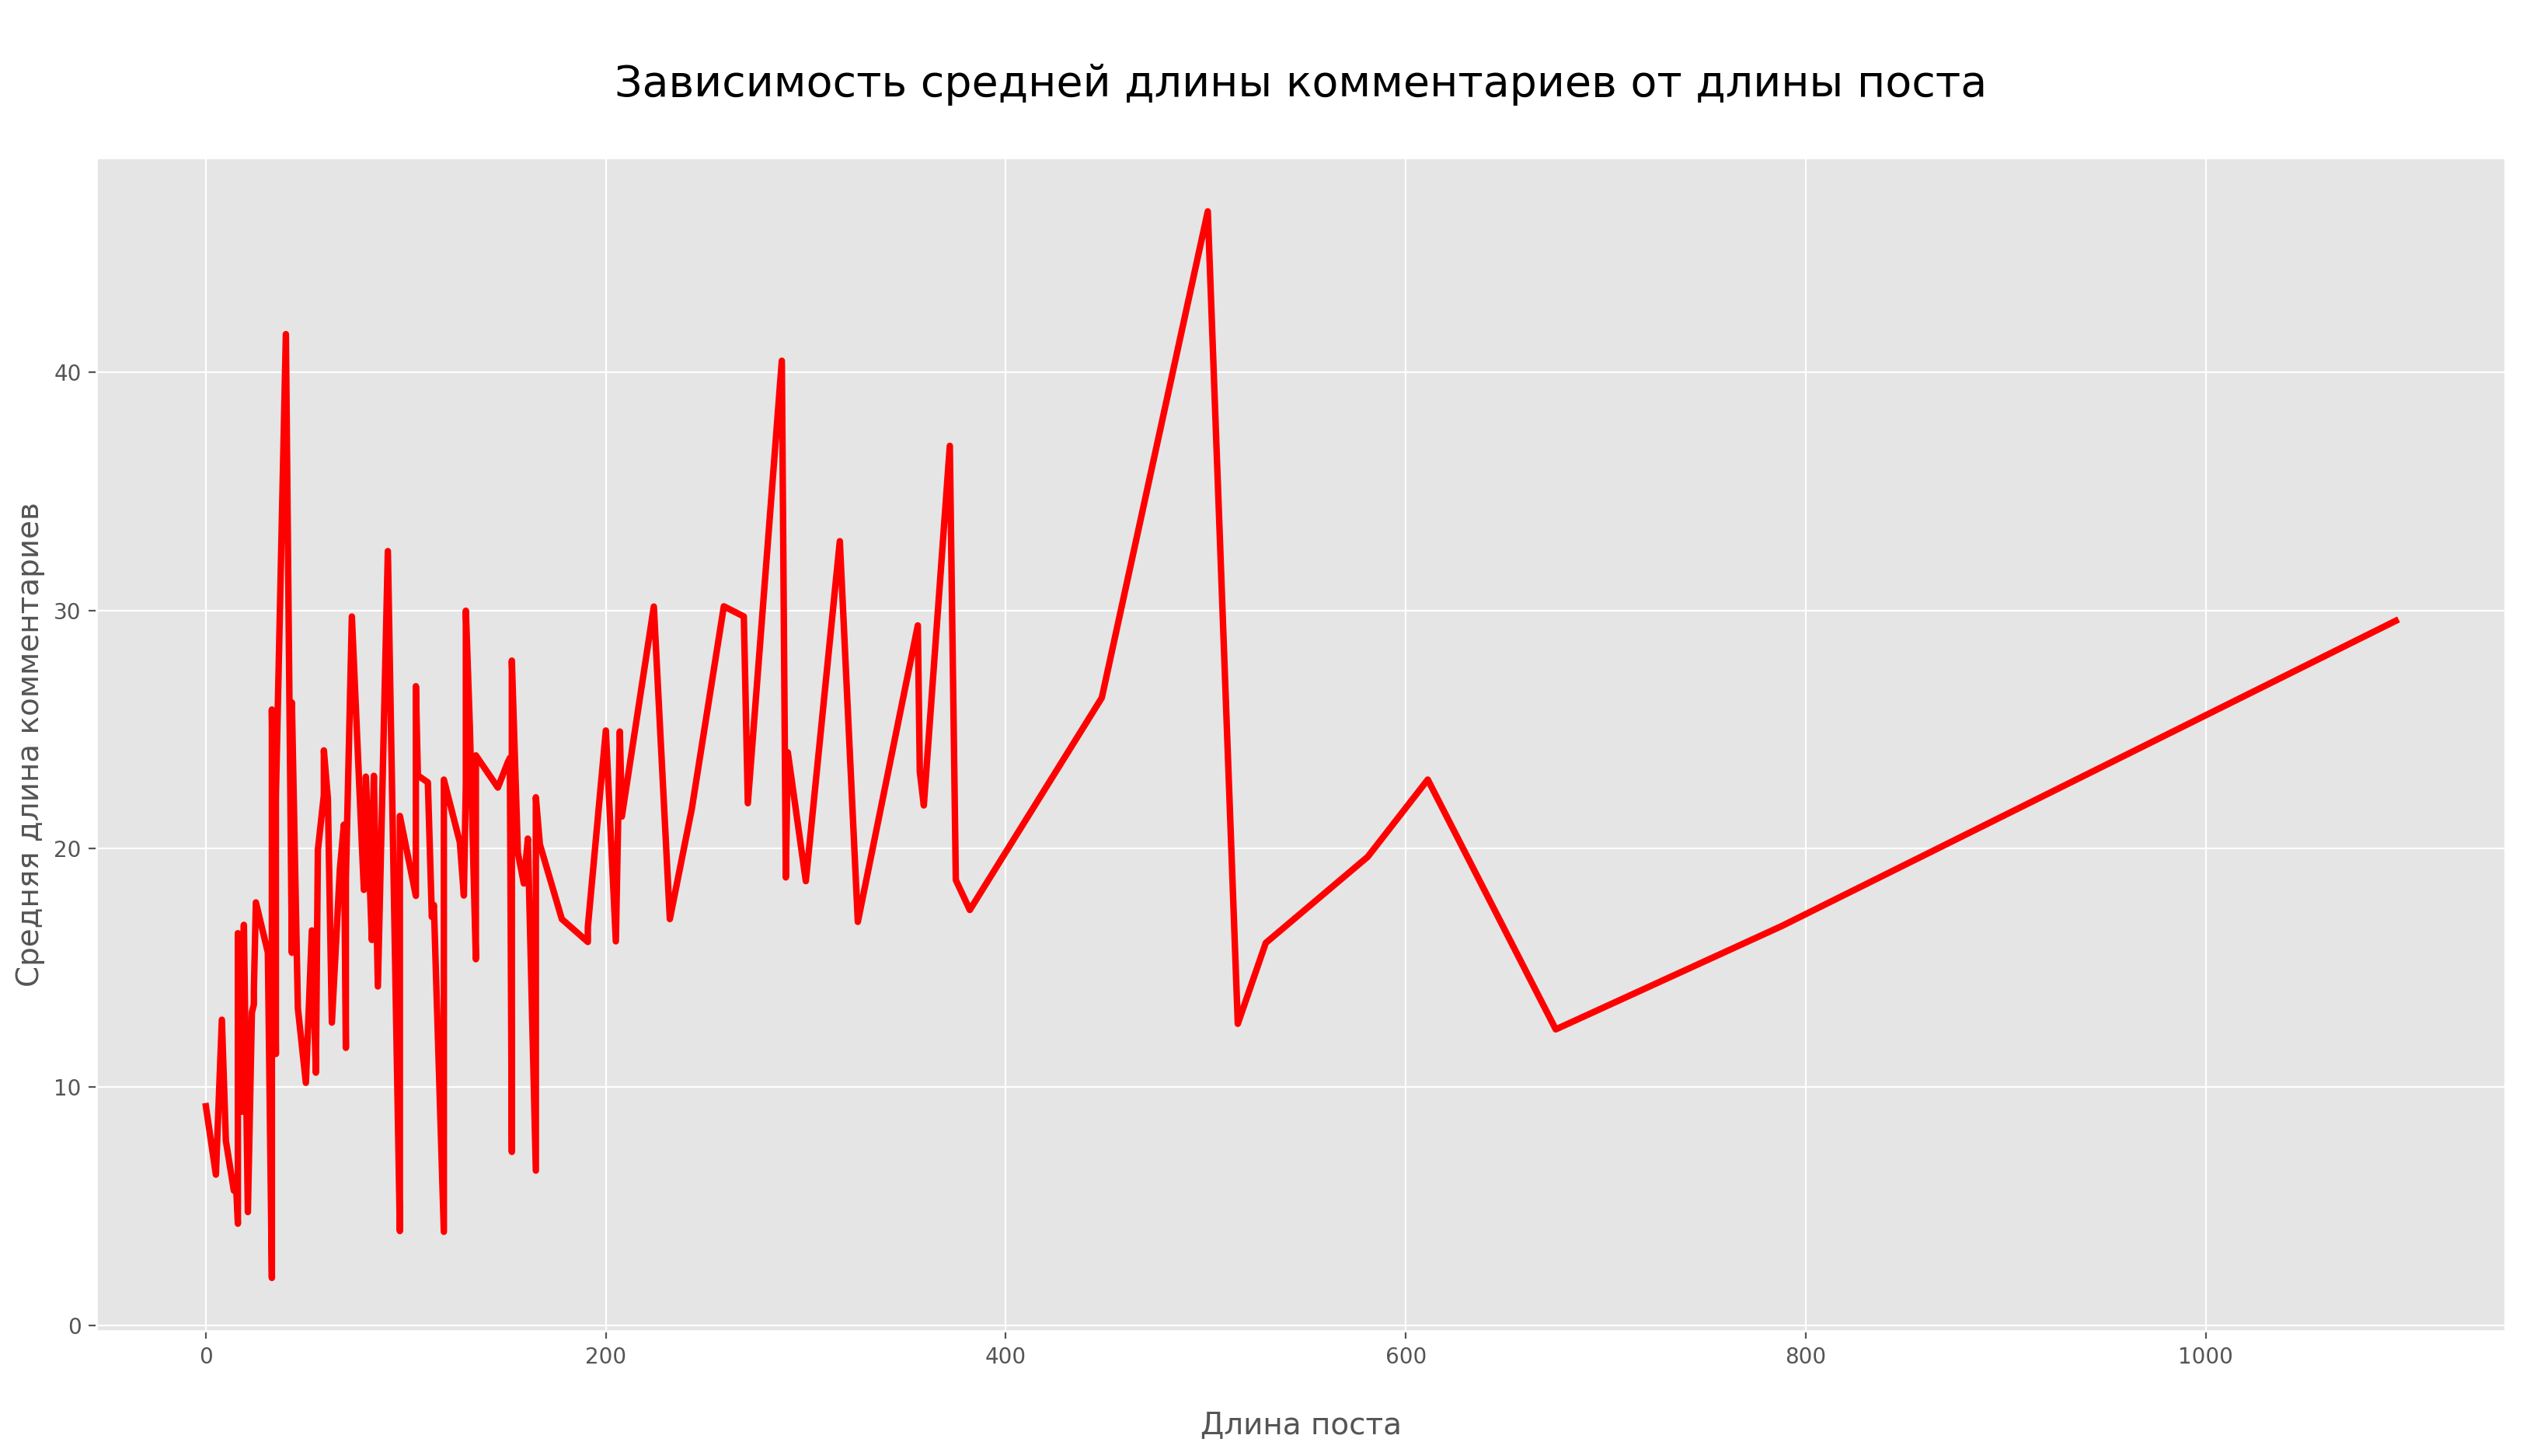

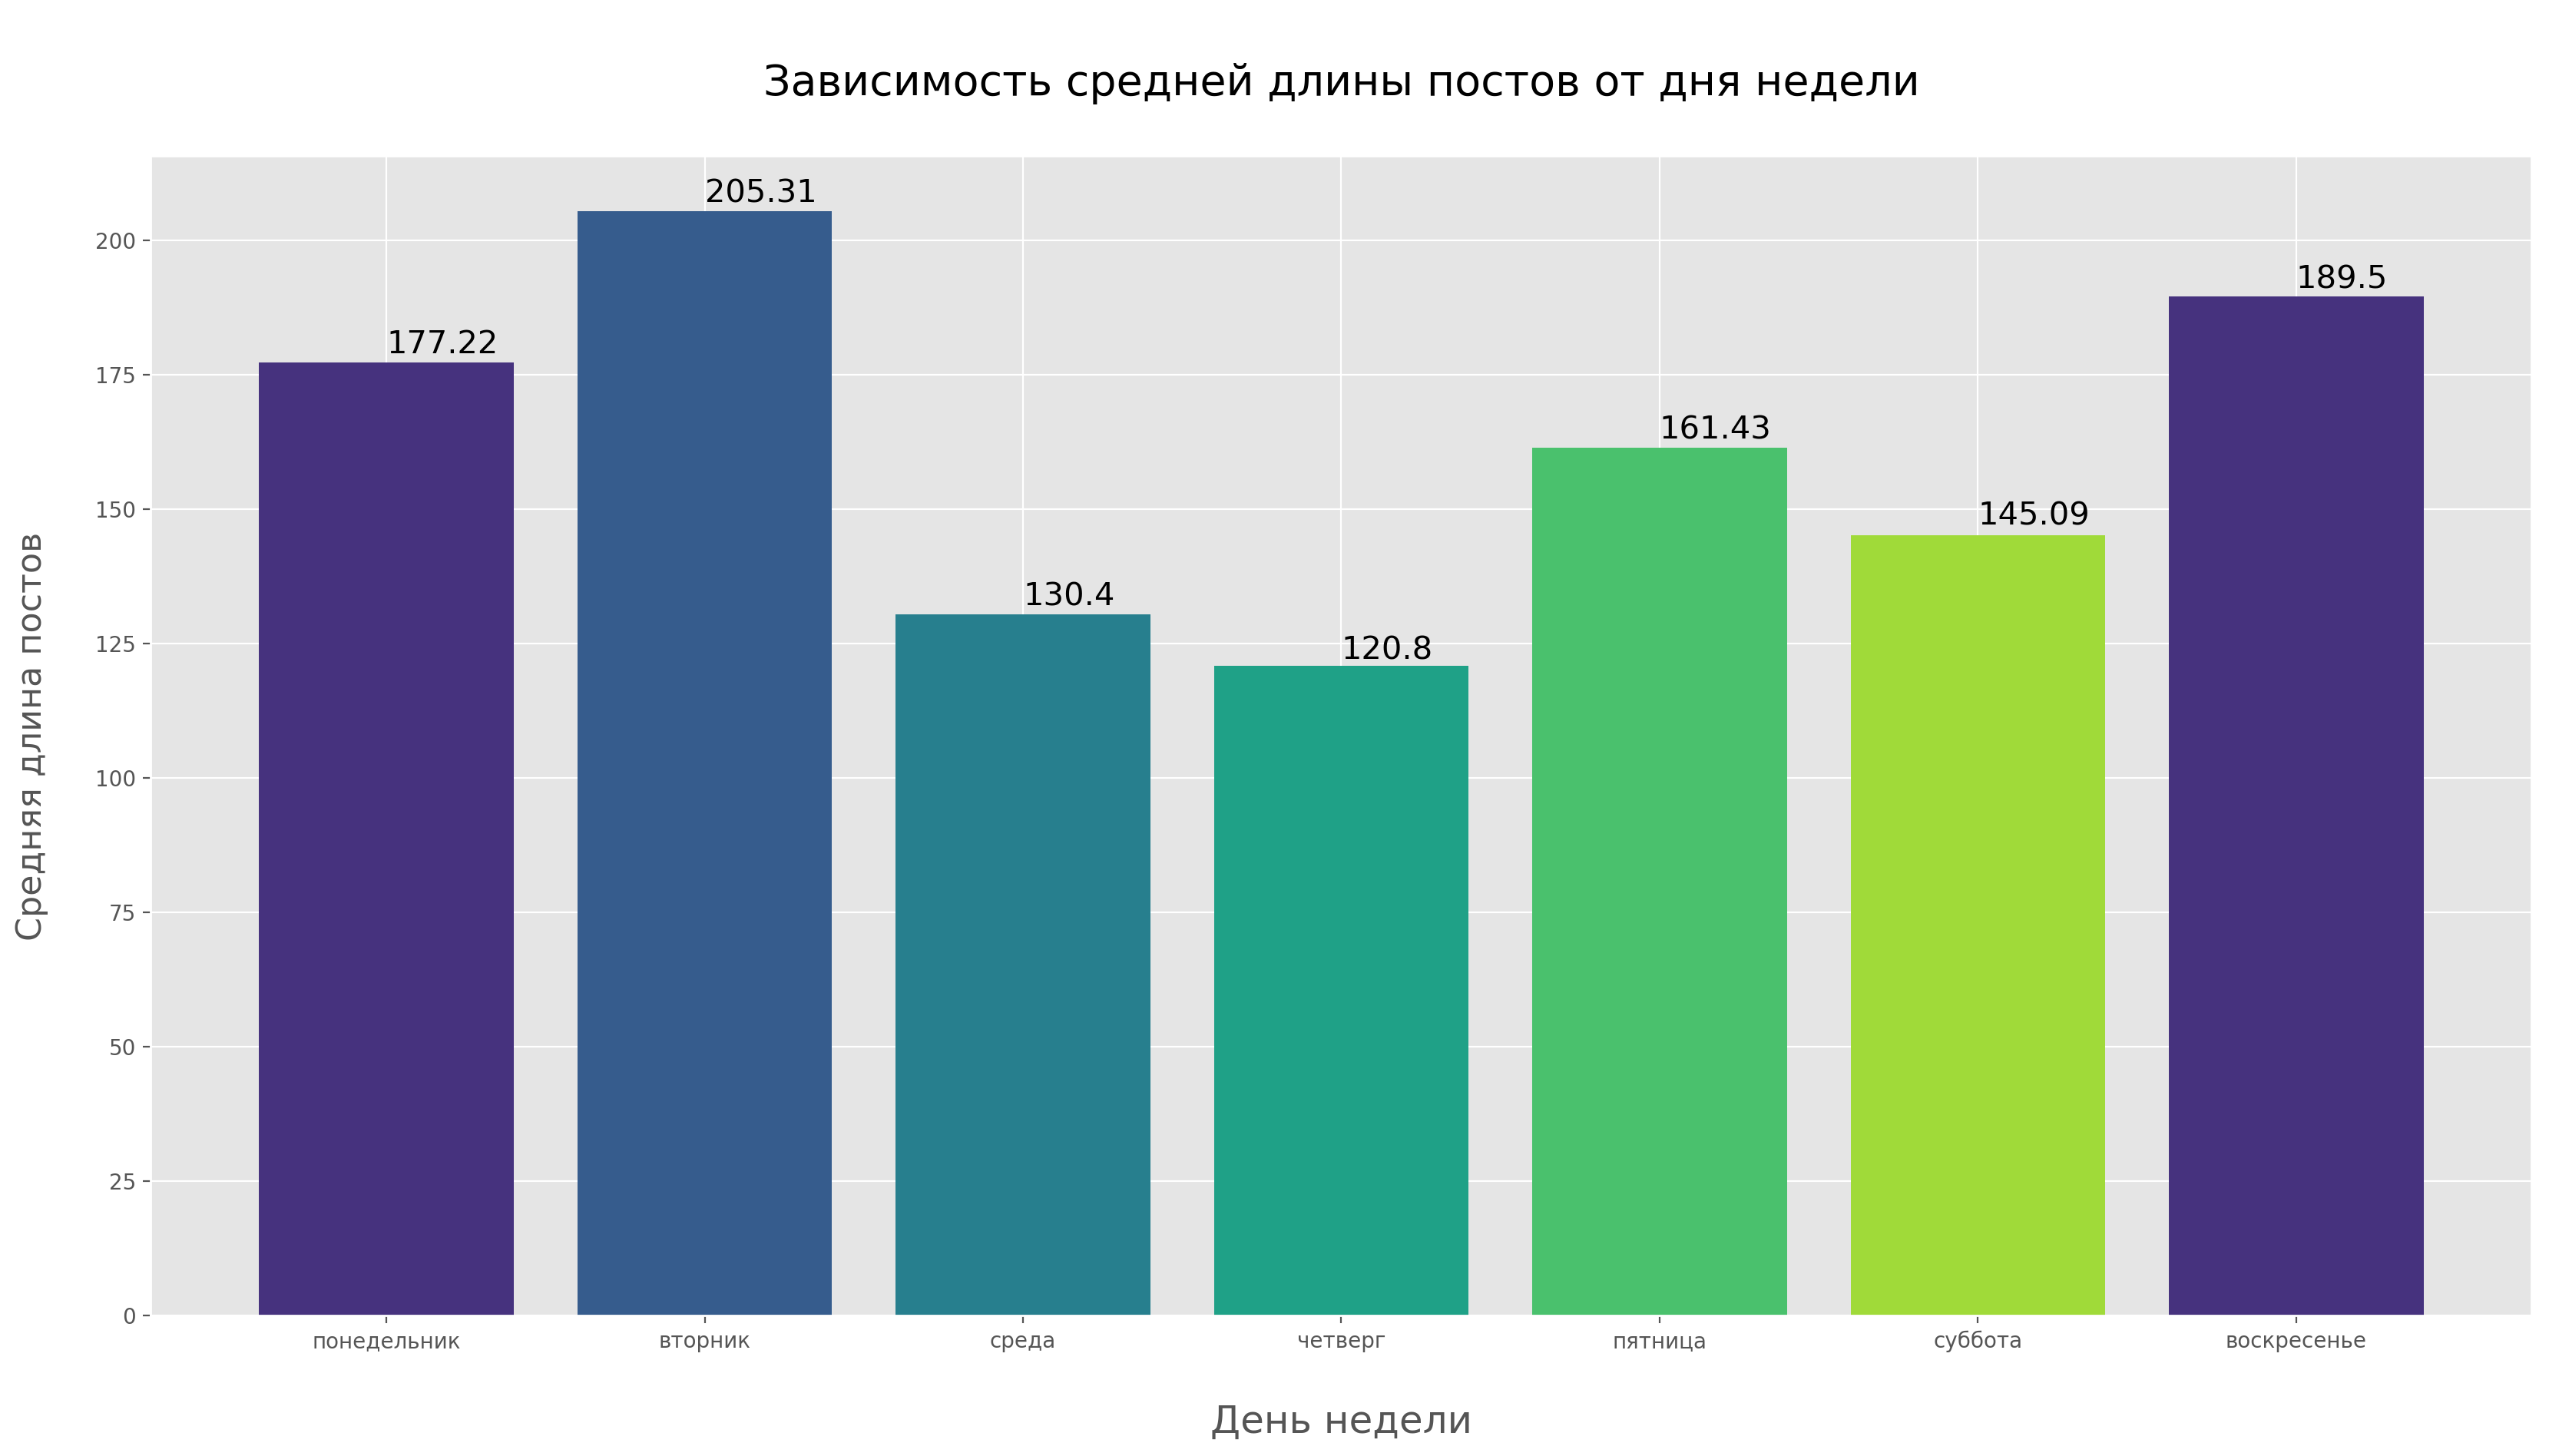

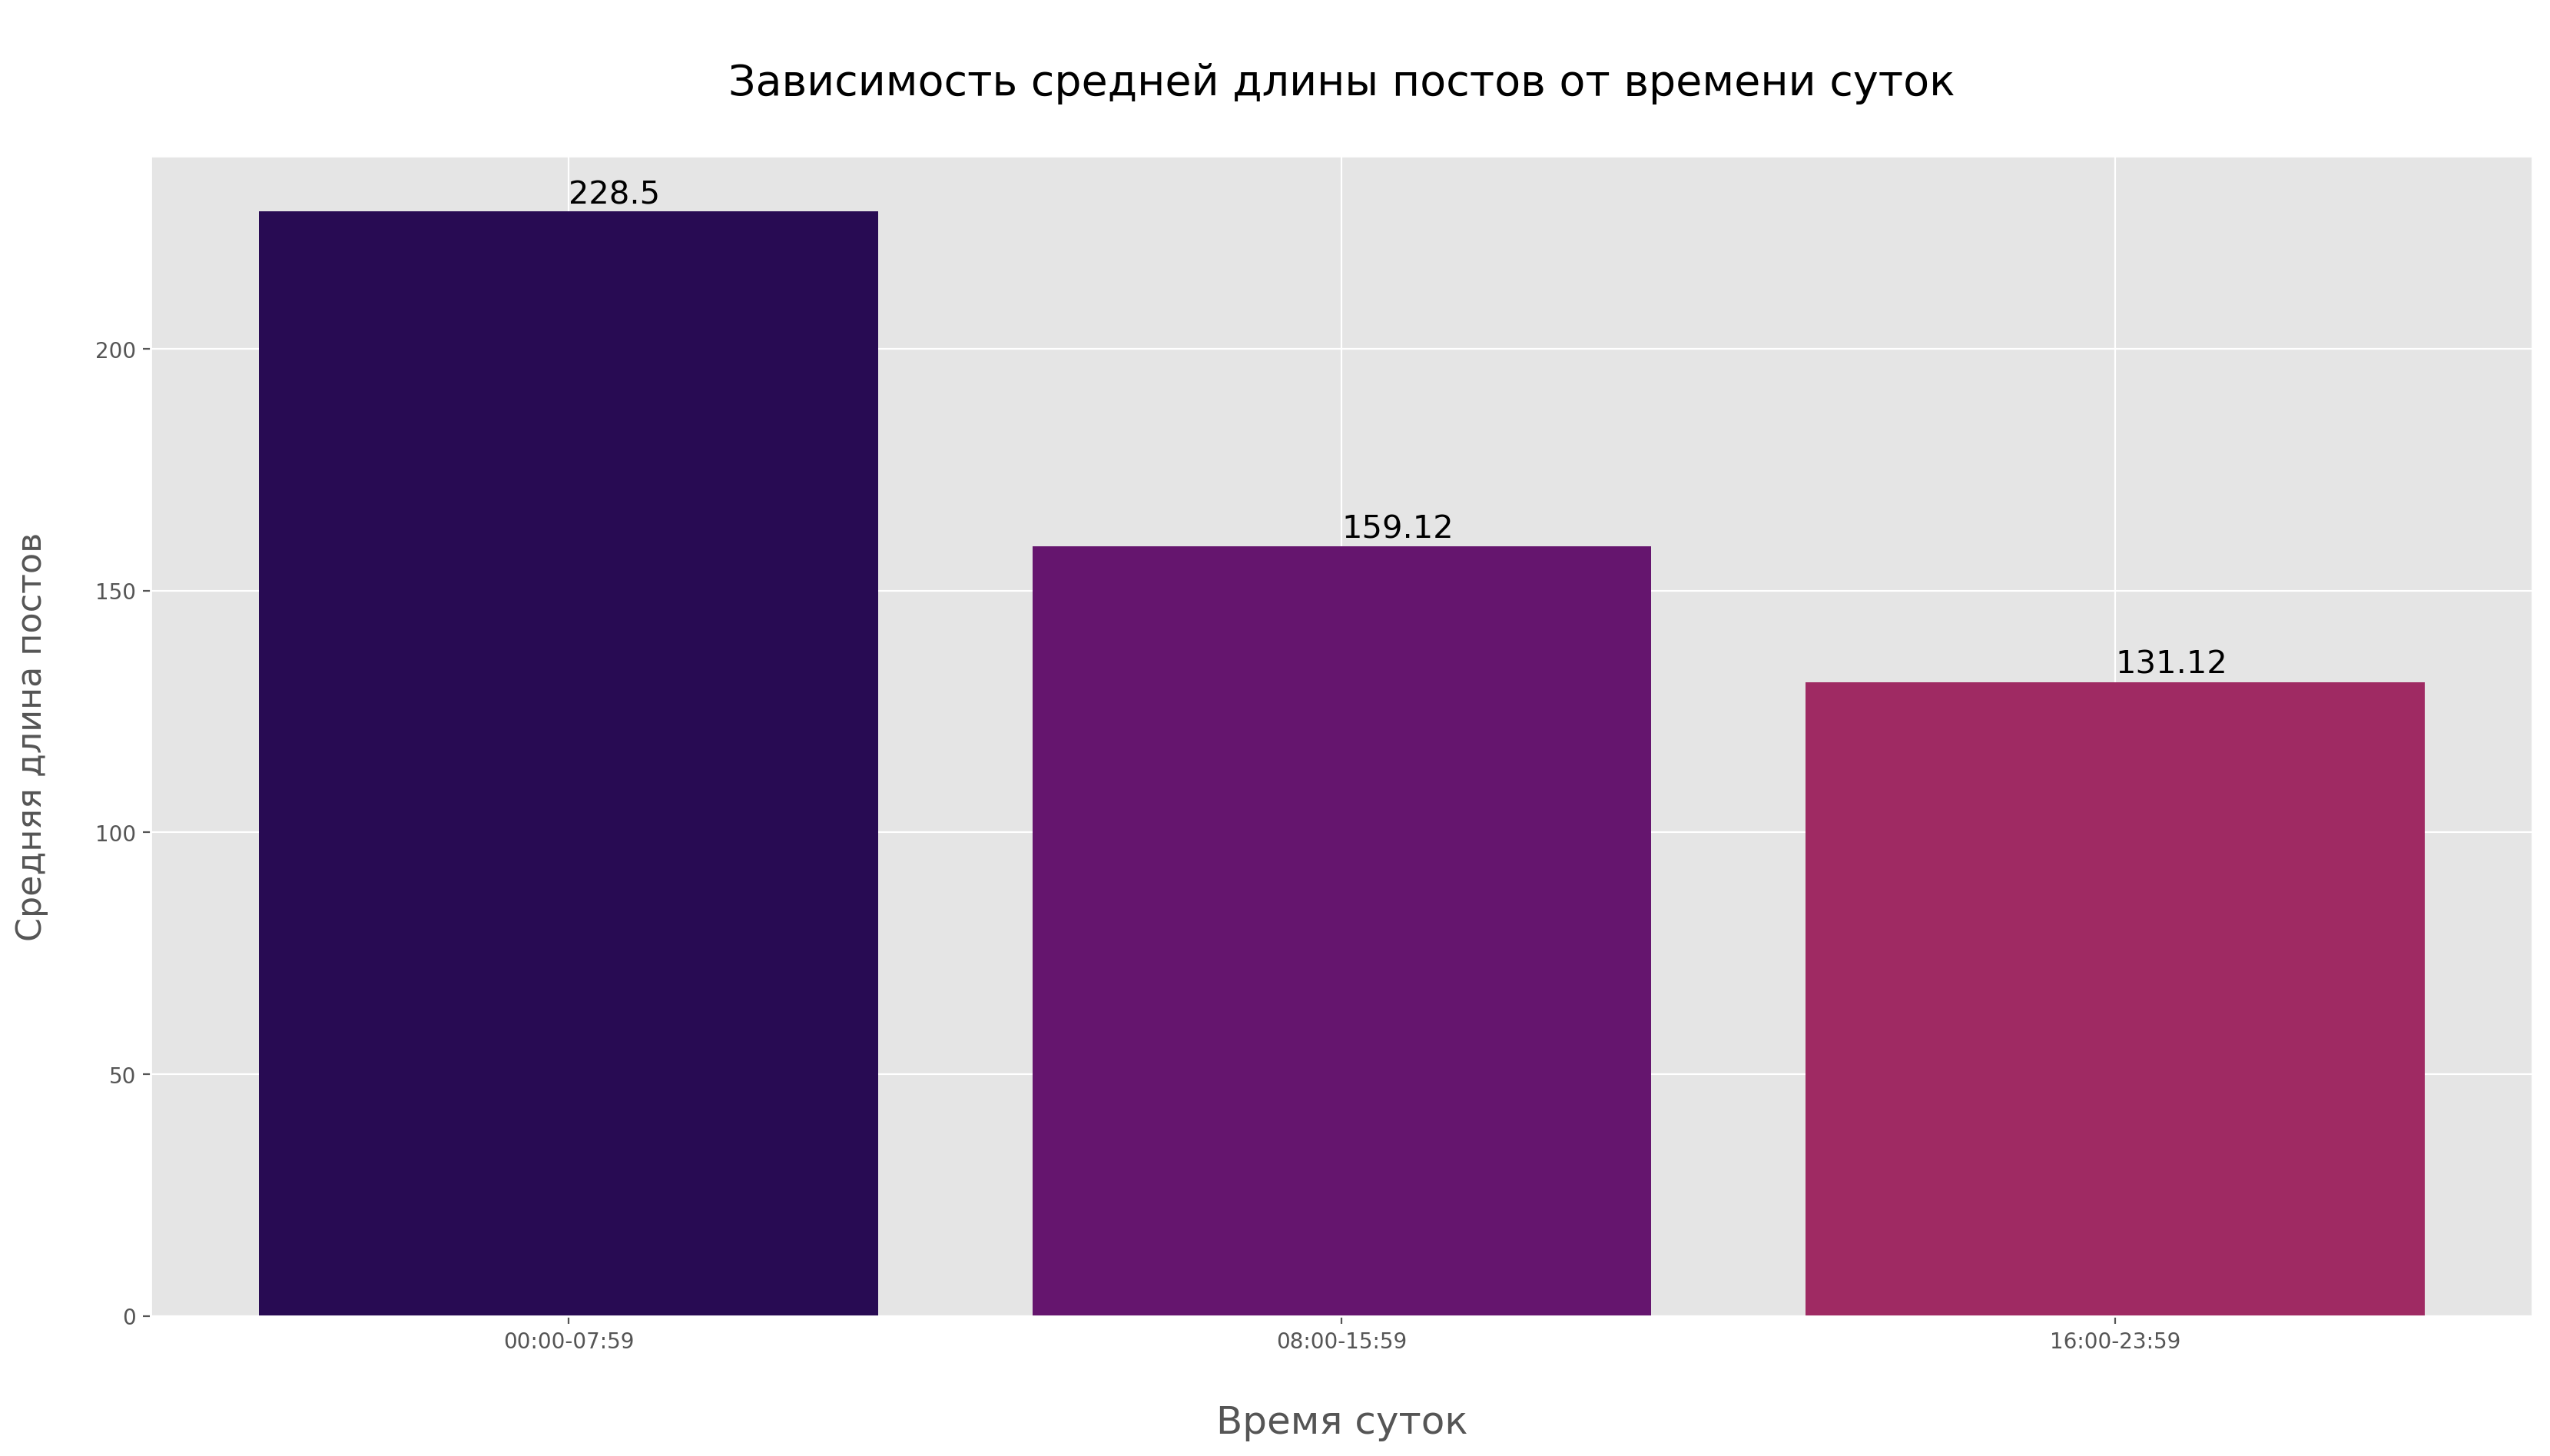

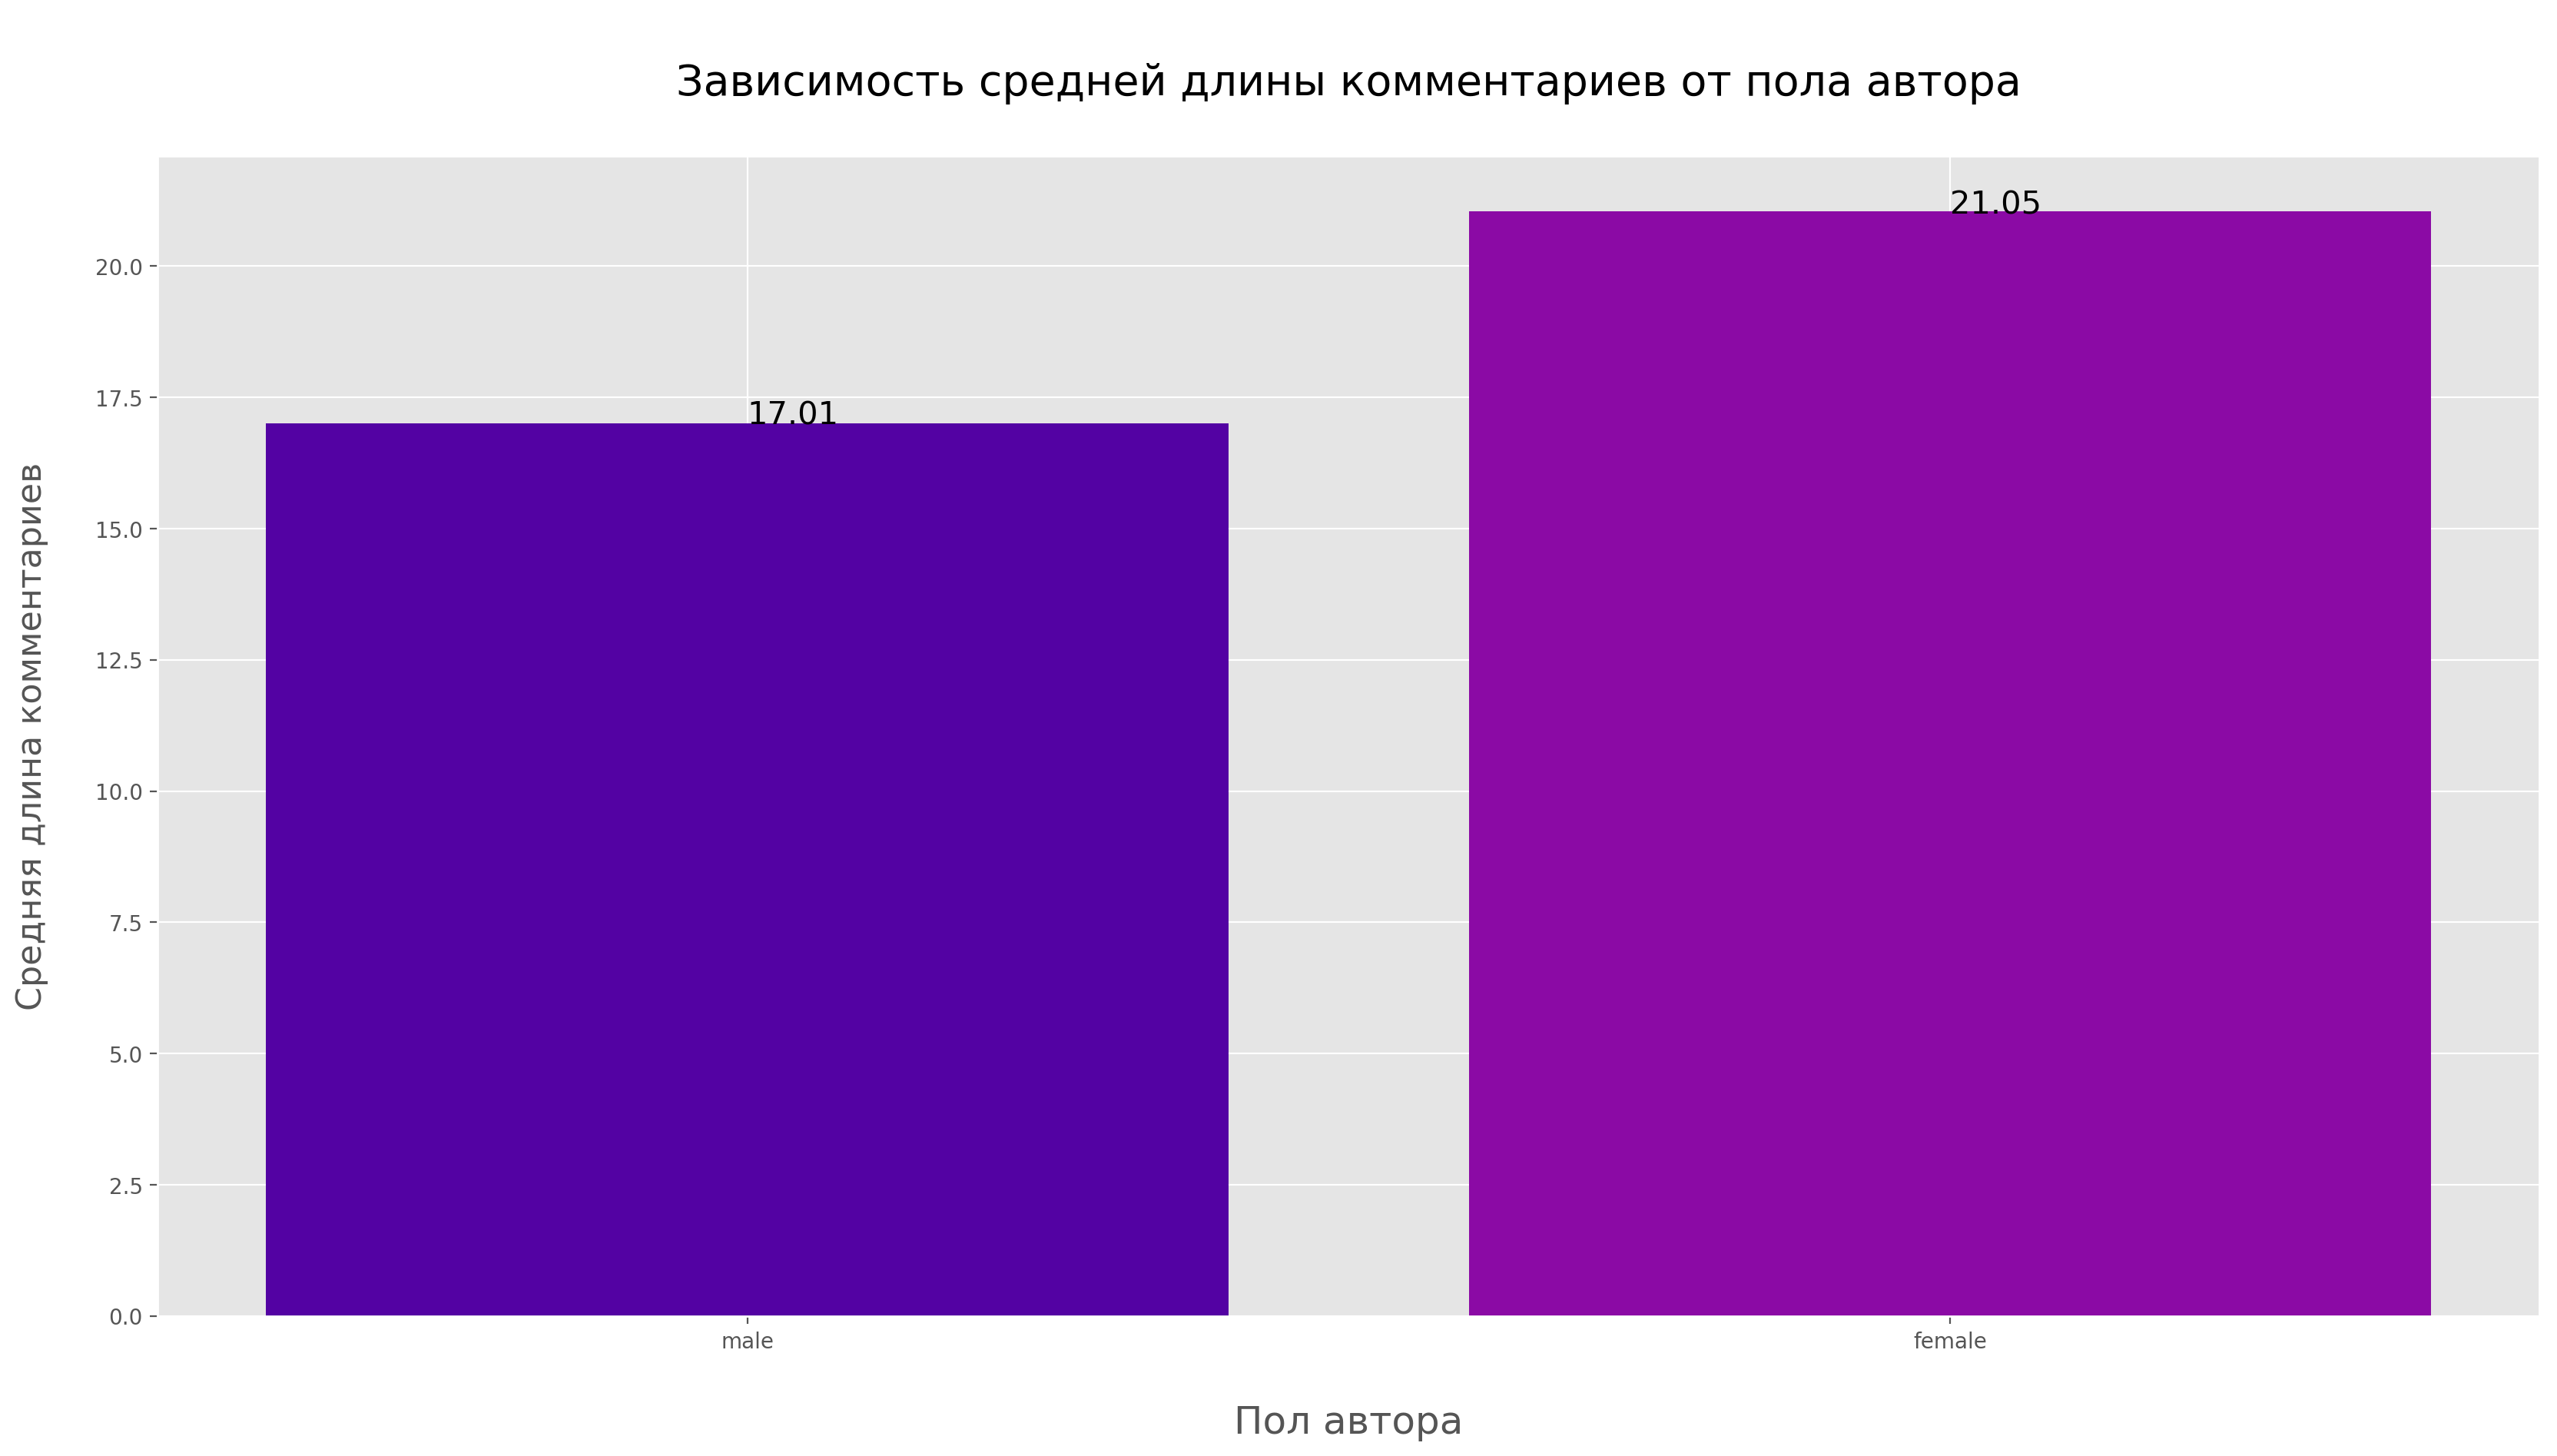

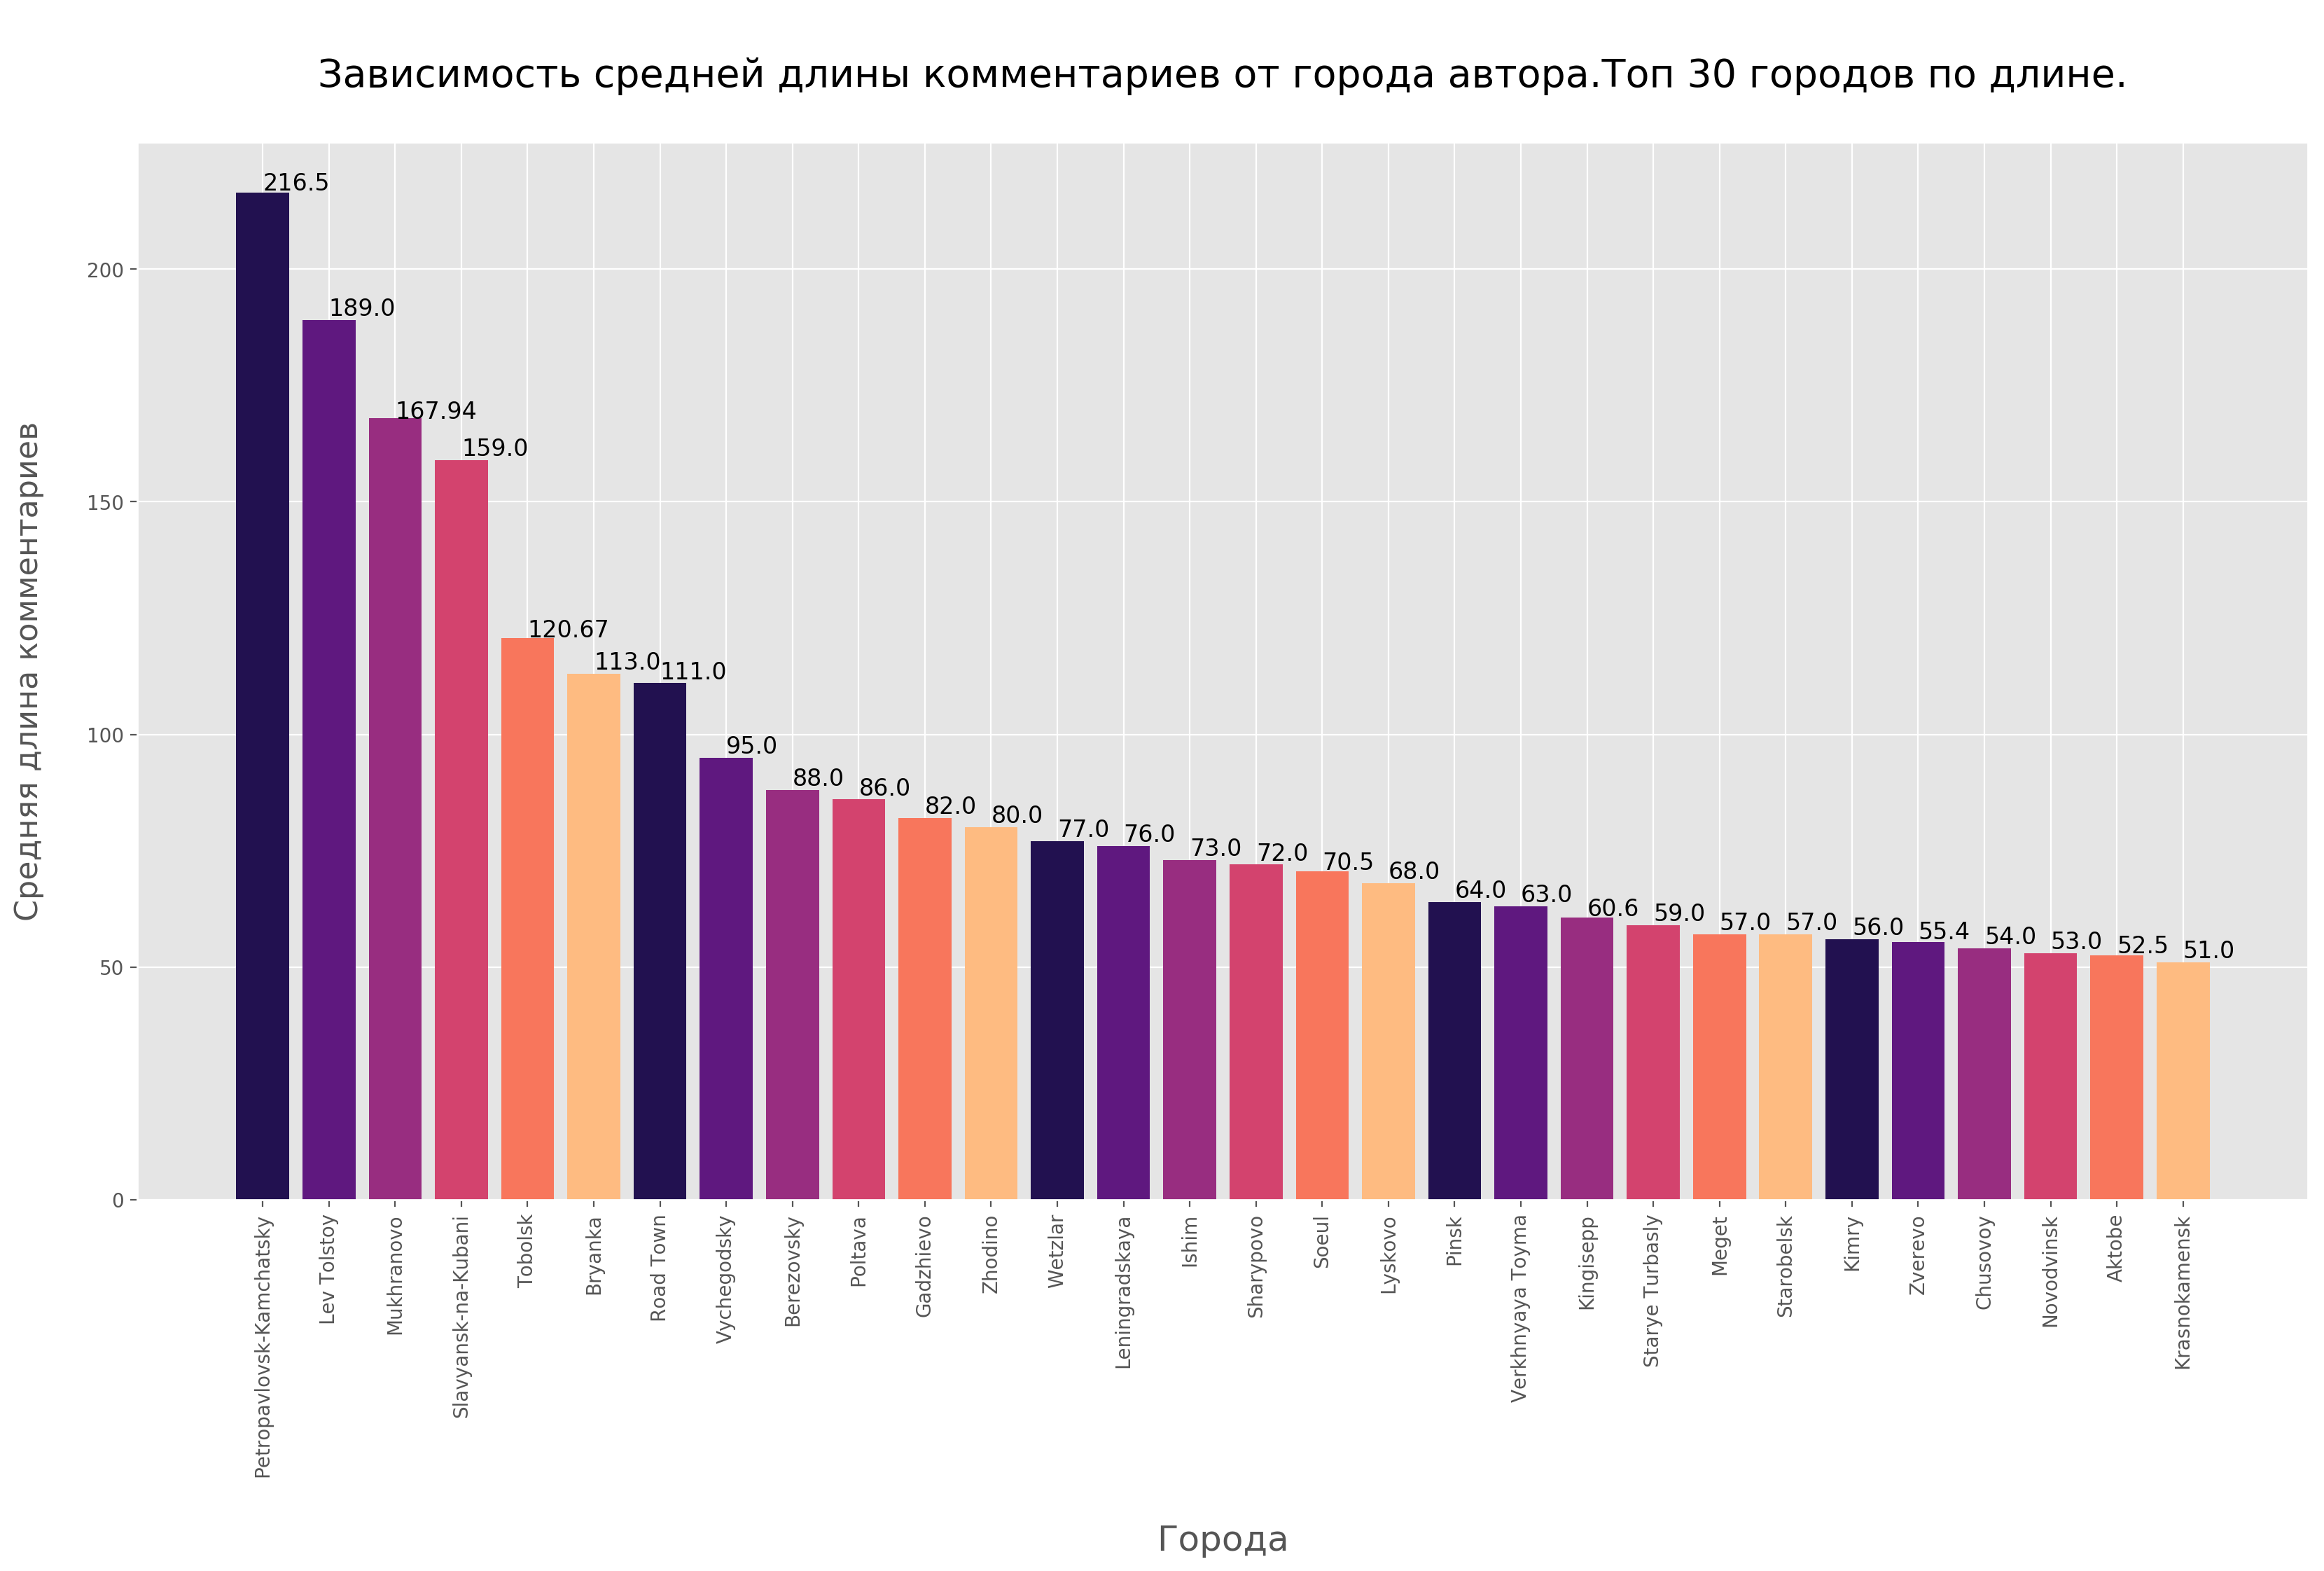

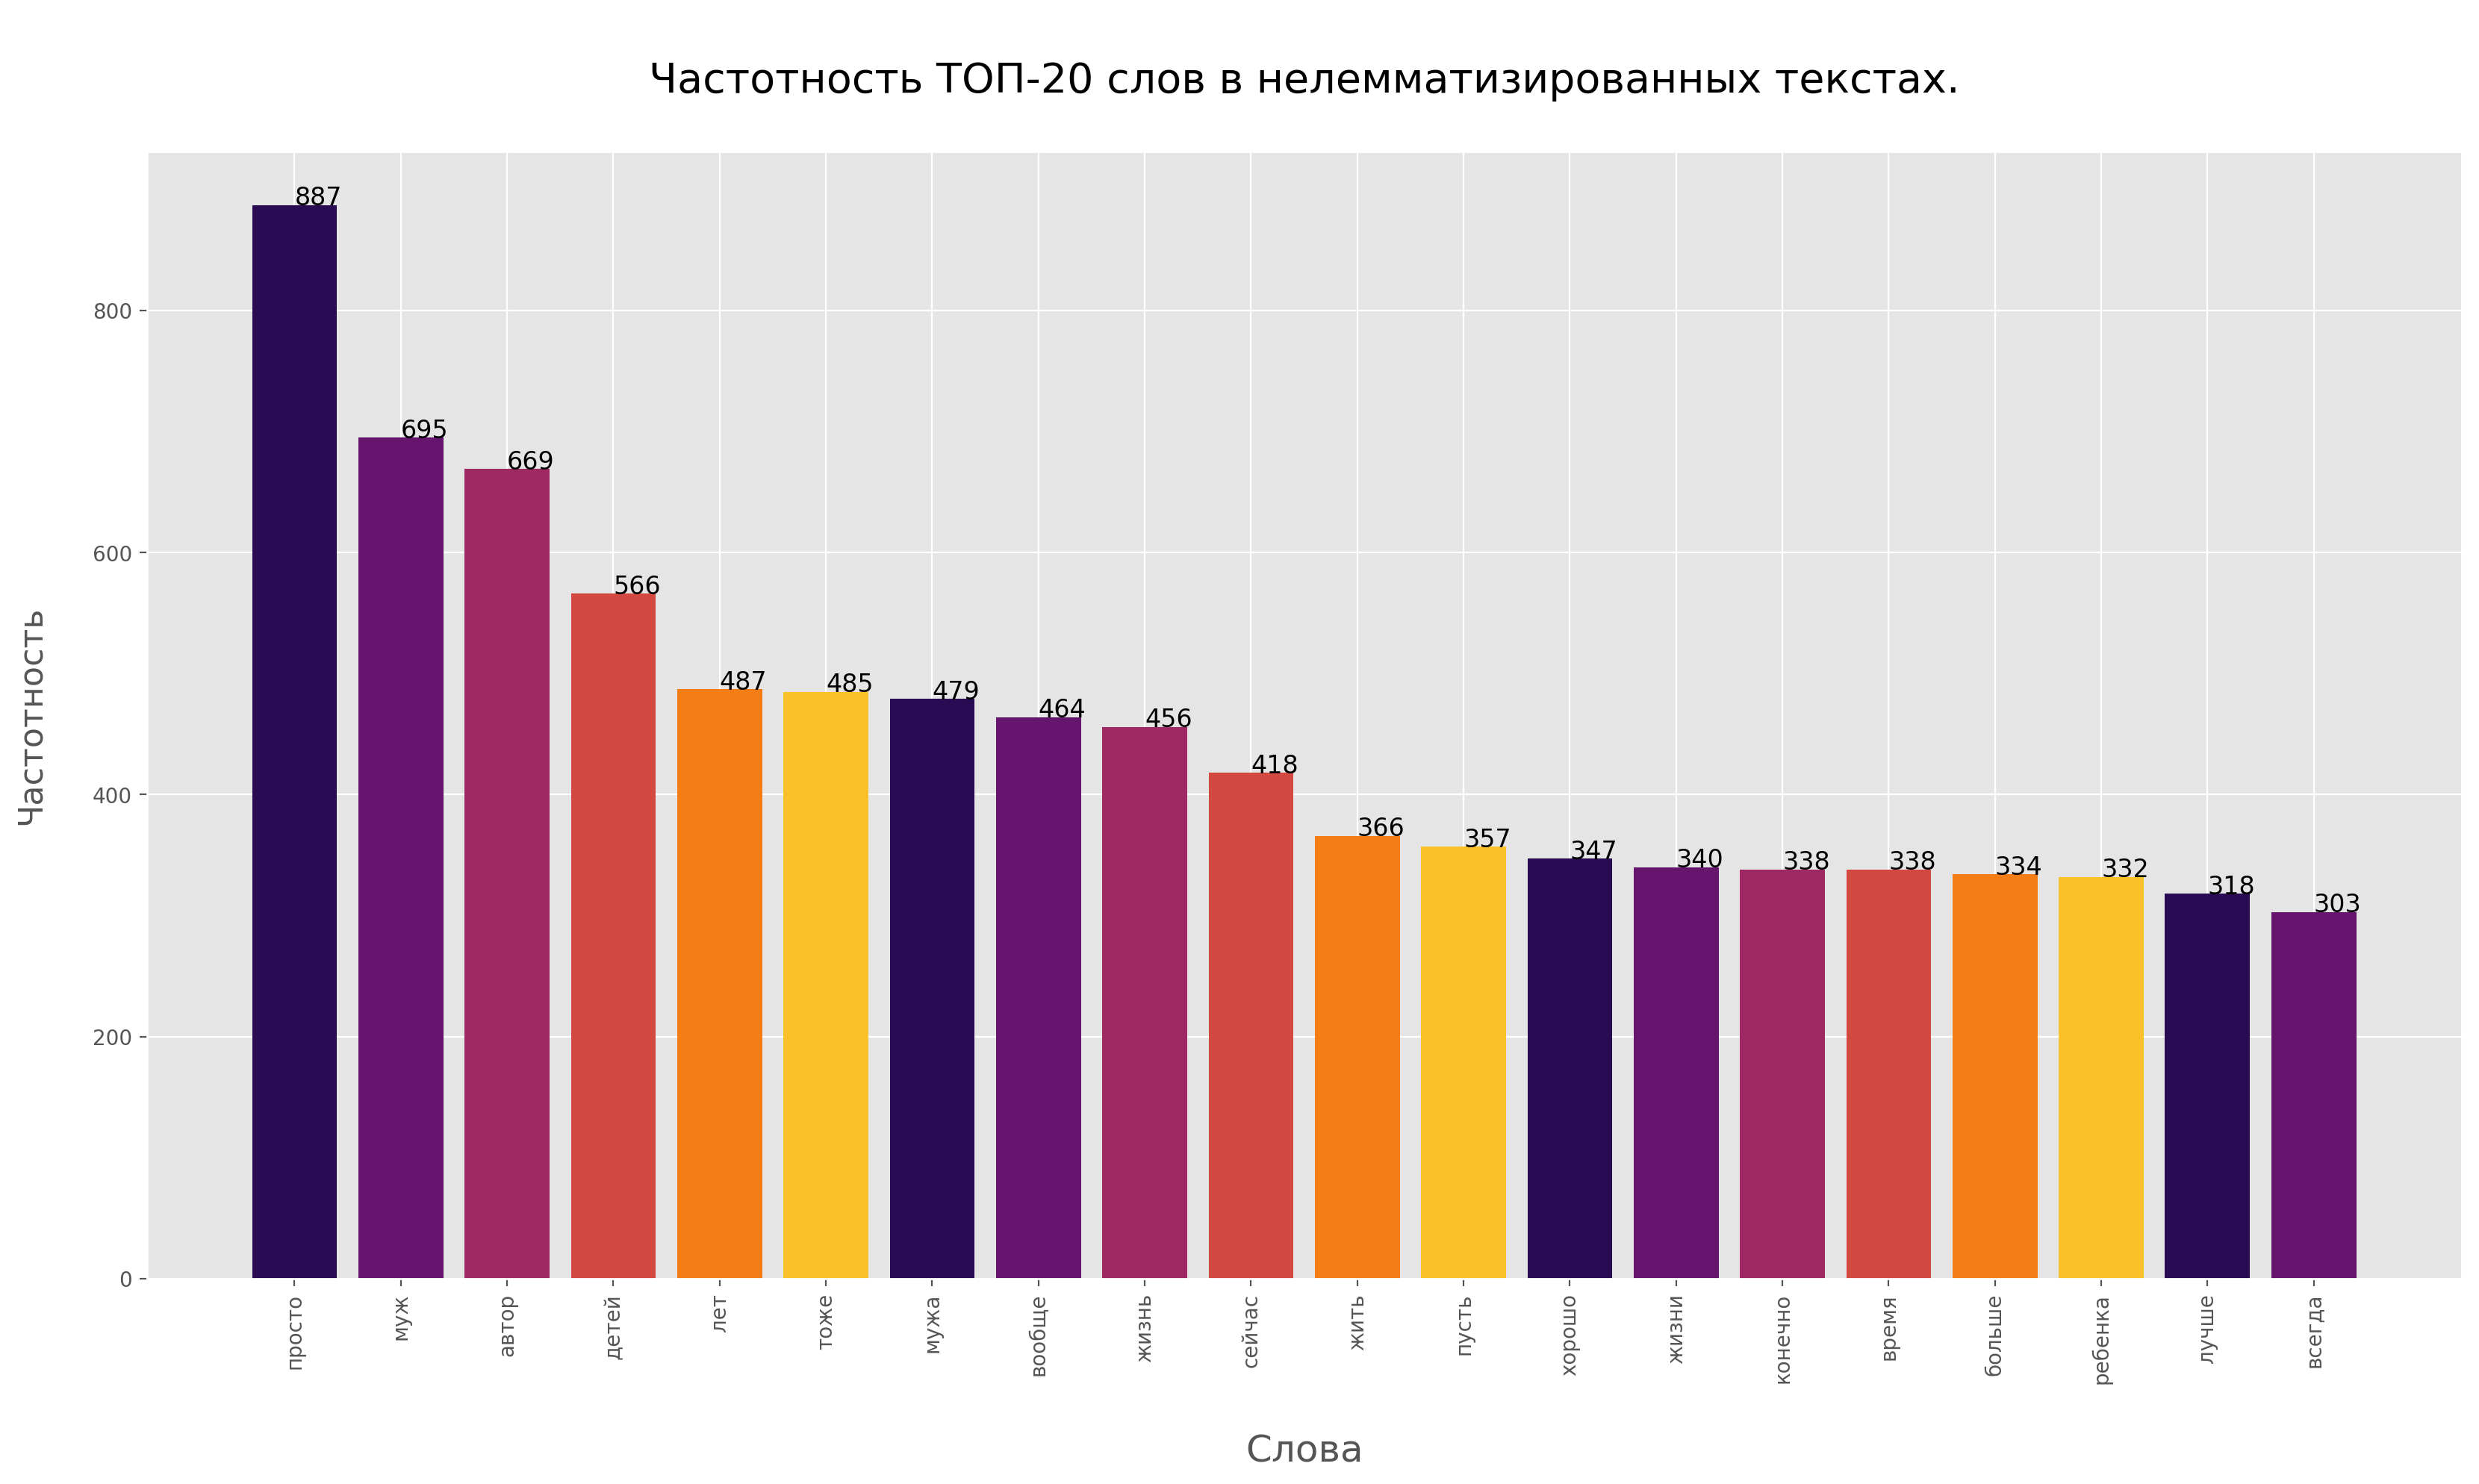

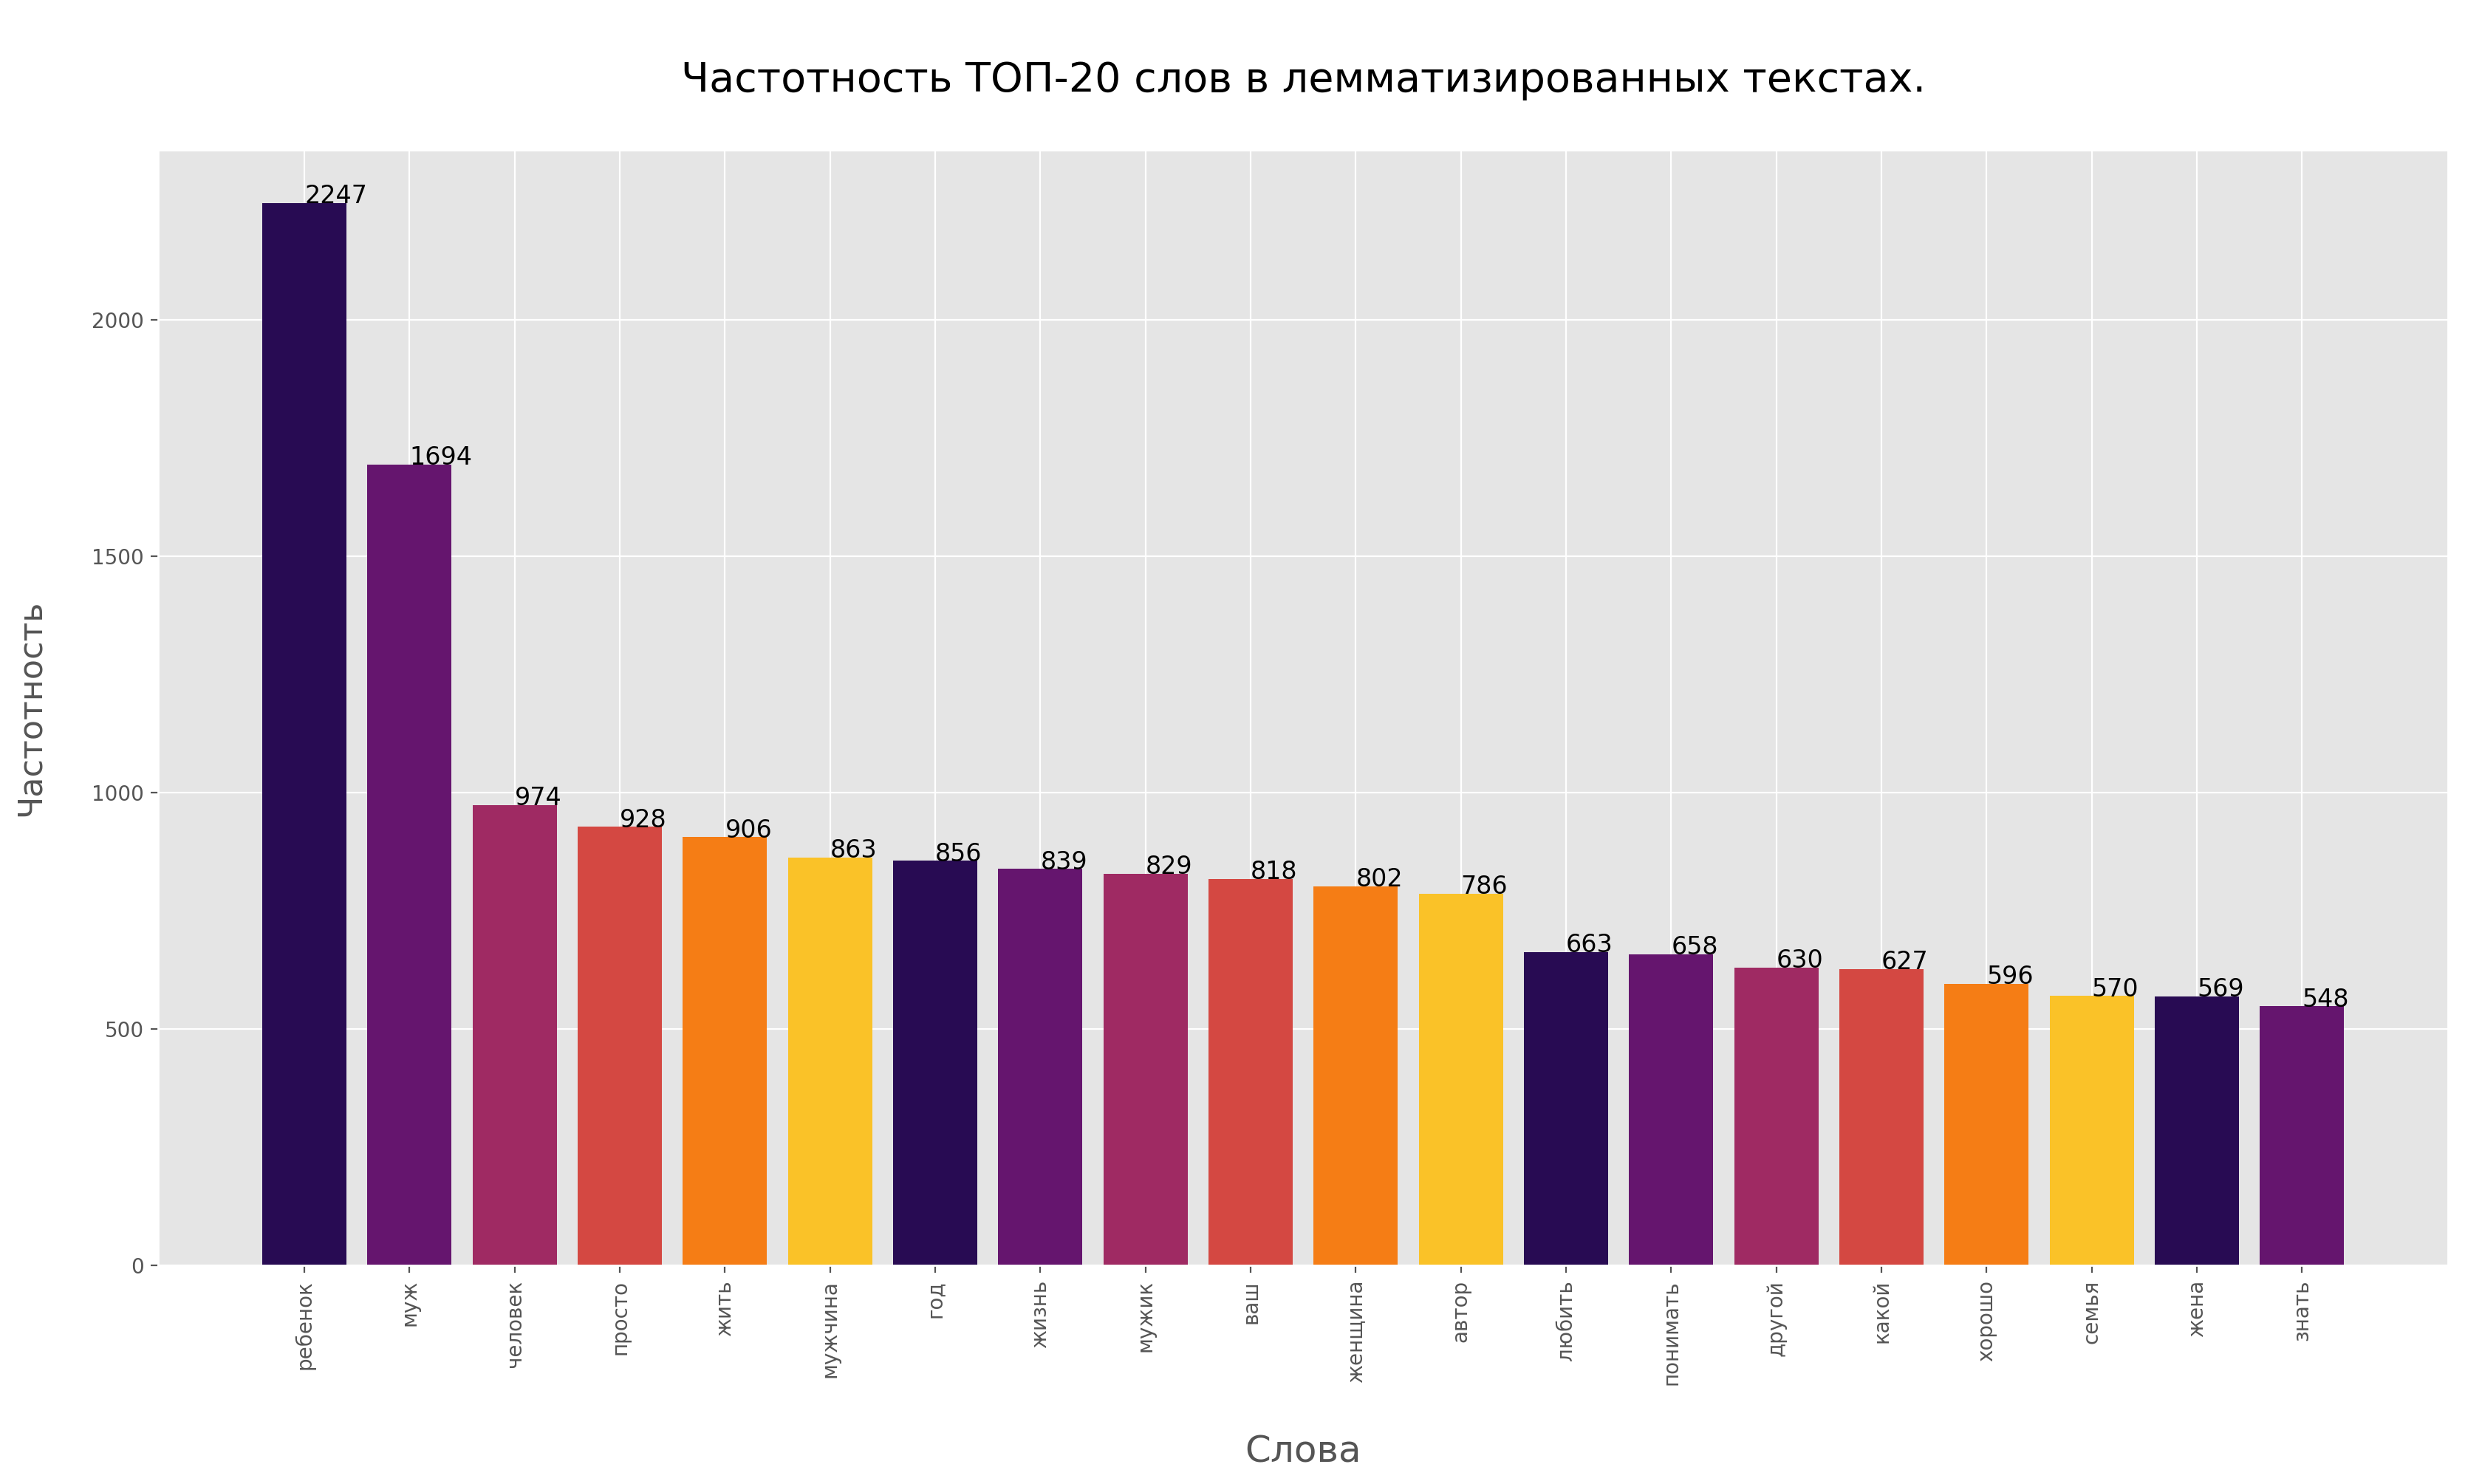

In [324]:
def main():  # запускает программу
    take_posts = getting_Posts()
    for_comment = getting_Id()
    comment = comments(for_comment)
    corpus_1 = make_Corpora1()
    corpus_2 = make_Corpora2()
    corpus_3 = make_Corpora3()
    graph_1 = graph1()
    graph_23 = graph23()
    graph_4 = graph4()
    graph_5 = graph5()
    stopw = stopping()
    grafic = ready_graph6()
    fi_grafic = graph6(grafic, stopw)
    grafic2 = forgrpah_7()
    fi_grafic7 = graph7(grafic2, stopw)

main()


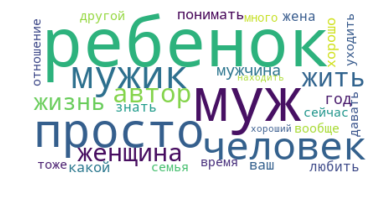

In [335]:
from wordcloud import WordCloud


def stopping_2():  # cписок стоп-слов
    stop_file = './rus_stop.txt'
    with open(stop_file, 'r', encoding='utf-8') as fi:
        st_text = fi.read()
    stop_words = st_text.split()  # список
    return stop_words


def forcloud():  # получаем список слов для облака слов
    word_dict = {}
    file_names = []
    for_search = ''
    start_path = './plain_postsVK/'  # поиск в папке
    for root, dirs, files in os.walk(start_path):  # обход дерева
        for file in files:
            if "lem" in file:  # в лемматизированных текстах
                final = os.path.join(root, file)
                file_names.append(final)
    for norm_file in file_names:  # считываем текст в лем. файлах
        with open(norm_file, 'r', encoding='utf-8') as f:
            text = f.read()
        for_search += text + '\n'  # пополняем строку
    # удаляем "-" внутри слов
    clean_t = re.sub(r'[а-яА-ЯёЁ](-)[а-яА-ЯёЁ]', '', for_search)
    clean_text = re.findall(r'[а-яА-ЯёЁ]+', clean_t)  # только русские слова
    return clean_text


def word_Clouds(stop_words, clean_text):
    norm_words = []
    wdict = {}
    text = ''
    for word in clean_text:  # убираем стоп-слова
        if word not in stop_words:
            norm_words.append(word)
    for el in norm_words:
        text += el + ' '
    cloud = WordCloud(background_color="white", max_words=30)
    # генерируем
    cloud.generate(text)
    # визуализируем
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis("off")
    plt.savefig("cloudwords.png", dpi=200, fromat='png',
                bbox_inches='tight')


def main_2():
    stop = stopping_2()
    cloud_list = forcloud()
    cloud = word_Clouds(stop, cloud_list)

main_2()
